In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
#!pip install lime
#!pip install shap
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def generate_distributions(explainer, features, test_x, bin_min = -1, bin_max = 1, bin_width = 0.05):
    
    #generate shap values for entire test set
    shap_values = explainer.shap_values(test_x, check_additivity = False)
#    print(shap_values)
    shap_val_feat = np.transpose(shap_values)
#    print(shap_val_feat)
    feats = np.transpose(test_x)
    
    shap_distribs = []
    
    #For each feature
    for i in range(len(features)):
        print (i+1, "of", len(features), "features")
        shap_vals = shap_val_feat[i]
#        print(shap_vals)

        #create bins based on shap value ranges
        bins = np.arange(bin_min, bin_max, bin_width)

        feat_vals = []
        for sbin in range(len(bins)):
            nl = []
            feat_vals.append(nl)

        #place relevant feature values into each bin
        for j in range(len(shap_vals)):
            val = shap_vals[j]
            b = 0
            cur_bin = bins[b]
            idx = b

            while val > cur_bin and b < len(bins)-1:
                #print(cur_bin)
                idx = b
                b+=1
                #print(b)
                cur_bin = bins[b]

            #print(val, idx)
            feat_vals[idx].append(feats[i][j])

        #Remove feature values that are outliers
        #for each in feat_vals:
        #    zscore = stats.zscore(each)
            #print(each)
        #    for n in range(len(zscore)):
        #        if zscore[n] > 3 or zscore[n] < -3:
        #            np.delete(zscore, n)
        #            del each[n]
            #print(each)
            
        #Find min and max values for each shap value bin
        mins = []
        maxes = []
        #width = []
        #print(feat_vals)
        #n = 0
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
         #       width.append("Bin "+str(n))
         #       n+=1
        #plt.bar(width, maxes, bottom = mins)
        #plt.show()

        #Create dictionary with list of bins and max and min feature values for each bin
        feat_name = features[i]

        feat_dict = {'Feature Name': feat_name}
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
            else:
                mins.append(None)
                maxes.append(None)

        feat_dict['bins'] = bins
        feat_dict['mins'] = mins
        feat_dict['maxes'] = maxes
       
        shap_distribs.append(feat_dict)
        
    return shap_distribs

In [9]:
dataset_ref = "bpic2012"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "agg"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
#max_feat = 10
max_prefix = 25

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['bpic2012_accepted']

Bucket 1
Generating distributions for bucket
1 of 43 features
2 of 43 features
3 of 43 features
4 of 43 features
5 of 43 features
6 of 43 features
7 of 43 features
8 of 43 features
9 of 43 features
10 of 43 features
11 of 43 features
12 of 43 features
13 of 43 features
14 of 43 features
15 of 43 features
16 of 43 features
17 of 43 features
18 of 43 features
19 of 43 features
20 of 43 features
21 of 43 features
22 of 43 features
23 of 43 features
24 of 43 features
25 of 43 features
26 of 43 features
27 of 43 features
28 of 43 features
29 of 43 features
30 of 43 features
31 of 43 features
32 of 43 features
33 of 43 features
34 of 43 features
35 of 43 features
36 of 43 features
37 of 43 features
38 of 43 features
39 of 43 features
40 of 43 features
41 of 43 features
42 of 43 features
43 of 43 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution 

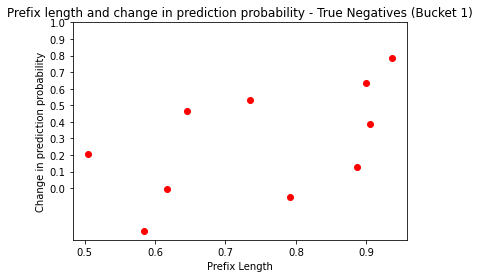

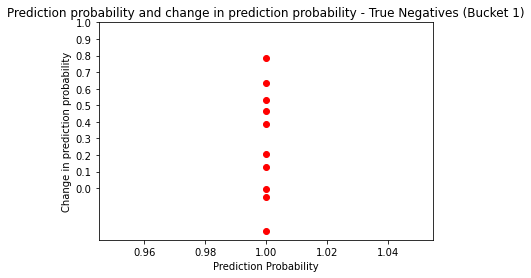

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating di

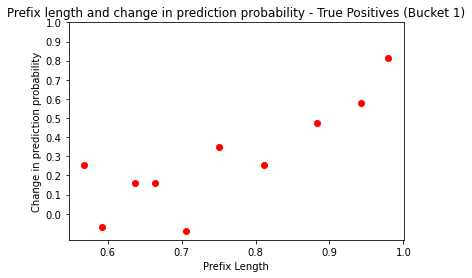

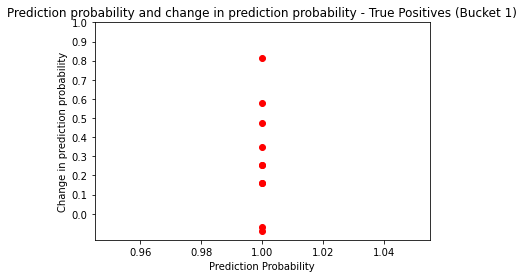

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating di

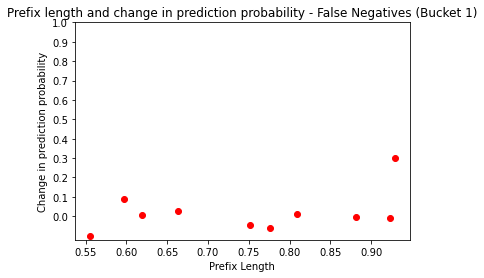

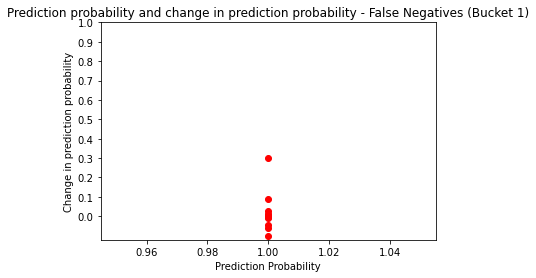

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating di

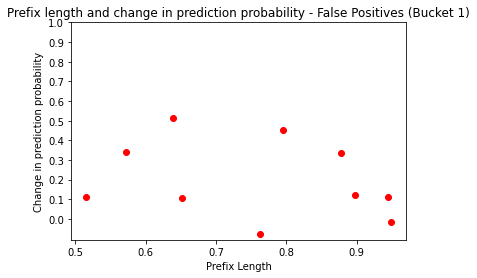

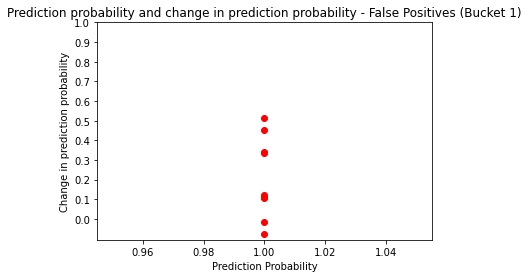

Bucket 2
Generating distributions for bucket
1 of 44 features
2 of 44 features
3 of 44 features
4 of 44 features
5 of 44 features
6 of 44 features
7 of 44 features
8 of 44 features
9 of 44 features
10 of 44 features
11 of 44 features
12 of 44 features
13 of 44 features
14 of 44 features
15 of 44 features
16 of 44 features
17 of 44 features
18 of 44 features
19 of 44 features
20 of 44 features
21 of 44 features
22 of 44 features
23 of 44 features
24 of 44 features
25 of 44 features
26 of 44 features
27 of 44 features
28 of 44 features
29 of 44 features
30 of 44 features
31 of 44 features
32 of 44 features
33 of 44 features
34 of 44 features
35 of 44 features
36 of 44 features
37 of 44 features
38 of 44 features
39 of 44 features
40 of 44 features
41 of 44 features
42 of 44 features
43 of 44 features
44 of 44 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Crea

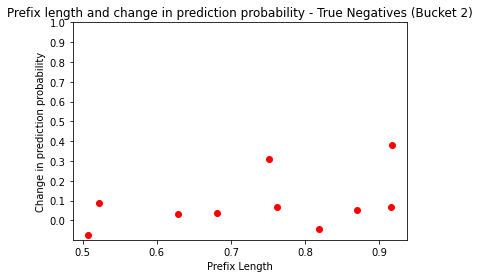

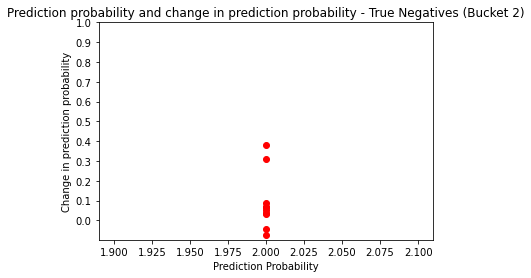

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating di

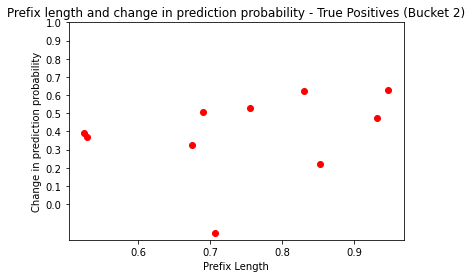

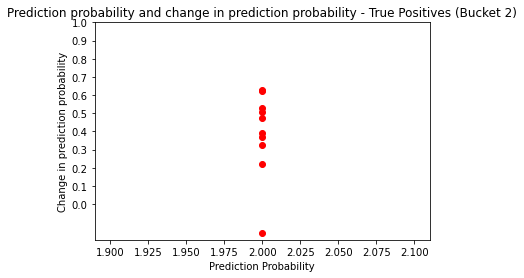

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating di

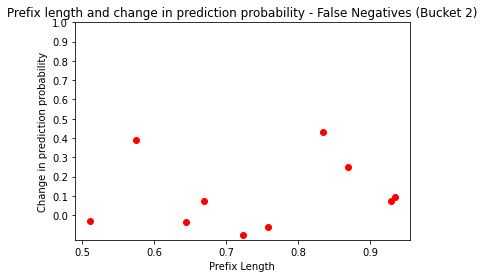

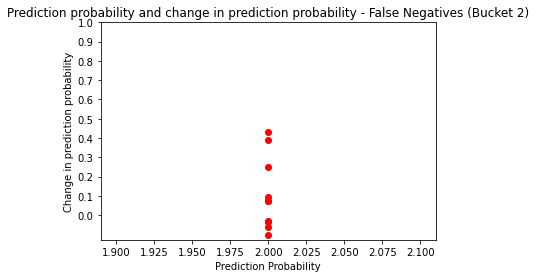

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating distribution for feature 2 of 4
Creating distribution for feature 3 of 4
Creating distribution for feature 4 of 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 4
Creating di

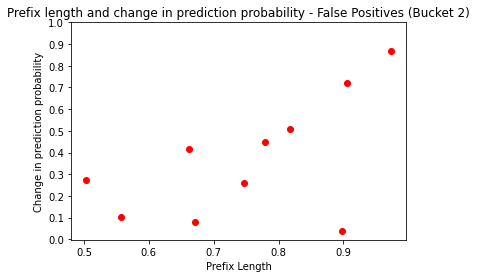

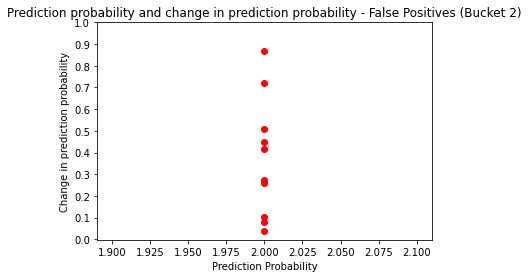

Bucket 3
Generating distributions for bucket
1 of 47 features
2 of 47 features
3 of 47 features
4 of 47 features
5 of 47 features
6 of 47 features
7 of 47 features
8 of 47 features
9 of 47 features
10 of 47 features
11 of 47 features
12 of 47 features
13 of 47 features
14 of 47 features
15 of 47 features
16 of 47 features
17 of 47 features
18 of 47 features
19 of 47 features
20 of 47 features
21 of 47 features
22 of 47 features
23 of 47 features
24 of 47 features
25 of 47 features
26 of 47 features
27 of 47 features
28 of 47 features
29 of 47 features
30 of 47 features
31 of 47 features
32 of 47 features
33 of 47 features
34 of 47 features
35 of 47 features
36 of 47 features
37 of 47 features
38 of 47 features
39 of 47 features
40 of 47 features
41 of 47 features
42 of 47 features
43 of 47 features
44 of 47 features
45 of 47 features
46 of 47 features
47 of 47 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for featur

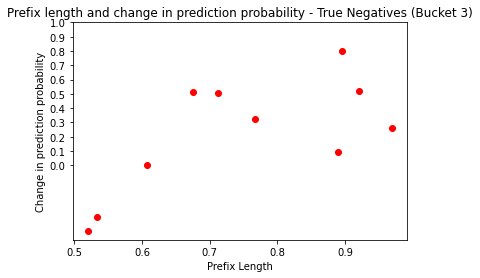

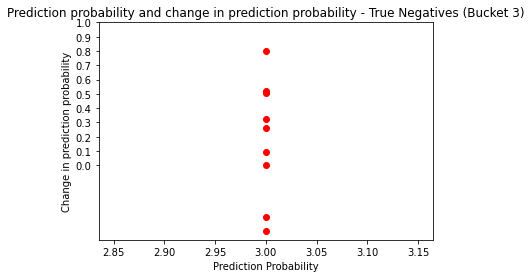

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 5
Creating distribution for feature 2 of 5
Creating distribution for feature 3 of 5
Creating distribution for feature 4 of 5
Creating distribution for feature 5 of 5
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 5
Creating distribution for feature 2 of 5
Creating distribution for feature 3 of 5
Creating distribution for feature 4 of 5
Creating distribution for feature 5 of 5
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating explanations


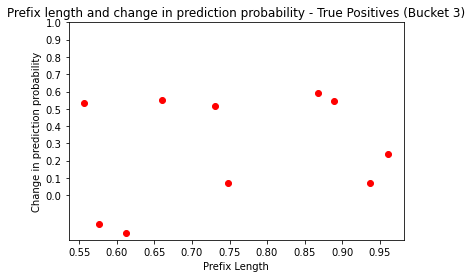

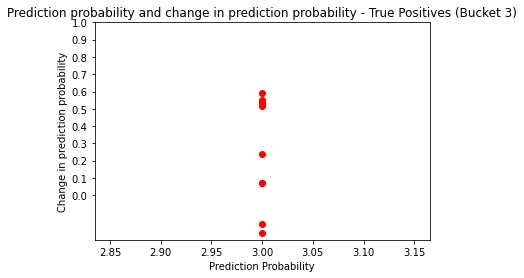

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 5
Creating distribution for feature 2 of 5
Creating distribution for feature 3 of 5
Creating distribution for feature 4 of 5
Creating distribution for feature 5 of 5
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 5
Creating distribution for feature 2 of 5
Creating distribution for feature 3 of 5
Creating distribution for feature 4 of 5
Creating distribution for feature 5 of 5
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating explanations


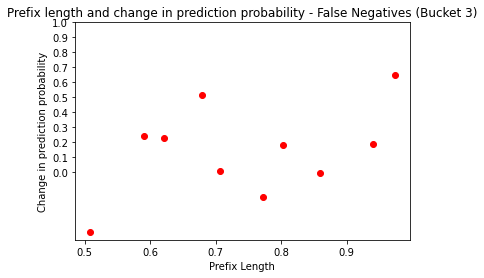

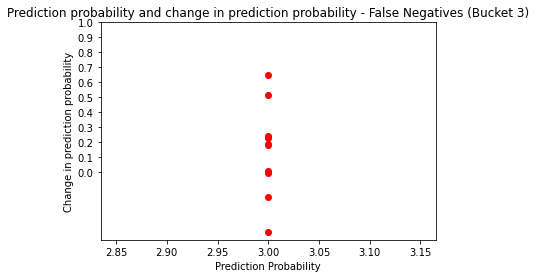

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 5
Creating distribution for feature 2 of 5
Creating distribution for feature 3 of 5
Creating distribution for feature 4 of 5
Creating distribution for feature 5 of 5
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 5
Creating distribution for feature 2 of 5
Creating distribution for feature 3 of 5
Creating distribution for feature 4 of 5
Creating distribution for feature 5 of 5
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating explanations


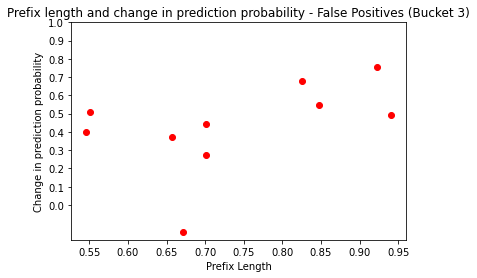

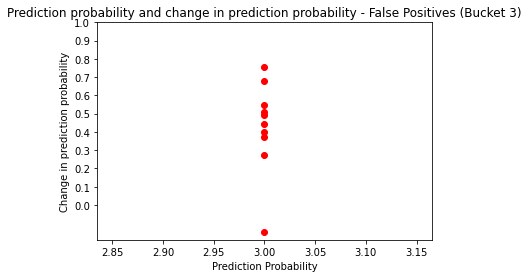

Bucket 4
Generating distributions for bucket
1 of 90 features
2 of 90 features
3 of 90 features
4 of 90 features
5 of 90 features
6 of 90 features
7 of 90 features
8 of 90 features
9 of 90 features
10 of 90 features
11 of 90 features
12 of 90 features
13 of 90 features
14 of 90 features
15 of 90 features
16 of 90 features
17 of 90 features
18 of 90 features
19 of 90 features
20 of 90 features
21 of 90 features
22 of 90 features
23 of 90 features
24 of 90 features
25 of 90 features
26 of 90 features
27 of 90 features
28 of 90 features
29 of 90 features
30 of 90 features
31 of 90 features
32 of 90 features
33 of 90 features
34 of 90 features
35 of 90 features
36 of 90 features
37 of 90 features
38 of 90 features
39 of 90 features
40 of 90 features
41 of 90 features
42 of 90 features
43 of 90 features
44 of 90 features
45 of 90 features
46 of 90 features
47 of 90 features
48 of 90 features
49 of 90 features
50 of 90 features
51 of 90 features
52 of 90 features
53 of 90 features
54 of 90 f

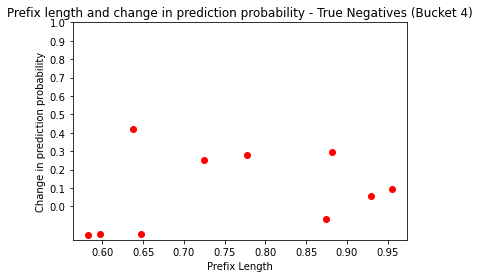

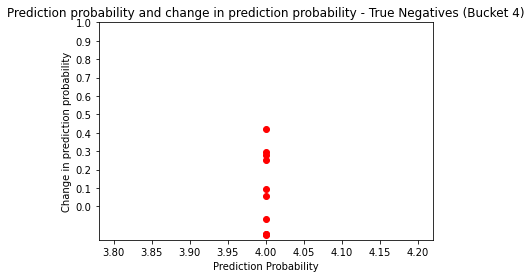

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 9
Creating distribution for feature 2 of 9
Creating distribution for feature 3 of 9
Creating distribution for feature 4 of 9
Creating distribution for feature 5 of 9
Creating distribution for feature 6 of 9
Creating distribution for feature 7 of 9
Creating distribution for feature 8 of 9
Creating distribution for feature 9 of 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 9
Creating distribution for feature 2 of 9
Creating distribution for feature 3 of 9
Creating distribution for feature 4 of 9
Creating distribution for feature 5 of 9
Creating distribution for feature 6 of 9
Creating distribution for featur

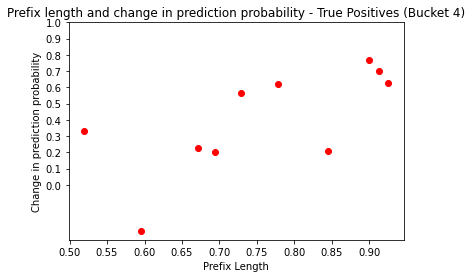

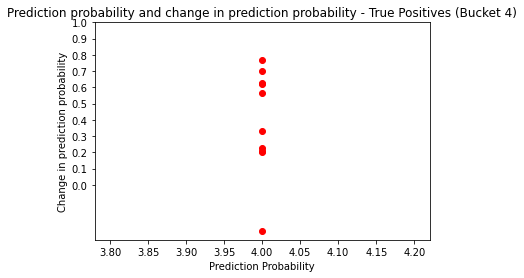

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 9
Creating distribution for feature 2 of 9
Creating distribution for feature 3 of 9
Creating distribution for feature 4 of 9
Creating distribution for feature 5 of 9
Creating distribution for feature 6 of 9
Creating distribution for feature 7 of 9
Creating distribution for feature 8 of 9
Creating distribution for feature 9 of 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 9
Creating distribution for feature 2 of 9
Creating distribution for feature 3 of 9
Creating distribution for feature 4 of 9
Creating distribution for feature 5 of 9
Creating distribution for feature 6 of 9
Creating distribution for featur

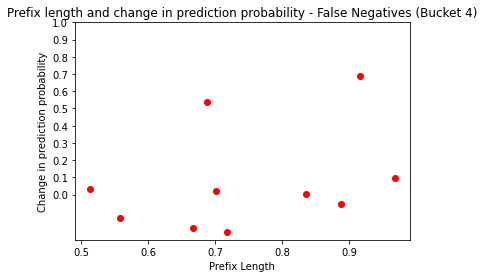

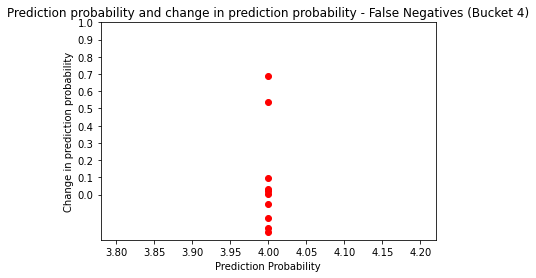

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 9
Creating distribution for feature 2 of 9
Creating distribution for feature 3 of 9
Creating distribution for feature 4 of 9
Creating distribution for feature 5 of 9
Creating distribution for feature 6 of 9
Creating distribution for feature 7 of 9
Creating distribution for feature 8 of 9
Creating distribution for feature 9 of 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 9
Creating distribution for feature 2 of 9
Creating distribution for feature 3 of 9
Creating distribution for feature 4 of 9
Creating distribution for feature 5 of 9
Creating distribution for feature 6 of 9
Creating distribution for featur

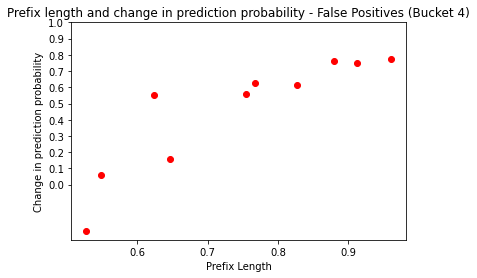

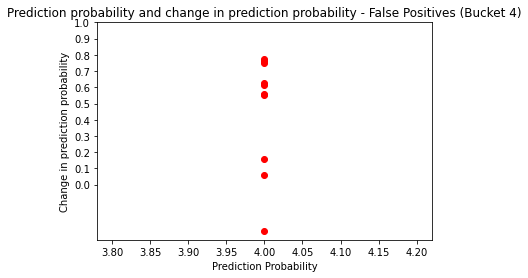

Bucket 5
Generating distributions for bucket
1 of 104 features
2 of 104 features
3 of 104 features
4 of 104 features
5 of 104 features
6 of 104 features
7 of 104 features
8 of 104 features
9 of 104 features
10 of 104 features
11 of 104 features
12 of 104 features
13 of 104 features
14 of 104 features
15 of 104 features
16 of 104 features
17 of 104 features
18 of 104 features
19 of 104 features
20 of 104 features
21 of 104 features
22 of 104 features
23 of 104 features
24 of 104 features
25 of 104 features
26 of 104 features
27 of 104 features
28 of 104 features
29 of 104 features
30 of 104 features
31 of 104 features
32 of 104 features
33 of 104 features
34 of 104 features
35 of 104 features
36 of 104 features
37 of 104 features
38 of 104 features
39 of 104 features
40 of 104 features
41 of 104 features
42 of 104 features
43 of 104 features
44 of 104 features
45 of 104 features
46 of 104 features
47 of 104 features
48 of 104 features
49 of 104 features
50 of 104 features
51 of 104 feat

Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for feature 10 of 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


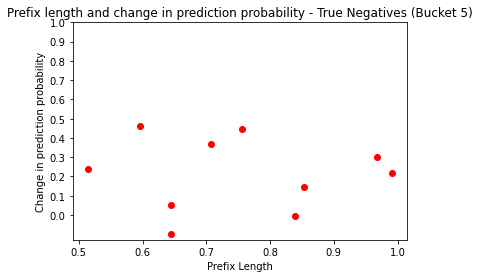

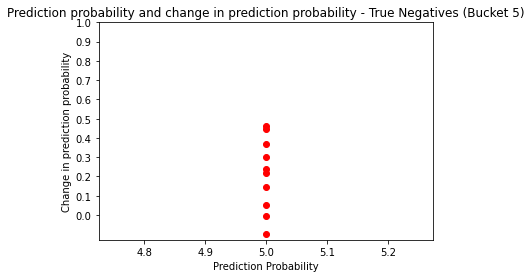

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for feature 10 of 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distrib

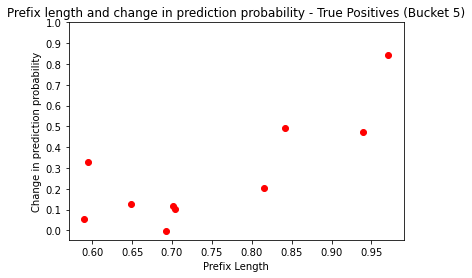

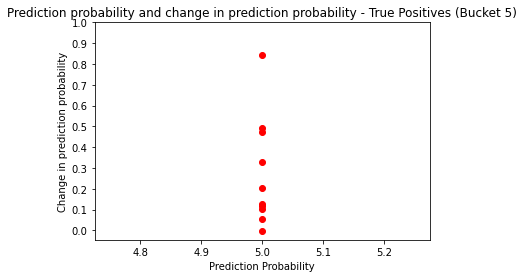

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for feature 10 of 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distrib

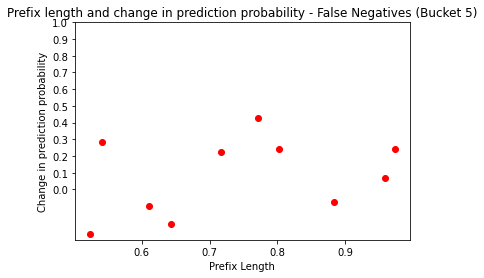

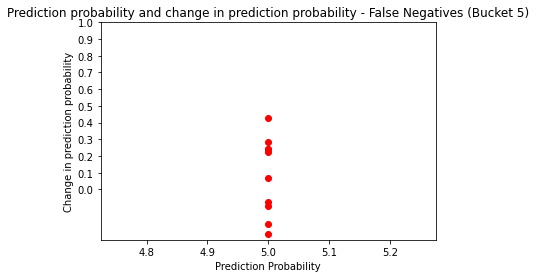

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distribution for feature 6 of 10
Creating distribution for feature 7 of 10
Creating distribution for feature 8 of 10
Creating distribution for feature 9 of 10
Creating distribution for feature 10 of 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 10
Creating distribution for feature 2 of 10
Creating distribution for feature 3 of 10
Creating distribution for feature 4 of 10
Creating distribution for feature 5 of 10
Creating distrib

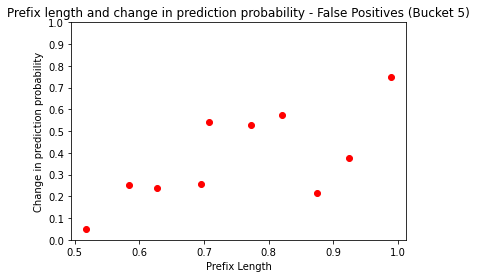

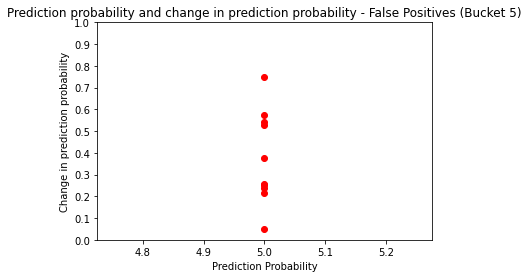

Bucket 6
Generating distributions for bucket
1 of 106 features
2 of 106 features
3 of 106 features
4 of 106 features
5 of 106 features
6 of 106 features
7 of 106 features
8 of 106 features
9 of 106 features
10 of 106 features
11 of 106 features
12 of 106 features
13 of 106 features
14 of 106 features
15 of 106 features
16 of 106 features
17 of 106 features
18 of 106 features
19 of 106 features
20 of 106 features
21 of 106 features
22 of 106 features
23 of 106 features
24 of 106 features
25 of 106 features
26 of 106 features
27 of 106 features
28 of 106 features
29 of 106 features
30 of 106 features
31 of 106 features
32 of 106 features
33 of 106 features
34 of 106 features
35 of 106 features
36 of 106 features
37 of 106 features
38 of 106 features
39 of 106 features
40 of 106 features
41 of 106 features
42 of 106 features
43 of 106 features
44 of 106 features
45 of 106 features
46 of 106 features
47 of 106 features
48 of 106 features
49 of 106 features
50 of 106 features
51 of 106 feat

Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


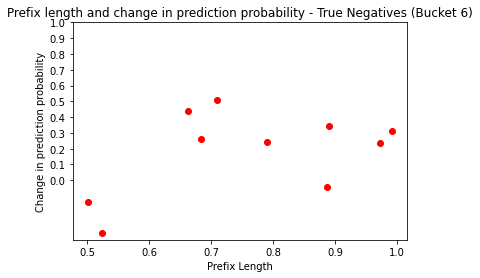

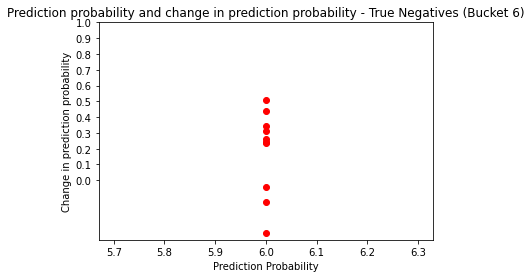

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

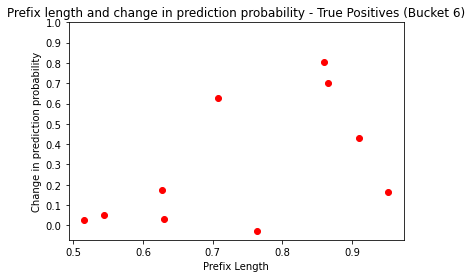

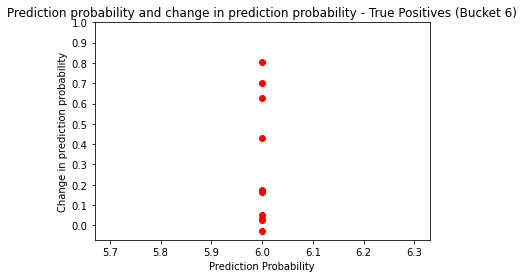

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

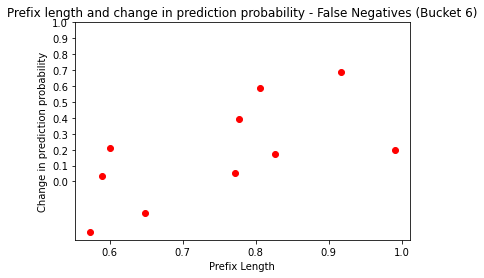

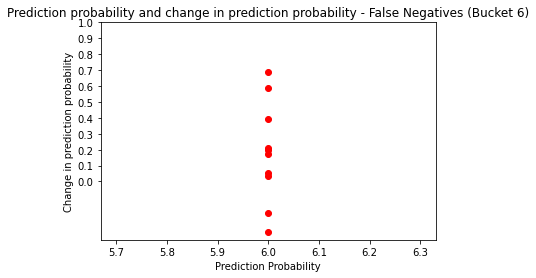

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

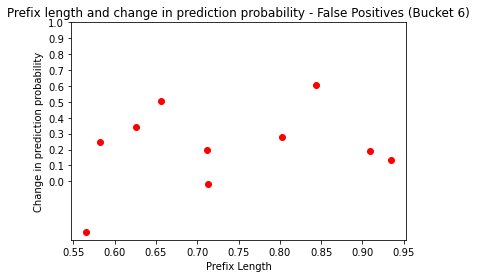

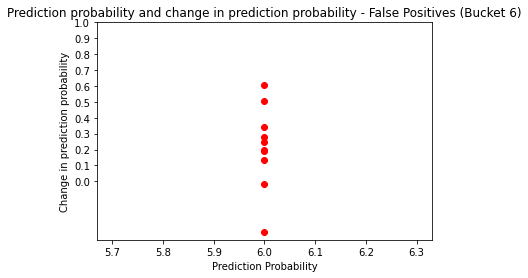

Bucket 7
Generating distributions for bucket
1 of 108 features
2 of 108 features
3 of 108 features
4 of 108 features
5 of 108 features
6 of 108 features
7 of 108 features
8 of 108 features
9 of 108 features
10 of 108 features
11 of 108 features
12 of 108 features
13 of 108 features
14 of 108 features
15 of 108 features
16 of 108 features
17 of 108 features
18 of 108 features
19 of 108 features
20 of 108 features
21 of 108 features
22 of 108 features
23 of 108 features
24 of 108 features
25 of 108 features
26 of 108 features
27 of 108 features
28 of 108 features
29 of 108 features
30 of 108 features
31 of 108 features
32 of 108 features
33 of 108 features
34 of 108 features
35 of 108 features
36 of 108 features
37 of 108 features
38 of 108 features
39 of 108 features
40 of 108 features
41 of 108 features
42 of 108 features
43 of 108 features
44 of 108 features
45 of 108 features
46 of 108 features
47 of 108 features
48 of 108 features
49 of 108 features
50 of 108 features
51 of 108 feat

Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


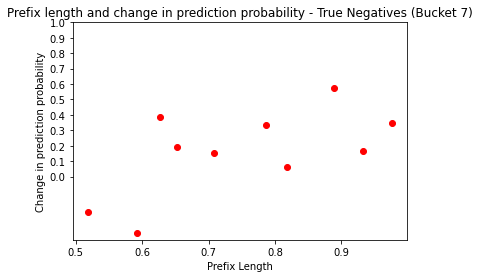

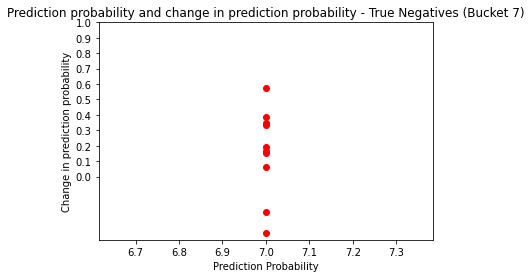

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

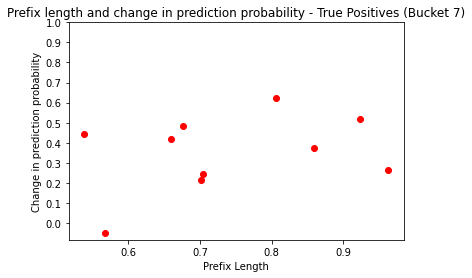

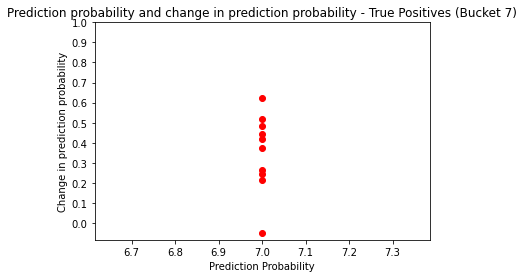

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

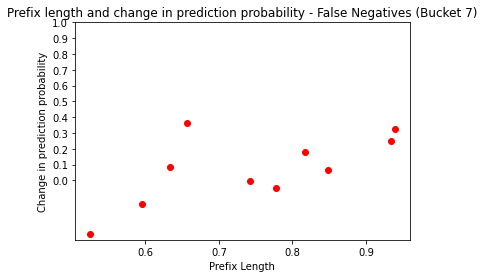

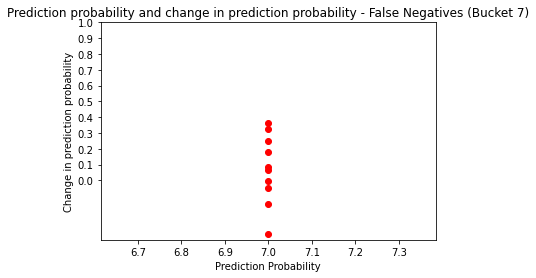

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

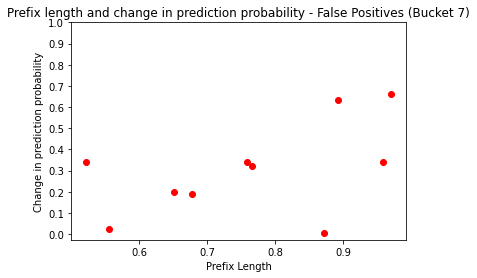

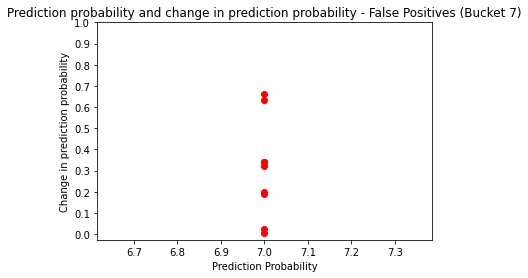

Bucket 8
Generating distributions for bucket
1 of 108 features
2 of 108 features
3 of 108 features
4 of 108 features
5 of 108 features
6 of 108 features
7 of 108 features
8 of 108 features
9 of 108 features
10 of 108 features
11 of 108 features
12 of 108 features
13 of 108 features
14 of 108 features
15 of 108 features
16 of 108 features
17 of 108 features
18 of 108 features
19 of 108 features
20 of 108 features
21 of 108 features
22 of 108 features
23 of 108 features
24 of 108 features
25 of 108 features
26 of 108 features
27 of 108 features
28 of 108 features
29 of 108 features
30 of 108 features
31 of 108 features
32 of 108 features
33 of 108 features
34 of 108 features
35 of 108 features
36 of 108 features
37 of 108 features
38 of 108 features
39 of 108 features
40 of 108 features
41 of 108 features
42 of 108 features
43 of 108 features
44 of 108 features
45 of 108 features
46 of 108 features
47 of 108 features
48 of 108 features
49 of 108 features
50 of 108 features
51 of 108 feat

Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


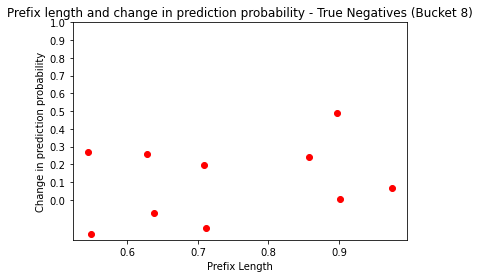

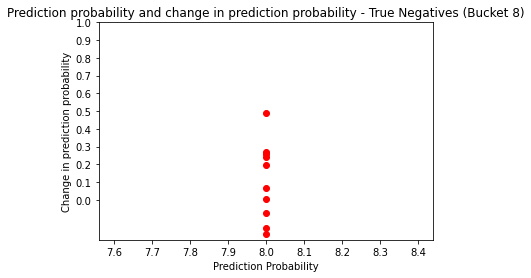

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

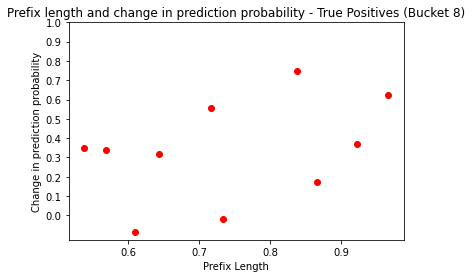

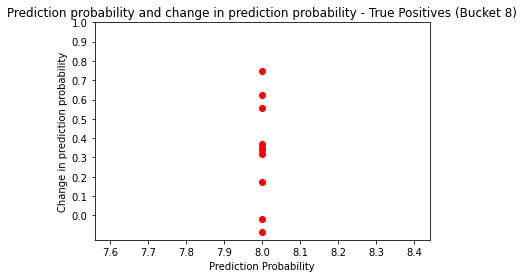

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

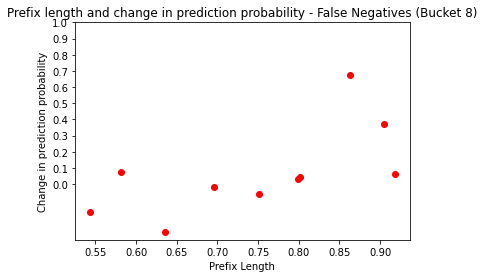

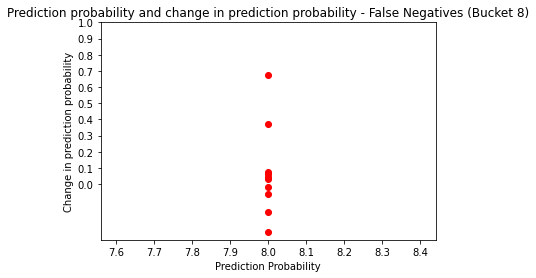

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

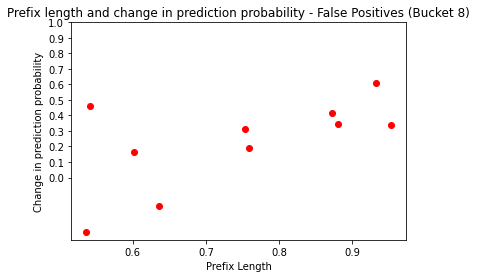

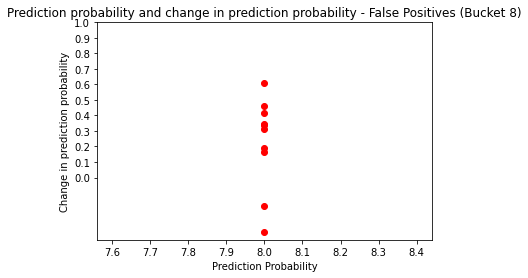

Bucket 9
Generating distributions for bucket
1 of 109 features
2 of 109 features
3 of 109 features
4 of 109 features
5 of 109 features
6 of 109 features
7 of 109 features
8 of 109 features
9 of 109 features
10 of 109 features
11 of 109 features
12 of 109 features
13 of 109 features
14 of 109 features
15 of 109 features
16 of 109 features
17 of 109 features
18 of 109 features
19 of 109 features
20 of 109 features
21 of 109 features
22 of 109 features
23 of 109 features
24 of 109 features
25 of 109 features
26 of 109 features
27 of 109 features
28 of 109 features
29 of 109 features
30 of 109 features
31 of 109 features
32 of 109 features
33 of 109 features
34 of 109 features
35 of 109 features
36 of 109 features
37 of 109 features
38 of 109 features
39 of 109 features
40 of 109 features
41 of 109 features
42 of 109 features
43 of 109 features
44 of 109 features
45 of 109 features
46 of 109 features
47 of 109 features
48 of 109 features
49 of 109 features
50 of 109 features
51 of 109 feat

Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


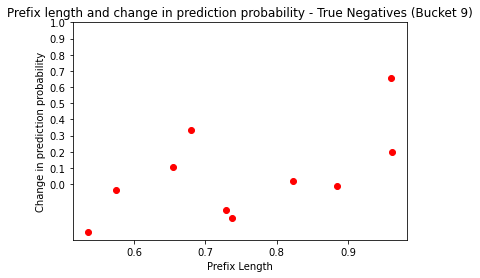

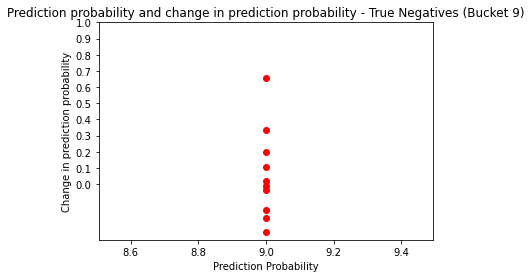

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

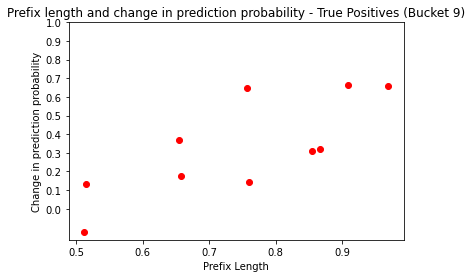

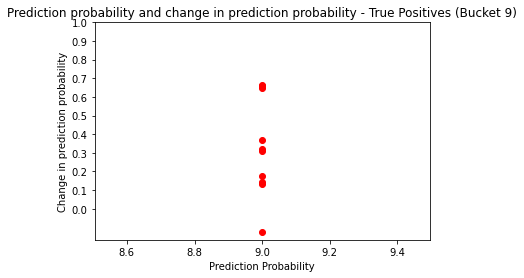

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

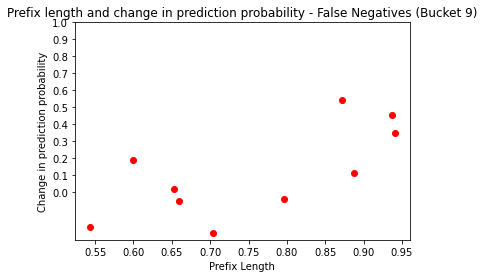

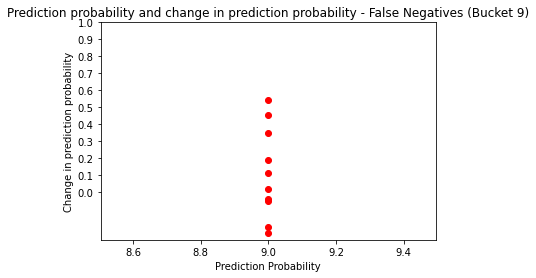

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

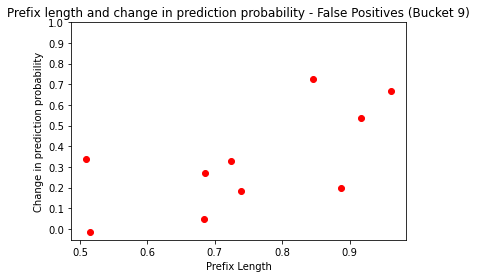

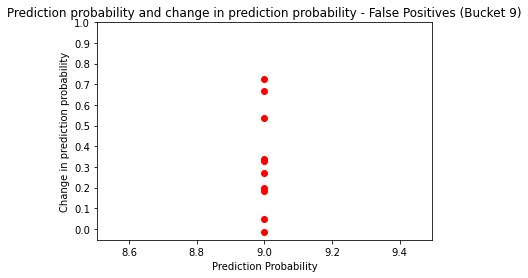

Bucket 10
Generating distributions for bucket
1 of 110 features
2 of 110 features
3 of 110 features
4 of 110 features
5 of 110 features
6 of 110 features
7 of 110 features
8 of 110 features
9 of 110 features
10 of 110 features
11 of 110 features
12 of 110 features
13 of 110 features
14 of 110 features
15 of 110 features
16 of 110 features
17 of 110 features
18 of 110 features
19 of 110 features
20 of 110 features
21 of 110 features
22 of 110 features
23 of 110 features
24 of 110 features
25 of 110 features
26 of 110 features
27 of 110 features
28 of 110 features
29 of 110 features
30 of 110 features
31 of 110 features
32 of 110 features
33 of 110 features
34 of 110 features
35 of 110 features
36 of 110 features
37 of 110 features
38 of 110 features
39 of 110 features
40 of 110 features
41 of 110 features
42 of 110 features
43 of 110 features
44 of 110 features
45 of 110 features
46 of 110 features
47 of 110 features
48 of 110 features
49 of 110 features
50 of 110 features
51 of 110 fea

Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


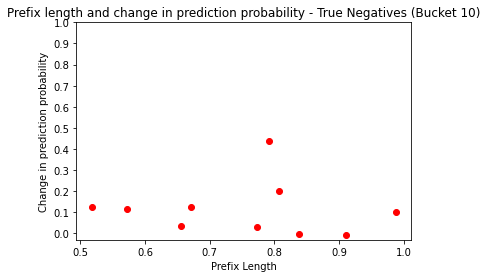

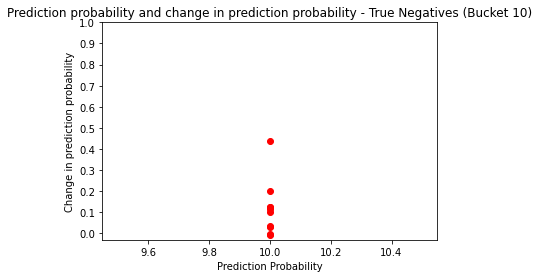

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

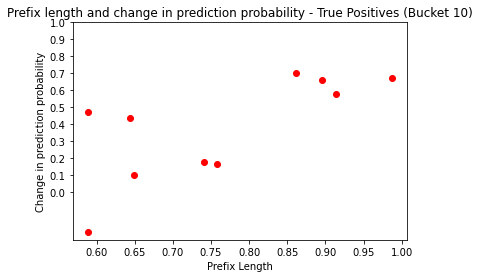

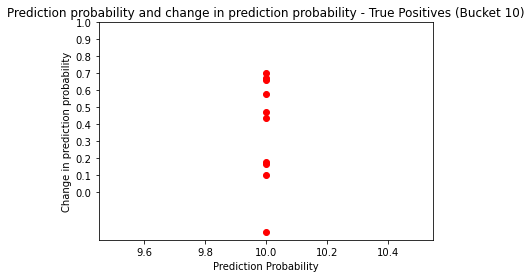

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

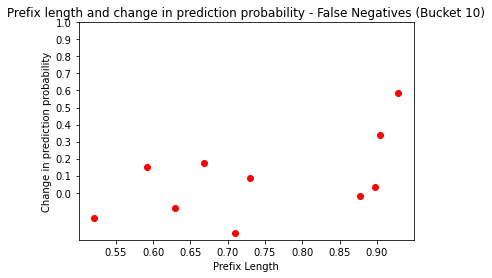

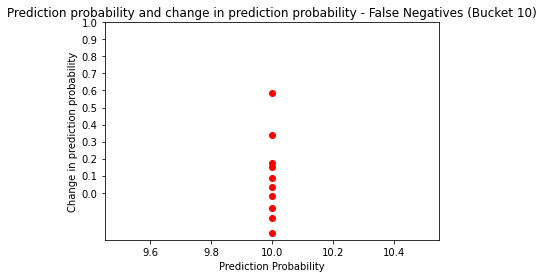

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

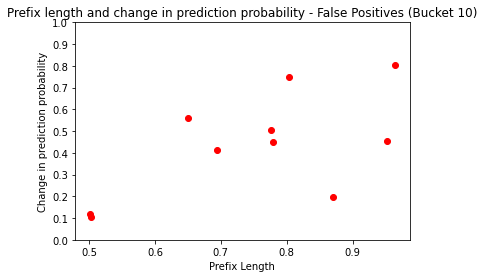

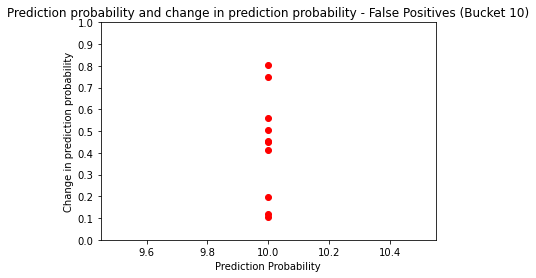

Bucket 11
Generating distributions for bucket
1 of 111 features
2 of 111 features
3 of 111 features
4 of 111 features
5 of 111 features
6 of 111 features
7 of 111 features
8 of 111 features
9 of 111 features
10 of 111 features
11 of 111 features
12 of 111 features
13 of 111 features
14 of 111 features
15 of 111 features
16 of 111 features
17 of 111 features
18 of 111 features
19 of 111 features
20 of 111 features
21 of 111 features
22 of 111 features
23 of 111 features
24 of 111 features
25 of 111 features
26 of 111 features
27 of 111 features
28 of 111 features
29 of 111 features
30 of 111 features
31 of 111 features
32 of 111 features
33 of 111 features
34 of 111 features
35 of 111 features
36 of 111 features
37 of 111 features
38 of 111 features
39 of 111 features
40 of 111 features
41 of 111 features
42 of 111 features
43 of 111 features
44 of 111 features
45 of 111 features
46 of 111 features
47 of 111 features
48 of 111 features
49 of 111 features
50 of 111 features
51 of 111 fea

Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


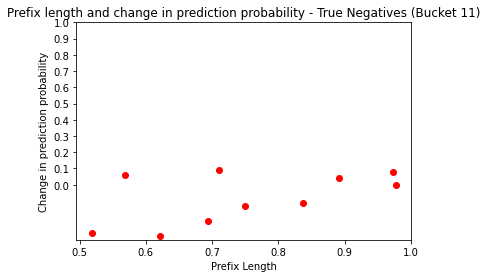

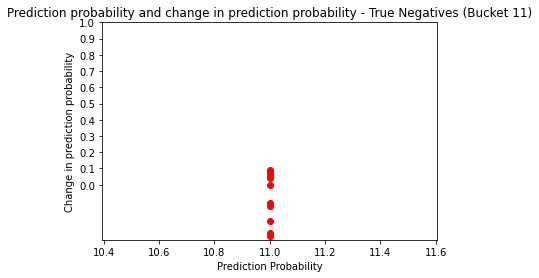

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

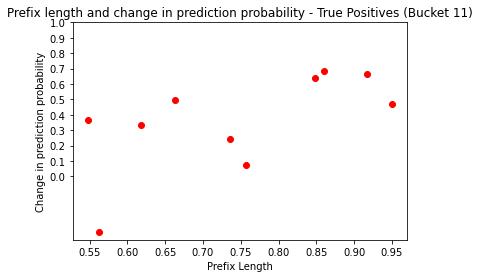

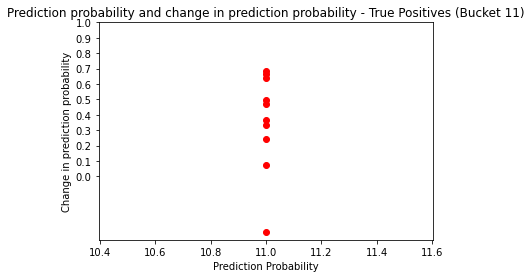

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

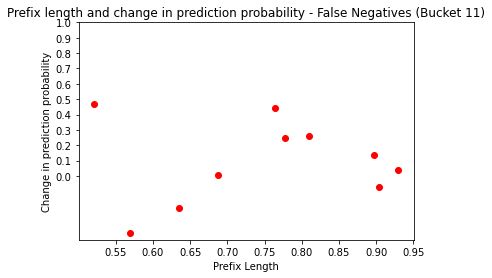

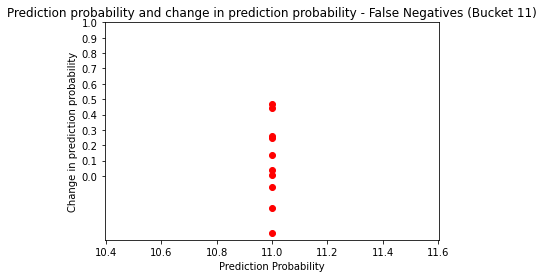

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

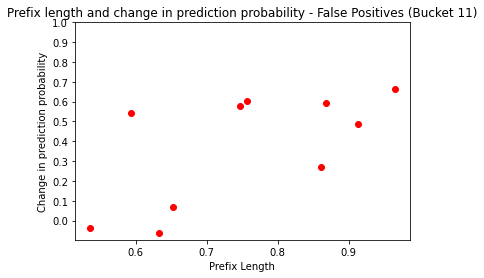

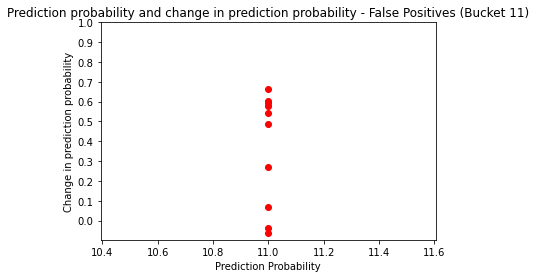

Bucket 12
Generating distributions for bucket
1 of 111 features
2 of 111 features
3 of 111 features
4 of 111 features
5 of 111 features
6 of 111 features
7 of 111 features
8 of 111 features
9 of 111 features
10 of 111 features
11 of 111 features
12 of 111 features
13 of 111 features
14 of 111 features
15 of 111 features
16 of 111 features
17 of 111 features
18 of 111 features
19 of 111 features
20 of 111 features
21 of 111 features
22 of 111 features
23 of 111 features
24 of 111 features
25 of 111 features
26 of 111 features
27 of 111 features
28 of 111 features
29 of 111 features
30 of 111 features
31 of 111 features
32 of 111 features
33 of 111 features
34 of 111 features
35 of 111 features
36 of 111 features
37 of 111 features
38 of 111 features
39 of 111 features
40 of 111 features
41 of 111 features
42 of 111 features
43 of 111 features
44 of 111 features
45 of 111 features
46 of 111 features
47 of 111 features
48 of 111 features
49 of 111 features
50 of 111 features
51 of 111 fea

Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


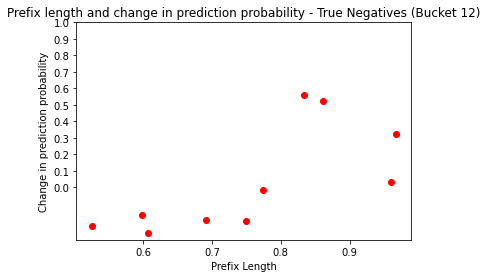

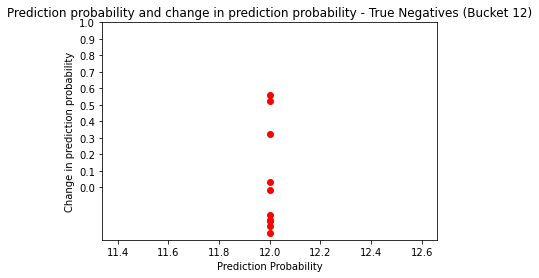

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

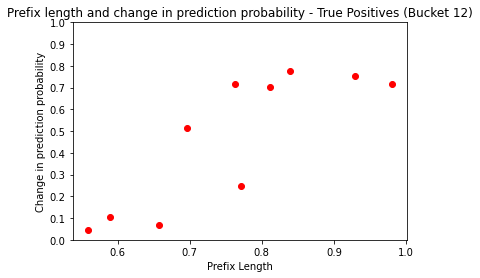

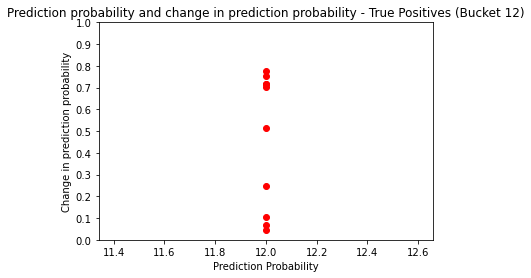

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

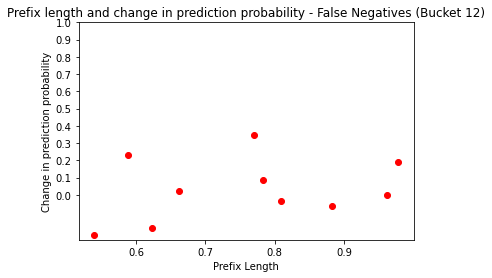

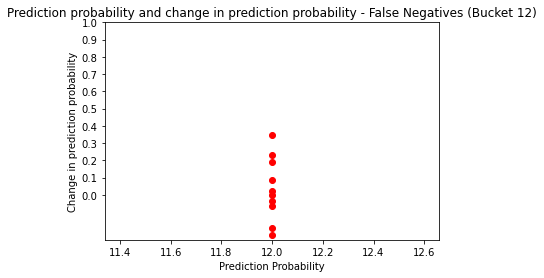

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distribution for feature 5 of 11
Creating distribution for feature 6 of 11
Creating distribution for feature 7 of 11
Creating distribution for feature 8 of 11
Creating distribution for feature 9 of 11
Creating distribution for feature 10 of 11
Creating distribution for feature 11 of 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 11
Creating distribution for feature 2 of 11
Creating distribution for feature 3 of 11
Creating distribution for feature 4 of 11
Creating distri

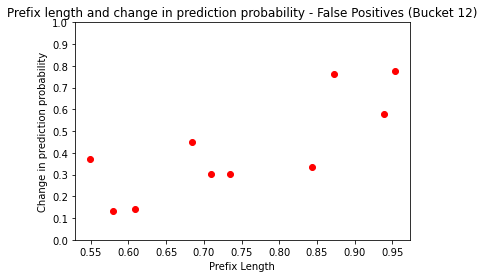

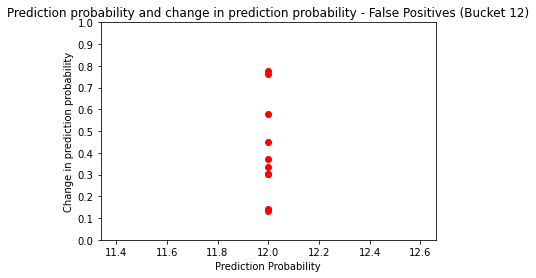

Bucket 13
Generating distributions for bucket
1 of 115 features
2 of 115 features
3 of 115 features
4 of 115 features
5 of 115 features
6 of 115 features
7 of 115 features
8 of 115 features
9 of 115 features
10 of 115 features
11 of 115 features
12 of 115 features
13 of 115 features
14 of 115 features
15 of 115 features
16 of 115 features
17 of 115 features
18 of 115 features
19 of 115 features
20 of 115 features
21 of 115 features
22 of 115 features
23 of 115 features
24 of 115 features
25 of 115 features
26 of 115 features
27 of 115 features
28 of 115 features
29 of 115 features
30 of 115 features
31 of 115 features
32 of 115 features
33 of 115 features
34 of 115 features
35 of 115 features
36 of 115 features
37 of 115 features
38 of 115 features
39 of 115 features
40 of 115 features
41 of 115 features
42 of 115 features
43 of 115 features
44 of 115 features
45 of 115 features
46 of 115 features
47 of 115 features
48 of 115 features
49 of 115 features
50 of 115 features
51 of 115 fea

Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creati

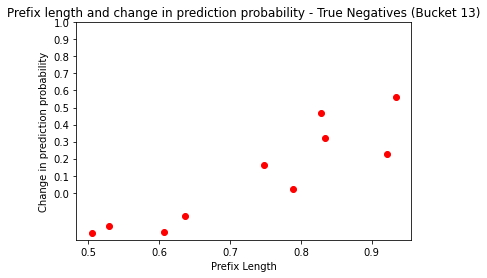

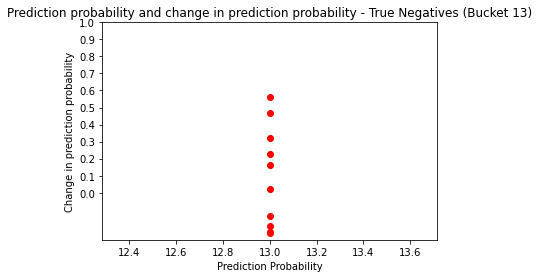

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

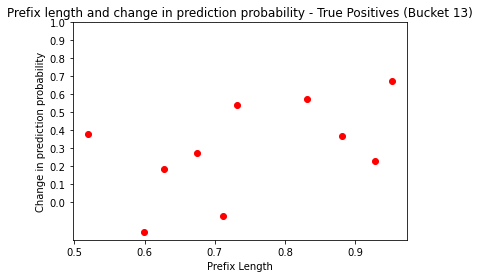

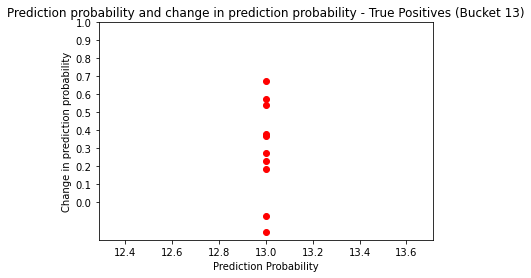

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

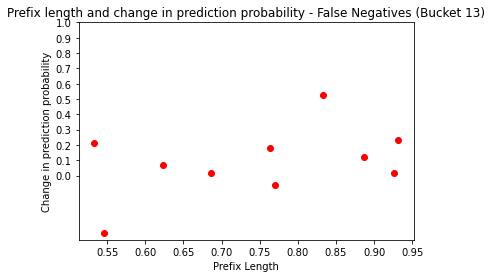

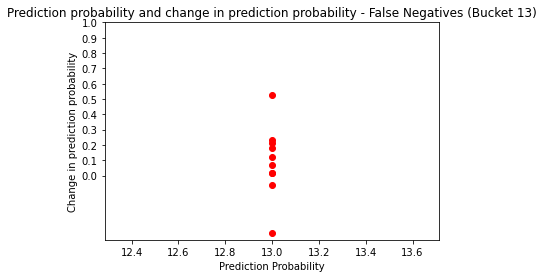

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

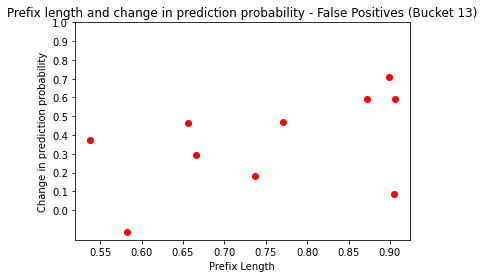

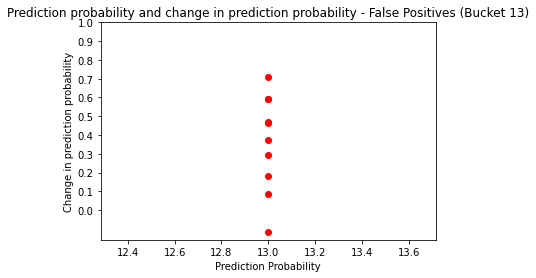

Bucket 14
Generating distributions for bucket
1 of 120 features
2 of 120 features
3 of 120 features
4 of 120 features
5 of 120 features
6 of 120 features
7 of 120 features
8 of 120 features
9 of 120 features
10 of 120 features
11 of 120 features
12 of 120 features
13 of 120 features
14 of 120 features
15 of 120 features
16 of 120 features
17 of 120 features
18 of 120 features
19 of 120 features
20 of 120 features
21 of 120 features
22 of 120 features
23 of 120 features
24 of 120 features
25 of 120 features
26 of 120 features
27 of 120 features
28 of 120 features
29 of 120 features
30 of 120 features
31 of 120 features
32 of 120 features
33 of 120 features
34 of 120 features
35 of 120 features
36 of 120 features
37 of 120 features
38 of 120 features
39 of 120 features
40 of 120 features
41 of 120 features
42 of 120 features
43 of 120 features
44 of 120 features
45 of 120 features
46 of 120 features
47 of 120 features
48 of 120 features
49 of 120 features
50 of 120 features
51 of 120 fea

Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creati

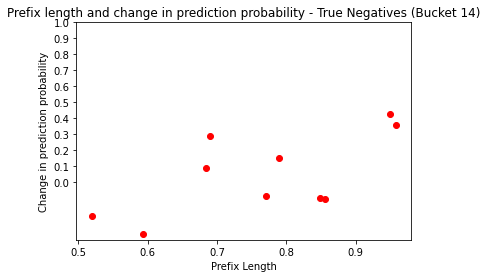

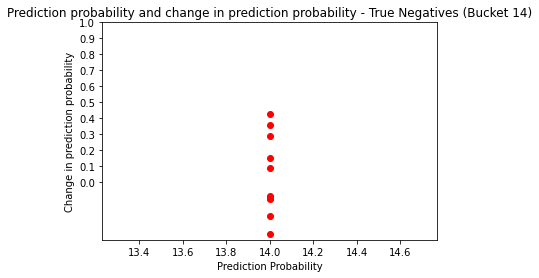

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

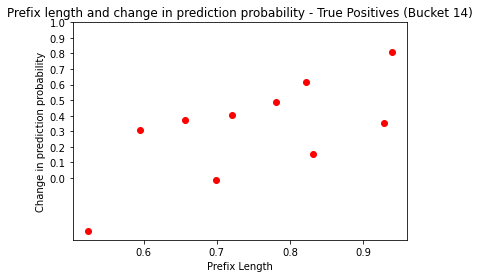

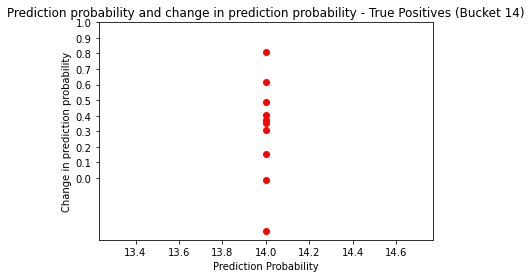

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

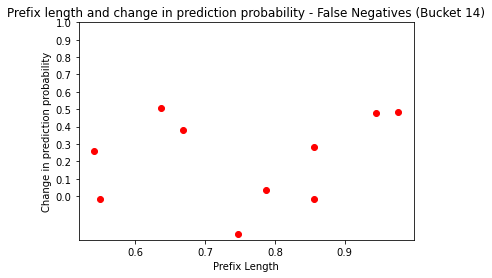

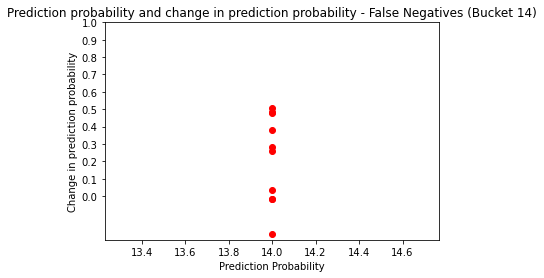

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

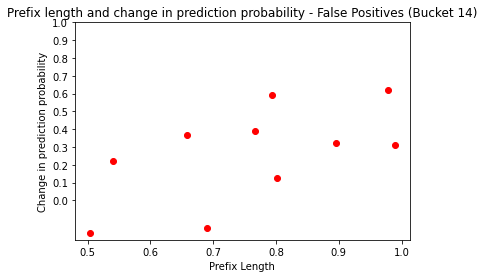

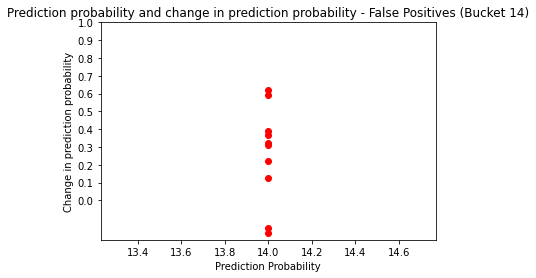

Bucket 15
Generating distributions for bucket
1 of 122 features
2 of 122 features
3 of 122 features
4 of 122 features
5 of 122 features
6 of 122 features
7 of 122 features
8 of 122 features
9 of 122 features
10 of 122 features
11 of 122 features
12 of 122 features
13 of 122 features
14 of 122 features
15 of 122 features
16 of 122 features
17 of 122 features
18 of 122 features
19 of 122 features
20 of 122 features
21 of 122 features
22 of 122 features
23 of 122 features
24 of 122 features
25 of 122 features
26 of 122 features
27 of 122 features
28 of 122 features
29 of 122 features
30 of 122 features
31 of 122 features
32 of 122 features
33 of 122 features
34 of 122 features
35 of 122 features
36 of 122 features
37 of 122 features
38 of 122 features
39 of 122 features
40 of 122 features
41 of 122 features
42 of 122 features
43 of 122 features
44 of 122 features
45 of 122 features
46 of 122 features
47 of 122 features
48 of 122 features
49 of 122 features
50 of 122 features
51 of 122 fea

Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feat

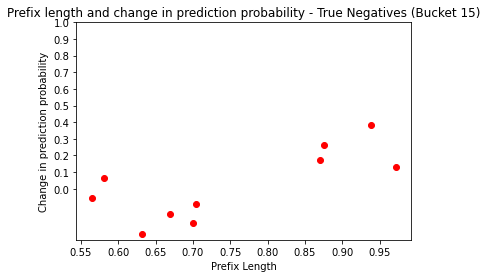

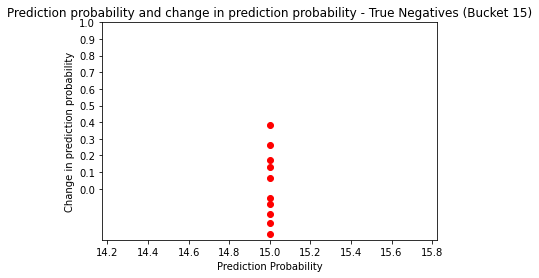

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

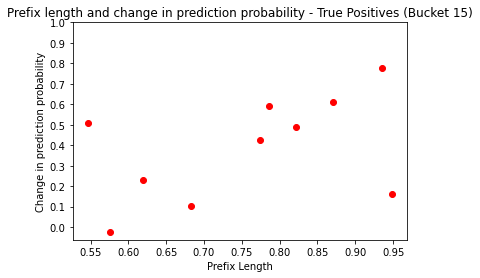

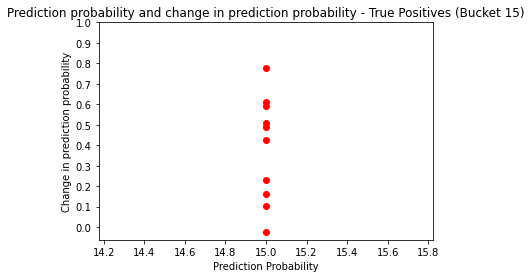

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

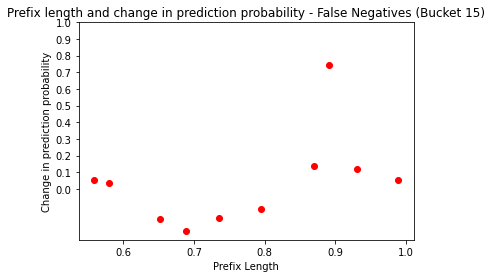

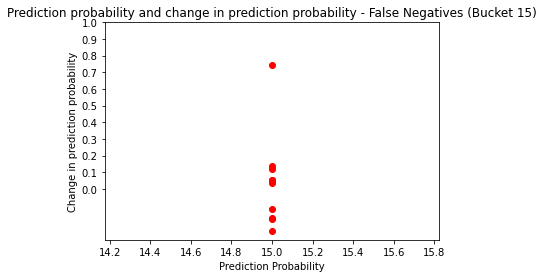

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

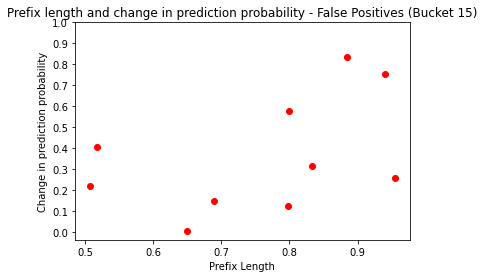

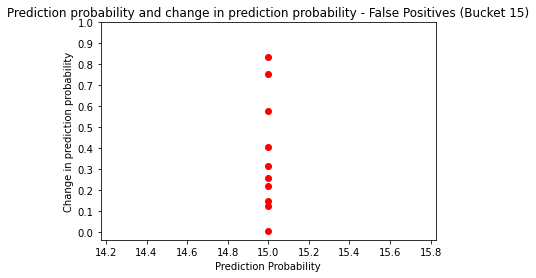

Bucket 16
Generating distributions for bucket
1 of 122 features
2 of 122 features
3 of 122 features
4 of 122 features
5 of 122 features
6 of 122 features
7 of 122 features
8 of 122 features
9 of 122 features
10 of 122 features
11 of 122 features
12 of 122 features
13 of 122 features
14 of 122 features
15 of 122 features
16 of 122 features
17 of 122 features
18 of 122 features
19 of 122 features
20 of 122 features
21 of 122 features
22 of 122 features
23 of 122 features
24 of 122 features
25 of 122 features
26 of 122 features
27 of 122 features
28 of 122 features
29 of 122 features
30 of 122 features
31 of 122 features
32 of 122 features
33 of 122 features
34 of 122 features
35 of 122 features
36 of 122 features
37 of 122 features
38 of 122 features
39 of 122 features
40 of 122 features
41 of 122 features
42 of 122 features
43 of 122 features
44 of 122 features
45 of 122 features
46 of 122 features
47 of 122 features
48 of 122 features
49 of 122 features
50 of 122 features
51 of 122 fea

Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant features
Creating distribution for feat

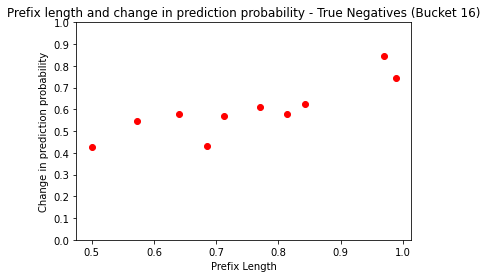

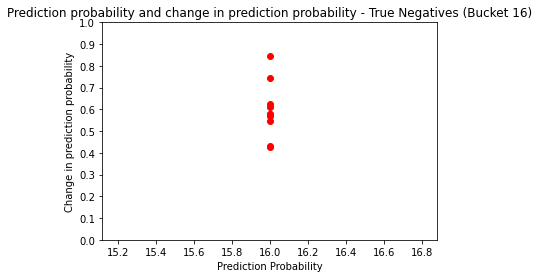

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

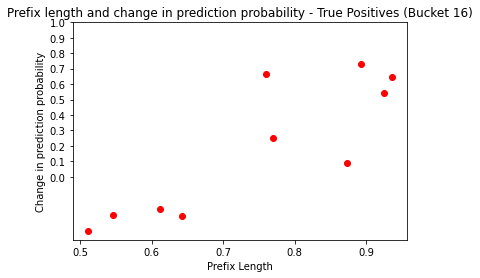

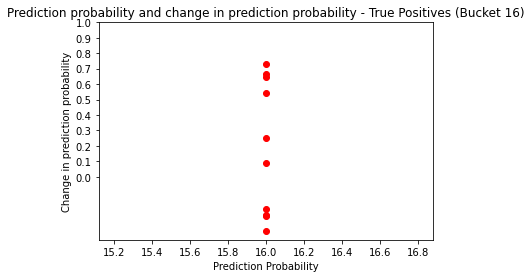

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

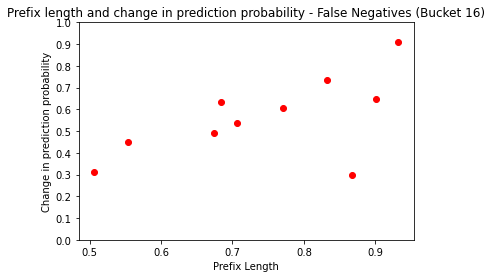

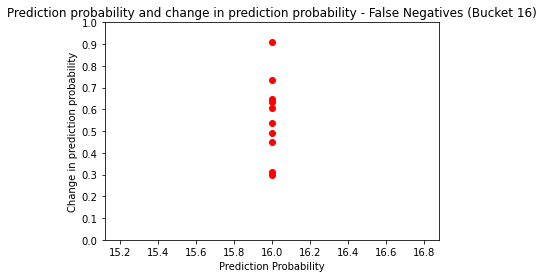

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

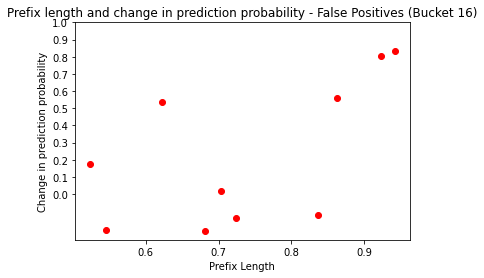

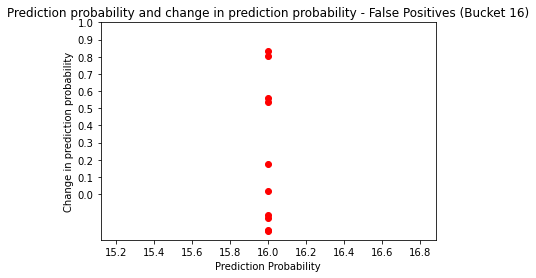

Bucket 17
Generating distributions for bucket
1 of 124 features
2 of 124 features
3 of 124 features
4 of 124 features
5 of 124 features
6 of 124 features
7 of 124 features
8 of 124 features
9 of 124 features
10 of 124 features
11 of 124 features
12 of 124 features
13 of 124 features
14 of 124 features
15 of 124 features
16 of 124 features
17 of 124 features
18 of 124 features
19 of 124 features
20 of 124 features
21 of 124 features
22 of 124 features
23 of 124 features
24 of 124 features
25 of 124 features
26 of 124 features
27 of 124 features
28 of 124 features
29 of 124 features
30 of 124 features
31 of 124 features
32 of 124 features
33 of 124 features
34 of 124 features
35 of 124 features
36 of 124 features
37 of 124 features
38 of 124 features
39 of 124 features
40 of 124 features
41 of 124 features
42 of 124 features
43 of 124 features
44 of 124 features
45 of 124 features
46 of 124 features
47 of 124 features
48 of 124 features
49 of 124 features
50 of 124 features
51 of 124 fea

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 10 of 10
Creating explanations
Identifying relevant fea

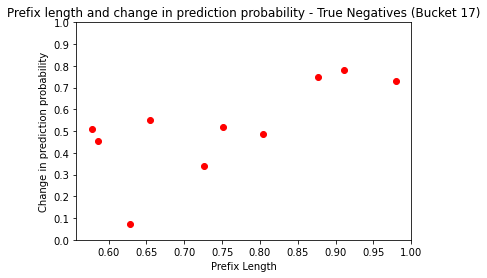

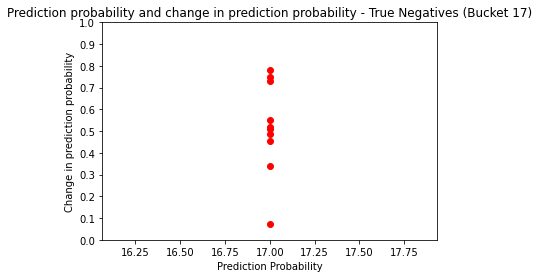

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

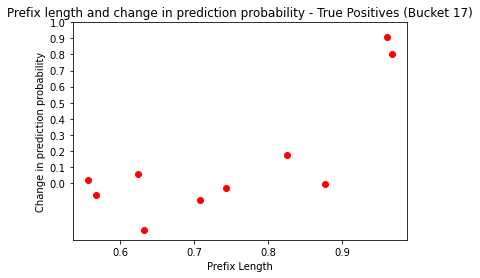

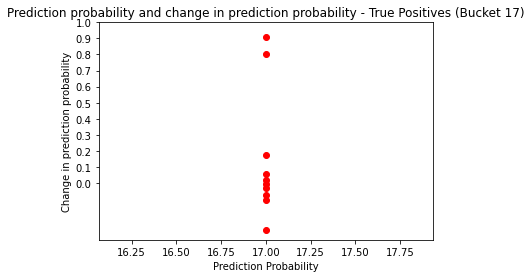

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

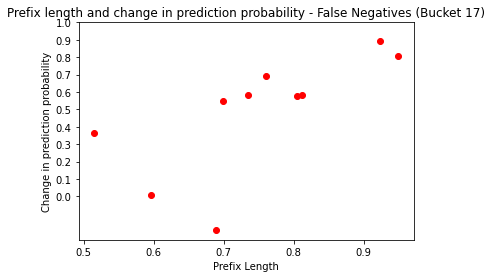

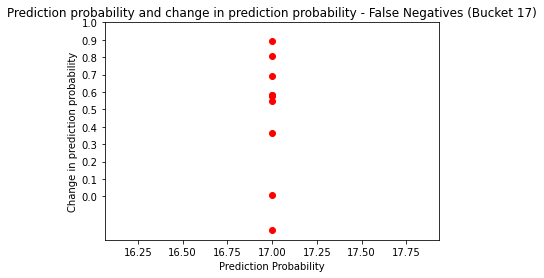

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distribution for feature 4 of 12
Creating distribution for feature 5 of 12
Creating distribution for feature 6 of 12
Creating distribution for feature 7 of 12
Creating distribution for feature 8 of 12
Creating distribution for feature 9 of 12
Creating distribution for feature 10 of 12
Creating distribution for feature 11 of 12
Creating distribution for feature 12 of 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 12
Creating distribution for feature 2 of 12
Creating distribution for feature 3 of 12
Creating distr

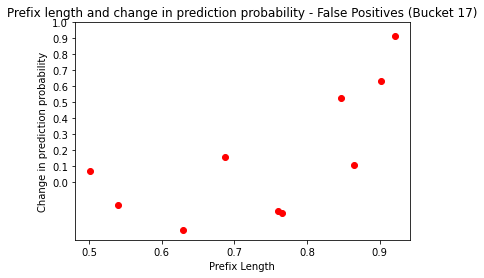

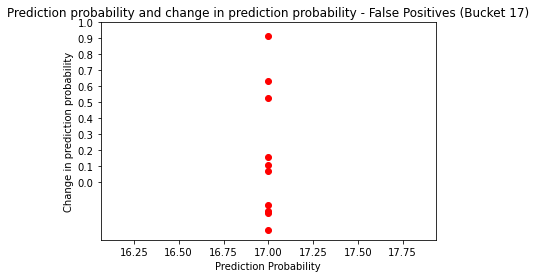

Bucket 18
Generating distributions for bucket
1 of 130 features
2 of 130 features
3 of 130 features
4 of 130 features
5 of 130 features
6 of 130 features
7 of 130 features
8 of 130 features
9 of 130 features
10 of 130 features
11 of 130 features
12 of 130 features
13 of 130 features
14 of 130 features
15 of 130 features
16 of 130 features
17 of 130 features
18 of 130 features
19 of 130 features
20 of 130 features
21 of 130 features
22 of 130 features
23 of 130 features
24 of 130 features
25 of 130 features
26 of 130 features
27 of 130 features
28 of 130 features
29 of 130 features
30 of 130 features
31 of 130 features
32 of 130 features
33 of 130 features
34 of 130 features
35 of 130 features
36 of 130 features
37 of 130 features
38 of 130 features
39 of 130 features
40 of 130 features
41 of 130 features
42 of 130 features
43 of 130 features
44 of 130 features
45 of 130 features
46 of 130 features
47 of 130 features
48 of 130 features
49 of 130 features
50 of 130 features
51 of 130 fea

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creat

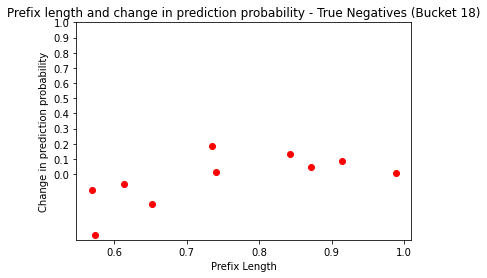

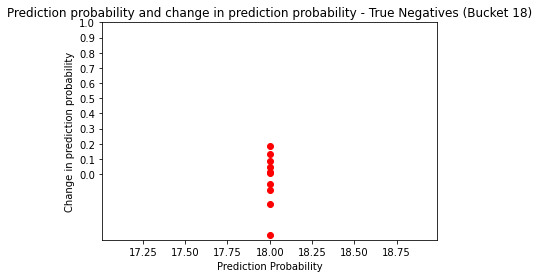

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

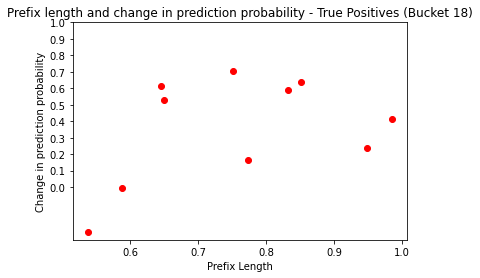

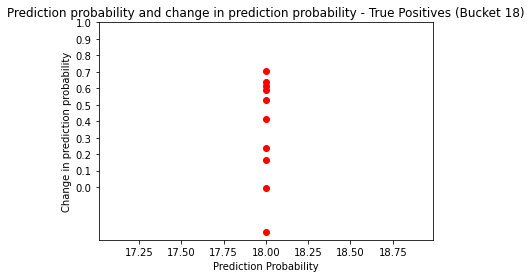

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

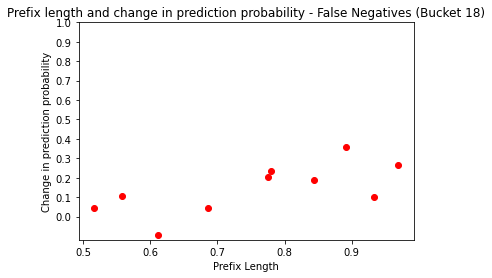

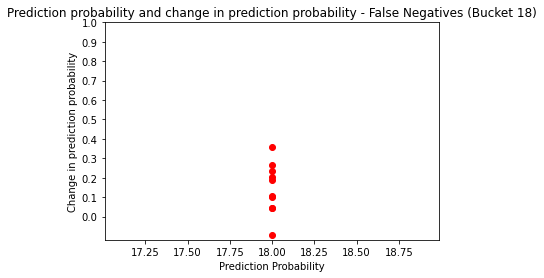

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

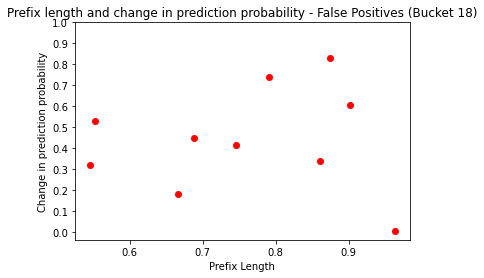

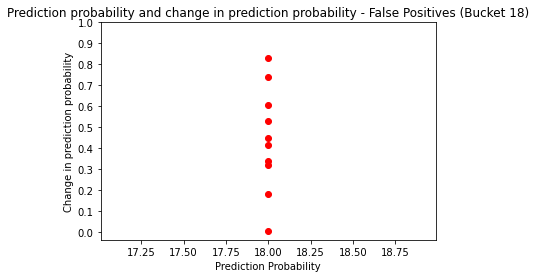

Bucket 19
Generating distributions for bucket
1 of 131 features
2 of 131 features
3 of 131 features
4 of 131 features
5 of 131 features
6 of 131 features
7 of 131 features
8 of 131 features
9 of 131 features
10 of 131 features
11 of 131 features
12 of 131 features
13 of 131 features
14 of 131 features
15 of 131 features
16 of 131 features
17 of 131 features
18 of 131 features
19 of 131 features
20 of 131 features
21 of 131 features
22 of 131 features
23 of 131 features
24 of 131 features
25 of 131 features
26 of 131 features
27 of 131 features
28 of 131 features
29 of 131 features
30 of 131 features
31 of 131 features
32 of 131 features
33 of 131 features
34 of 131 features
35 of 131 features
36 of 131 features
37 of 131 features
38 of 131 features
39 of 131 features
40 of 131 features
41 of 131 features
42 of 131 features
43 of 131 features
44 of 131 features
45 of 131 features
46 of 131 features
47 of 131 features
48 of 131 features
49 of 131 features
50 of 131 features
51 of 131 fea

Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 8 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution fo

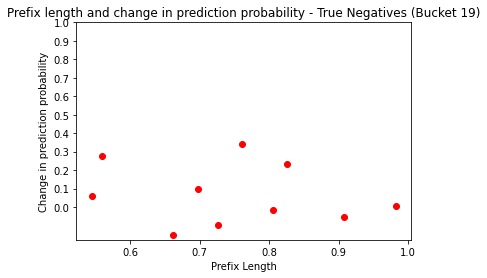

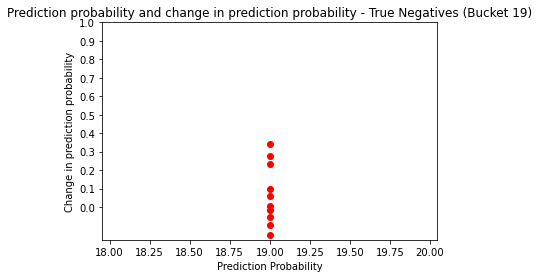

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

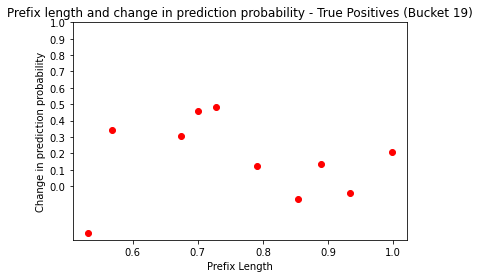

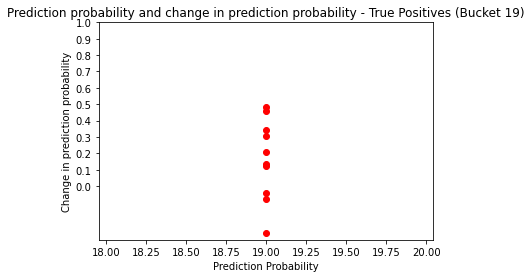

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

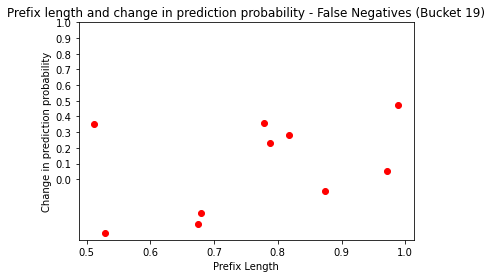

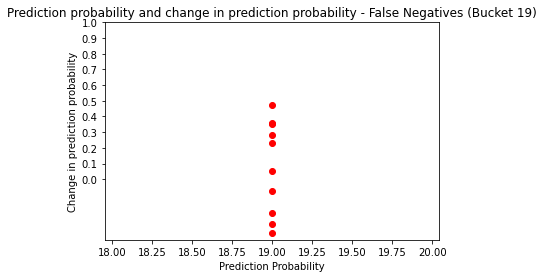

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

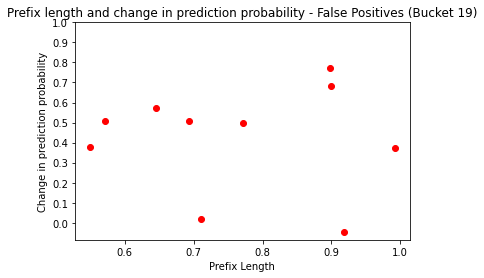

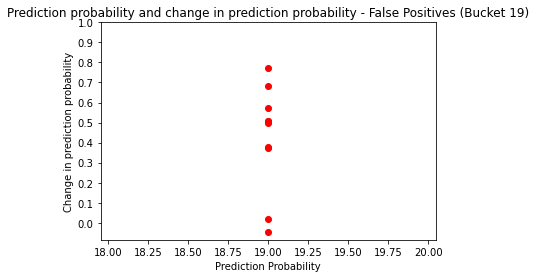

Bucket 20
Generating distributions for bucket
1 of 133 features
2 of 133 features
3 of 133 features
4 of 133 features
5 of 133 features
6 of 133 features
7 of 133 features
8 of 133 features
9 of 133 features
10 of 133 features
11 of 133 features
12 of 133 features
13 of 133 features
14 of 133 features
15 of 133 features
16 of 133 features
17 of 133 features
18 of 133 features
19 of 133 features
20 of 133 features
21 of 133 features
22 of 133 features
23 of 133 features
24 of 133 features
25 of 133 features
26 of 133 features
27 of 133 features
28 of 133 features
29 of 133 features
30 of 133 features
31 of 133 features
32 of 133 features
33 of 133 features
34 of 133 features
35 of 133 features
36 of 133 features
37 of 133 features
38 of 133 features
39 of 133 features
40 of 133 features
41 of 133 features
42 of 133 features
43 of 133 features
44 of 133 features
45 of 133 features
46 of 133 features
47 of 133 features
48 of 133 features
49 of 133 features
50 of 133 features
51 of 133 fea

Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for f

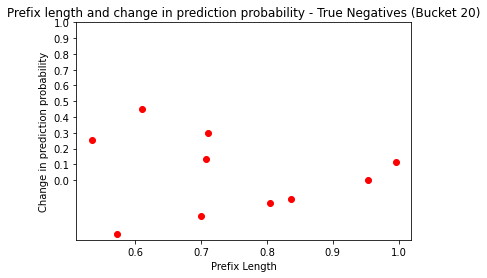

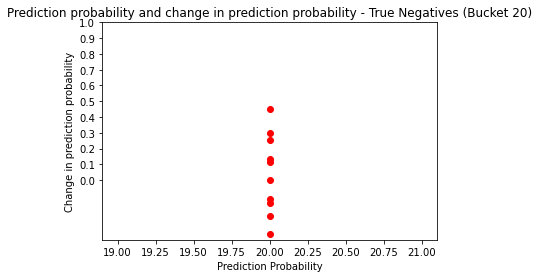

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

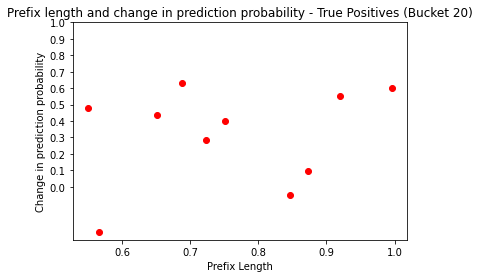

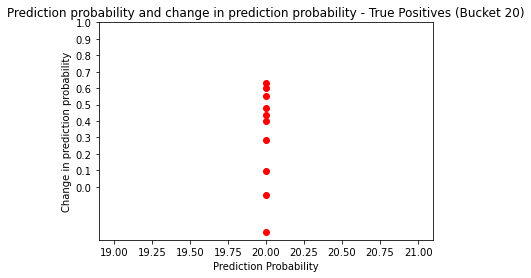

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

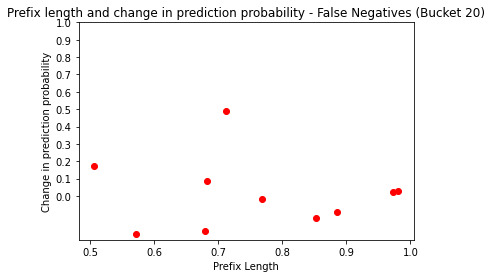

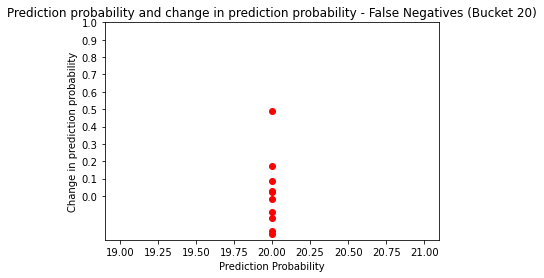

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

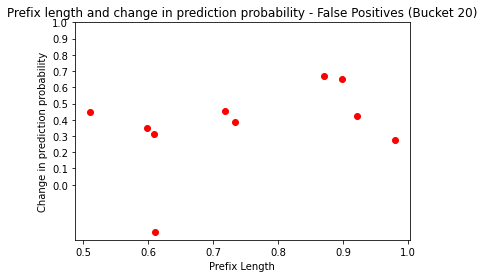

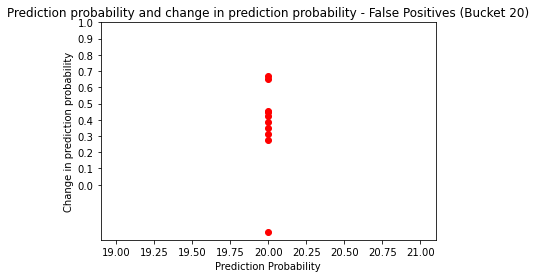

Bucket 21
Generating distributions for bucket
1 of 134 features
2 of 134 features
3 of 134 features
4 of 134 features
5 of 134 features
6 of 134 features
7 of 134 features
8 of 134 features
9 of 134 features
10 of 134 features
11 of 134 features
12 of 134 features
13 of 134 features
14 of 134 features
15 of 134 features
16 of 134 features
17 of 134 features
18 of 134 features
19 of 134 features
20 of 134 features
21 of 134 features
22 of 134 features
23 of 134 features
24 of 134 features
25 of 134 features
26 of 134 features
27 of 134 features
28 of 134 features
29 of 134 features
30 of 134 features
31 of 134 features
32 of 134 features
33 of 134 features
34 of 134 features
35 of 134 features
36 of 134 features
37 of 134 features
38 of 134 features
39 of 134 features
40 of 134 features
41 of 134 features
42 of 134 features
43 of 134 features
44 of 134 features
45 of 134 features
46 of 134 features
47 of 134 features
48 of 134 features
49 of 134 features
50 of 134 features
51 of 134 fea

Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for f

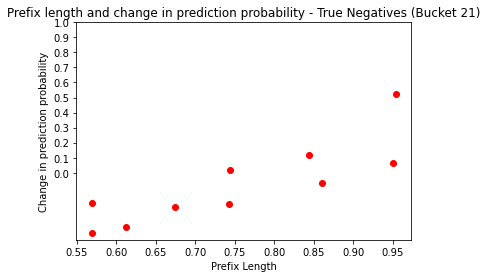

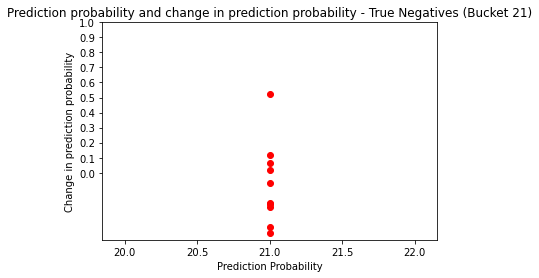

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

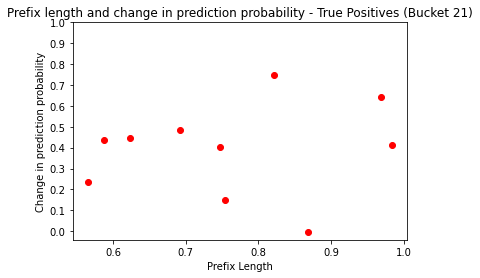

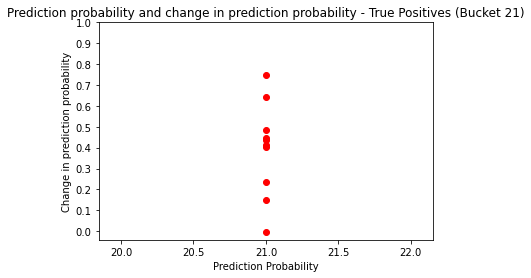

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

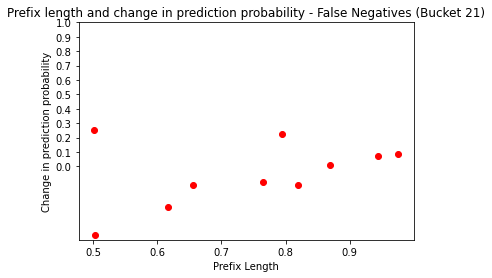

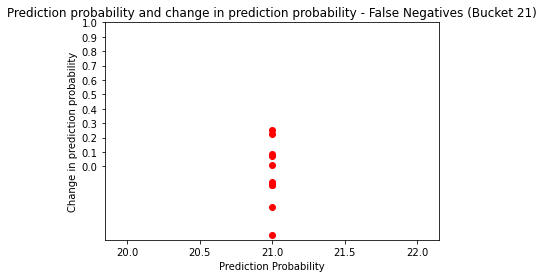

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

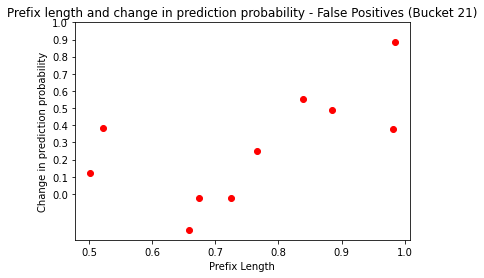

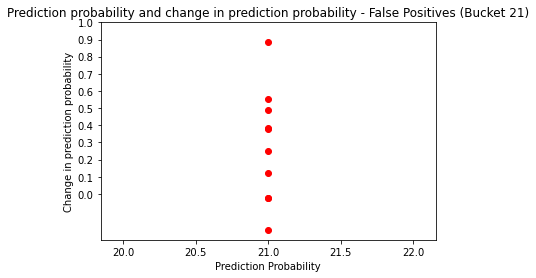

Bucket 22
Generating distributions for bucket
1 of 134 features
2 of 134 features
3 of 134 features
4 of 134 features
5 of 134 features
6 of 134 features
7 of 134 features
8 of 134 features
9 of 134 features
10 of 134 features
11 of 134 features
12 of 134 features
13 of 134 features
14 of 134 features
15 of 134 features
16 of 134 features
17 of 134 features
18 of 134 features
19 of 134 features
20 of 134 features
21 of 134 features
22 of 134 features
23 of 134 features
24 of 134 features
25 of 134 features
26 of 134 features
27 of 134 features
28 of 134 features
29 of 134 features
30 of 134 features
31 of 134 features
32 of 134 features
33 of 134 features
34 of 134 features
35 of 134 features
36 of 134 features
37 of 134 features
38 of 134 features
39 of 134 features
40 of 134 features
41 of 134 features
42 of 134 features
43 of 134 features
44 of 134 features
45 of 134 features
46 of 134 features
47 of 134 features
48 of 134 features
49 of 134 features
50 of 134 features
51 of 134 fea

Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for f

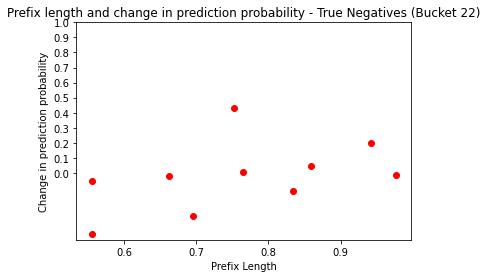

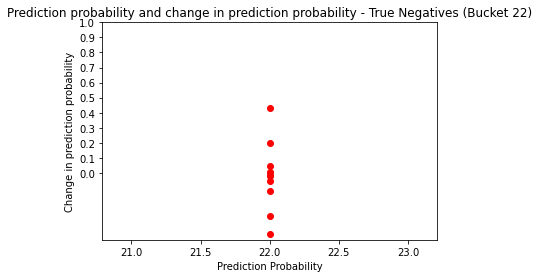

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

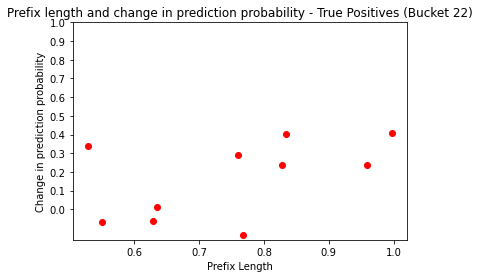

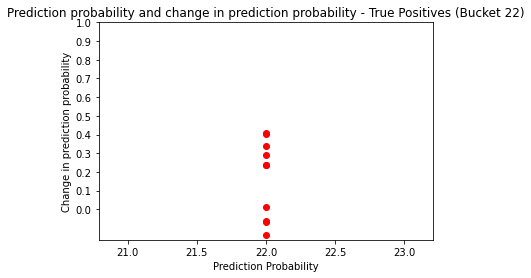

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

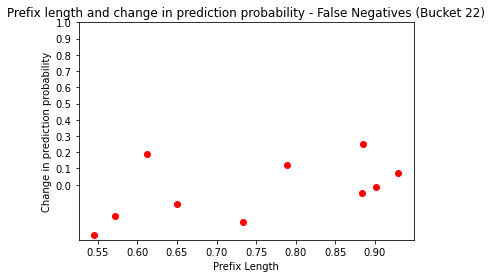

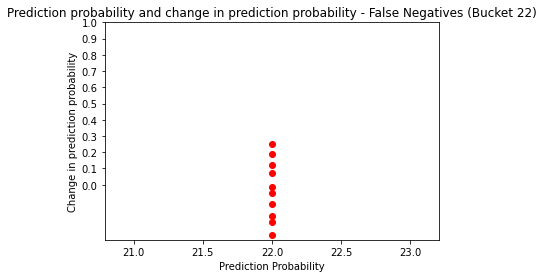

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

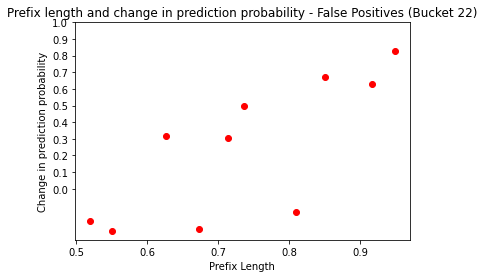

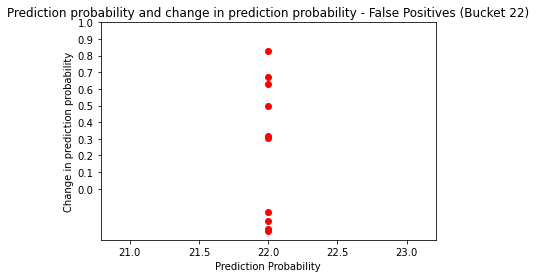

Bucket 23
Generating distributions for bucket
1 of 134 features
2 of 134 features
3 of 134 features
4 of 134 features
5 of 134 features
6 of 134 features
7 of 134 features
8 of 134 features
9 of 134 features
10 of 134 features
11 of 134 features
12 of 134 features
13 of 134 features
14 of 134 features
15 of 134 features
16 of 134 features
17 of 134 features
18 of 134 features
19 of 134 features
20 of 134 features
21 of 134 features
22 of 134 features
23 of 134 features
24 of 134 features
25 of 134 features
26 of 134 features
27 of 134 features
28 of 134 features
29 of 134 features
30 of 134 features
31 of 134 features
32 of 134 features
33 of 134 features
34 of 134 features
35 of 134 features
36 of 134 features
37 of 134 features
38 of 134 features
39 of 134 features
40 of 134 features
41 of 134 features
42 of 134 features
43 of 134 features
44 of 134 features
45 of 134 features
46 of 134 features
47 of 134 features
48 of 134 features
49 of 134 features
50 of 134 features
51 of 134 fea

Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for f

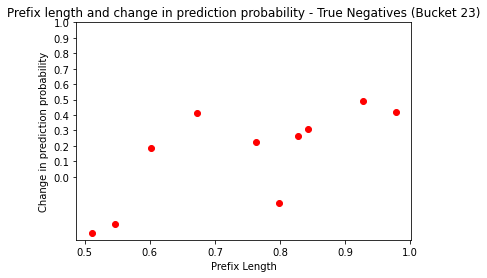

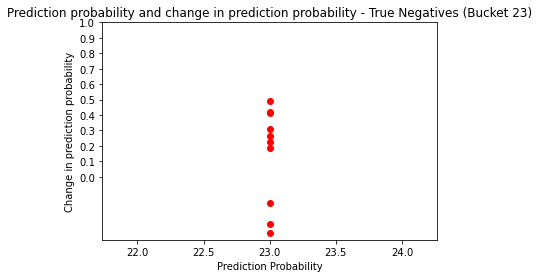

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

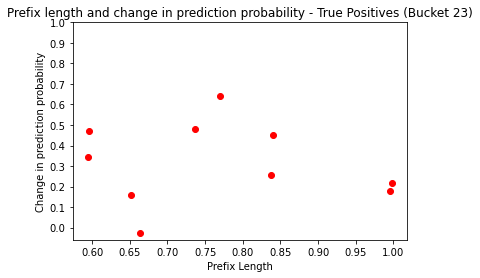

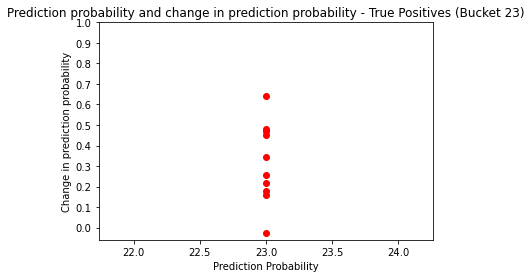

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

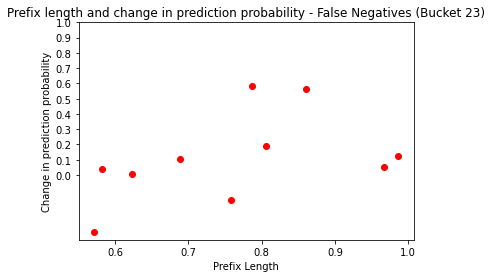

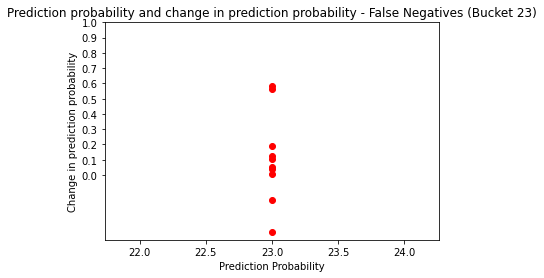

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

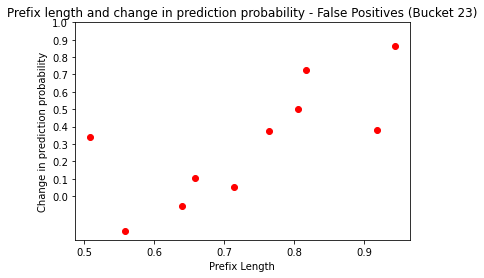

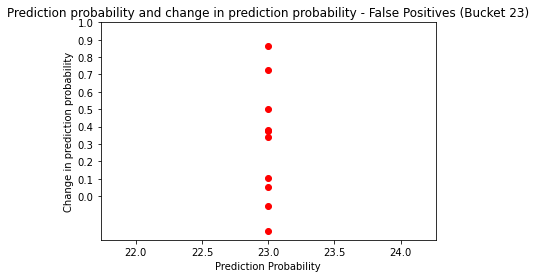

Bucket 24
Generating distributions for bucket
1 of 134 features
2 of 134 features
3 of 134 features
4 of 134 features
5 of 134 features
6 of 134 features
7 of 134 features
8 of 134 features
9 of 134 features
10 of 134 features
11 of 134 features
12 of 134 features
13 of 134 features
14 of 134 features
15 of 134 features
16 of 134 features
17 of 134 features
18 of 134 features
19 of 134 features
20 of 134 features
21 of 134 features
22 of 134 features
23 of 134 features
24 of 134 features
25 of 134 features
26 of 134 features
27 of 134 features
28 of 134 features
29 of 134 features
30 of 134 features
31 of 134 features
32 of 134 features
33 of 134 features
34 of 134 features
35 of 134 features
36 of 134 features
37 of 134 features
38 of 134 features
39 of 134 features
40 of 134 features
41 of 134 features
42 of 134 features
43 of 134 features
44 of 134 features
45 of 134 features
46 of 134 features
47 of 134 features
48 of 134 features
49 of 134 features
50 of 134 features
51 of 134 fea

Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for f

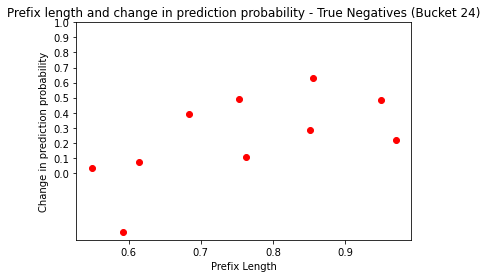

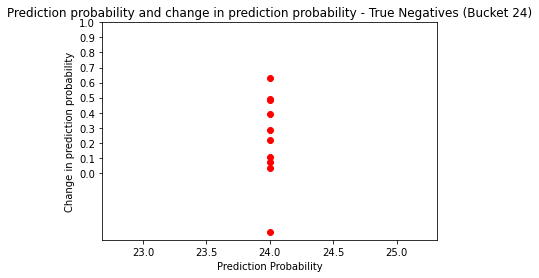

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

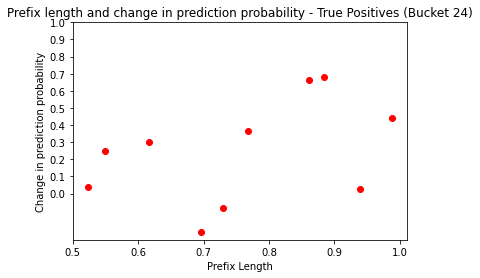

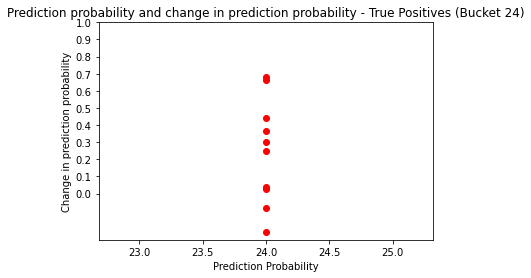

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

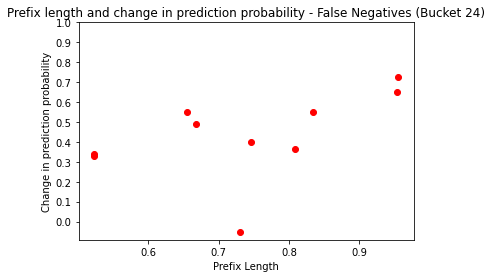

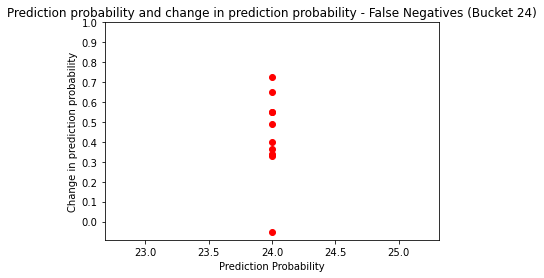

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

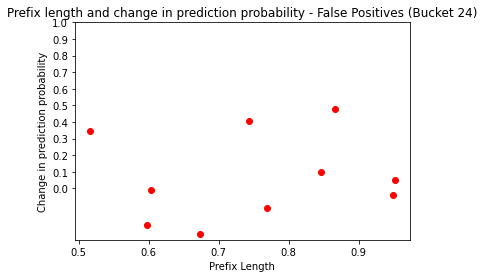

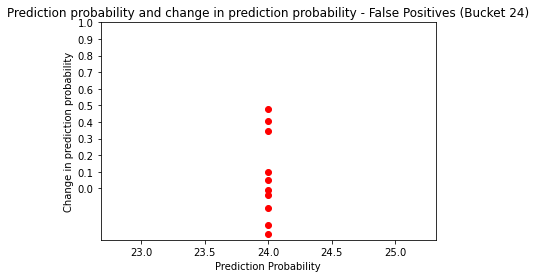

Bucket 25
Generating distributions for bucket
1 of 134 features
2 of 134 features
3 of 134 features
4 of 134 features
5 of 134 features
6 of 134 features
7 of 134 features
8 of 134 features
9 of 134 features
10 of 134 features
11 of 134 features
12 of 134 features
13 of 134 features
14 of 134 features
15 of 134 features
16 of 134 features
17 of 134 features
18 of 134 features
19 of 134 features
20 of 134 features
21 of 134 features
22 of 134 features
23 of 134 features
24 of 134 features
25 of 134 features
26 of 134 features
27 of 134 features
28 of 134 features
29 of 134 features
30 of 134 features
31 of 134 features
32 of 134 features
33 of 134 features
34 of 134 features
35 of 134 features
36 of 134 features
37 of 134 features
38 of 134 features
39 of 134 features
40 of 134 features
41 of 134 features
42 of 134 features
43 of 134 features
44 of 134 features
45 of 134 features
46 of 134 features
47 of 134 features
48 of 134 features
49 of 134 features
50 of 134 features
51 of 134 fea

Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for f

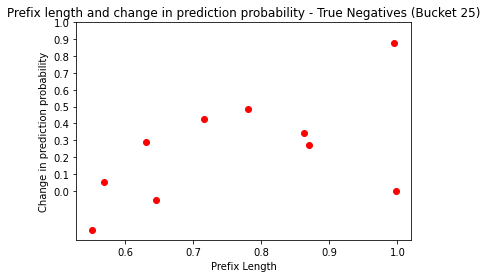

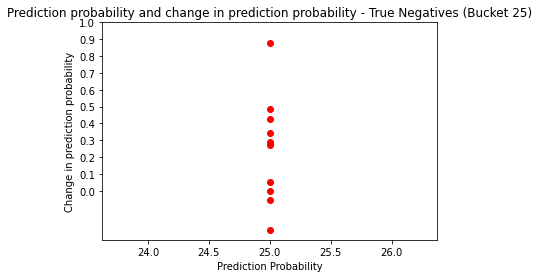

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

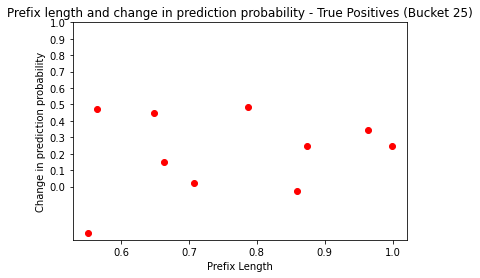

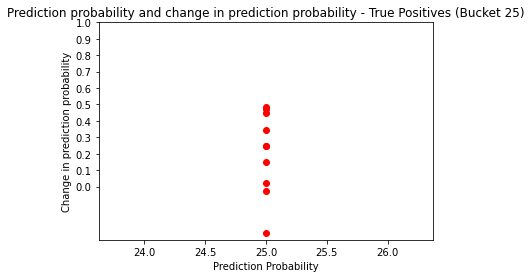

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

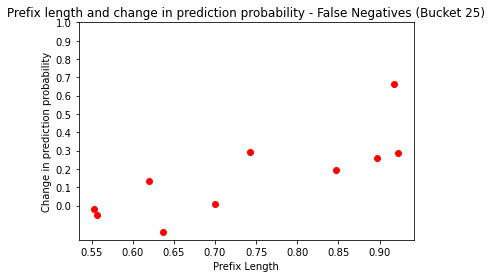

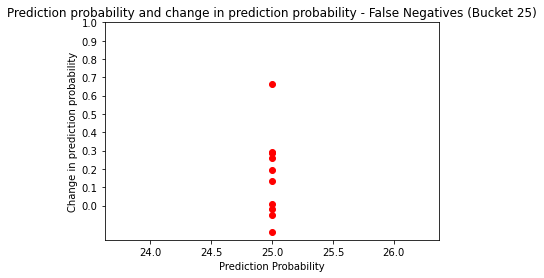

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating distribution for feature 3 of 13
Creating distribution for feature 4 of 13
Creating distribution for feature 5 of 13
Creating distribution for feature 6 of 13
Creating distribution for feature 7 of 13
Creating distribution for feature 8 of 13
Creating distribution for feature 9 of 13
Creating distribution for feature 10 of 13
Creating distribution for feature 11 of 13
Creating distribution for feature 12 of 13
Creating distribution for feature 13 of 13
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 13
Creating distribution for feature 2 of 13
Creating dist

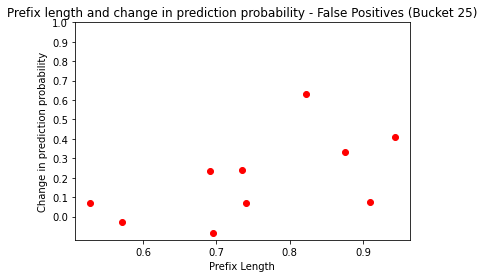

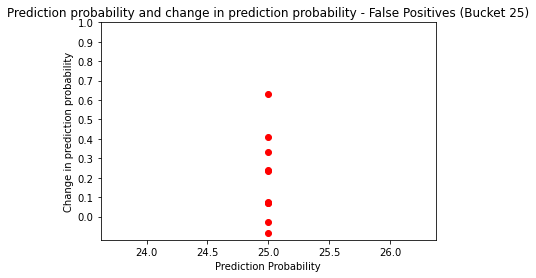

In [10]:
if generate_model_shap:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            
            buckets = range(0, max_prefix, gap)

            all_shap_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_shap_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_shap_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_test_path, 'rb') as f:
                    dt_test_bucket = pickle.load(f)
                with open (Y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)

                tree_explainer = shap.TreeExplainer(cls)
                test_x = feature_combiner.fit_transform(dt_test_bucket)
                feat_list = feature_combiner.get_feature_names()
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
                max_feat = round(len(feat_list)*0.1)
                #print(max_feat)
                
                print("Generating distributions for bucket")
                distribs = generate_distributions(tree_explainer, feat_list, test_x)

                for i_type in range(len(sample_instances)):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for n in range(len(sample_instances[i_type])):
                        print("Category %s of %s. Instance %s of %s" %(i_type+1, len(sample_instances), n+1, len(sample_instances[i_type])))
                        instance = sample_instances[i_type][n]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        #test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        print("Creating explanations")
                        exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)

                        features = []
                        shap_vals = []
                        
                        print("Identifying relevant features")
                        for explanation in rel_exp:
                            features.extend([feat[0] for feat in explanation])
                            shap_vals.extend([feat for feat in explanation])

                        counter = Counter(features).most_common(max_feat)

                        feats = [feat[0] for feat in counter]

                        rel_feats = []
                        for feat in feats:
                            vals = [i[1] for i in shap_vals if i[0] == feat]
                            #print(feat, vals)
                            val = np.mean(vals)
                            rel_feats.append((feat, val))

                        intervals = []
                        for item in rel_feats:
                            feat = item [0]
                            val = item[1]

                            print("Creating distribution for feature", rel_feats.index(item)+1, "of", len(rel_feats))

                            n = feat_list.index(feat)
                            feat_dict = distribs[n]

                            if feat_dict['Feature Name'] != feat:
                                for each in distribs:
                                    if feat_dict['Feature Name'] == feat:
                                        feat_dict = each

                            bins = feat_dict['bins']
                            mins = feat_dict['mins']
                            maxes = feat_dict['maxes']
                            #print (feat, val, bins, mins, maxes)

                            i = 0
                            while val > bins[i] and i < len(bins)-1:
                                idx = i
                                i+=1
                            #print (i)
                            if mins[i] != None:
                                min_val = mins[i]
                                max_val = maxes[i]
                            else:
                                j = i
                                while mins[j] == None and j > 0:
                                    min_val = mins[j-1]
                                    max_val = maxes[j-1]
                                    j = j-1

                            interval = max_val - min_val

                            index = feat_list.index(feat)
                            int_min = max_val
                            int_max = max_val + interval
                            intervals.append((feat, index, int_min, int_max))


                        diffs = []

                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))

                        instance['shap_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_shap_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_shap_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(probas, changes, 'ro', label = "SHAP")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    all_shap_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

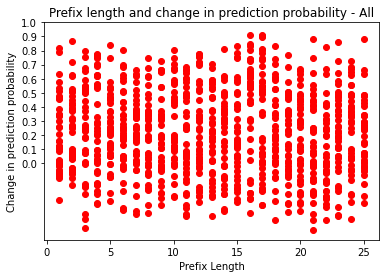

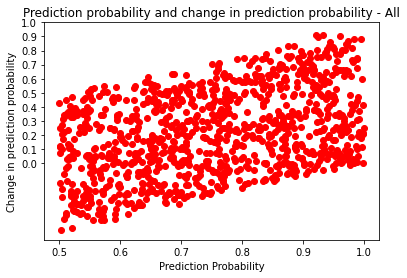

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

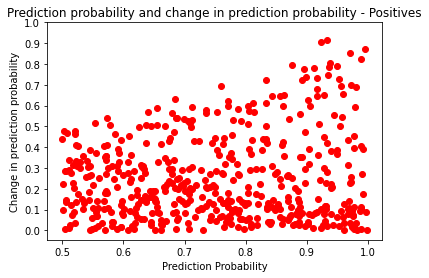

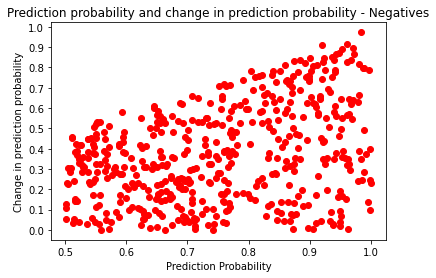

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

Bucket 1
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertu

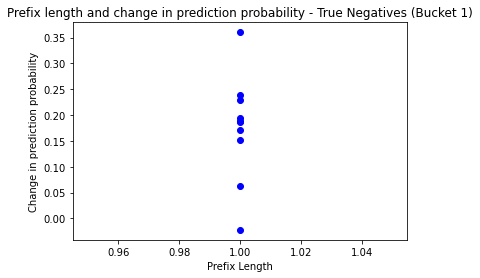

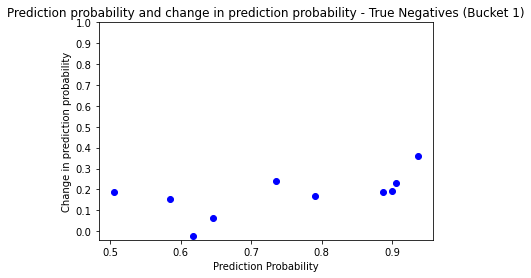

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Ru

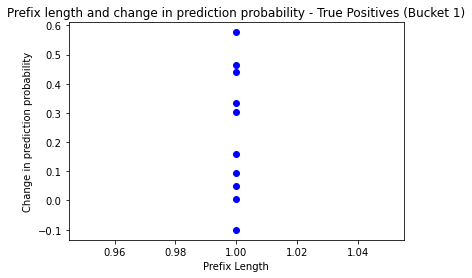

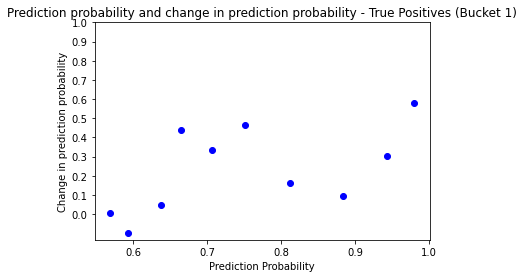

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Ru

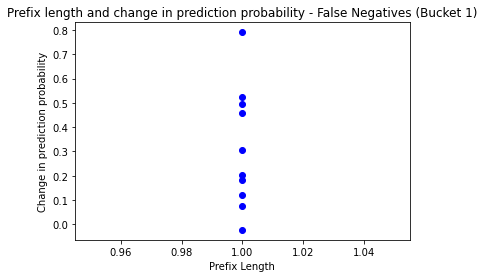

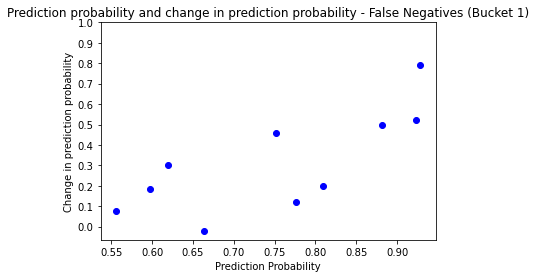

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Ru

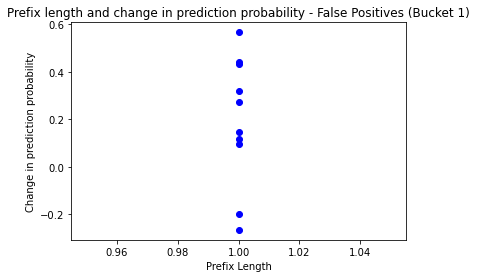

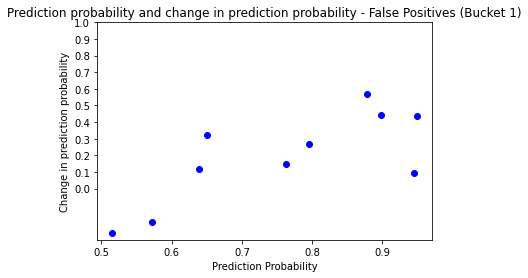

Bucket 2
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertu

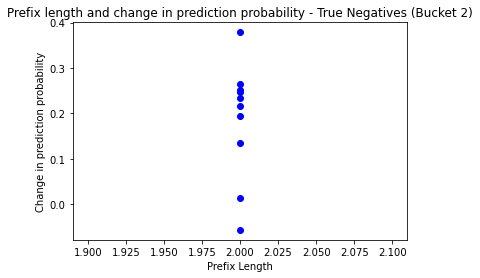

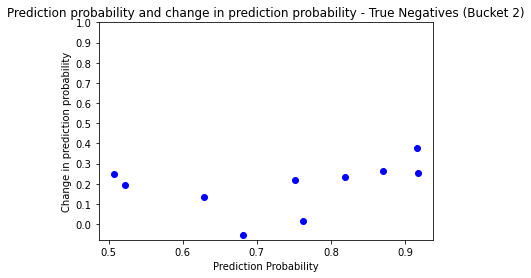

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Ru

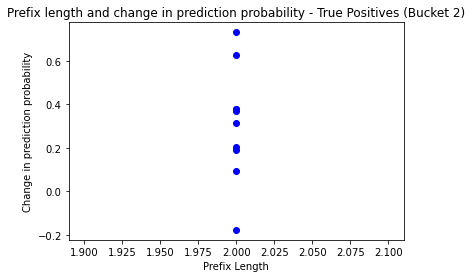

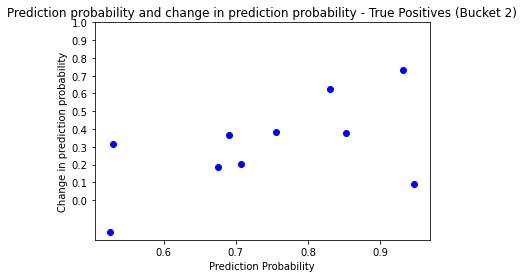

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Ru

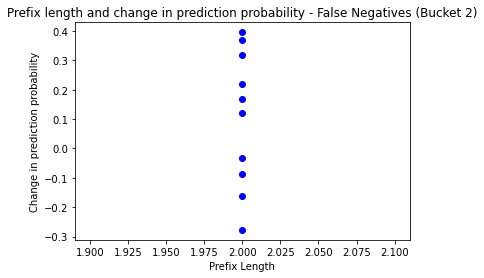

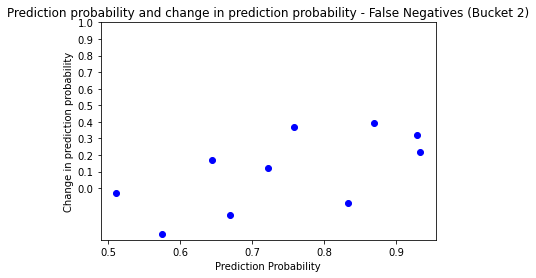

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Ru

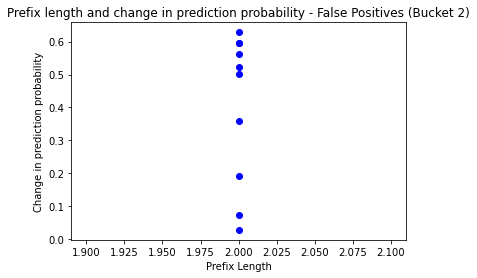

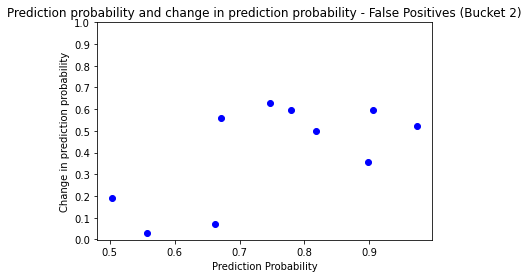

Bucket 3
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution f

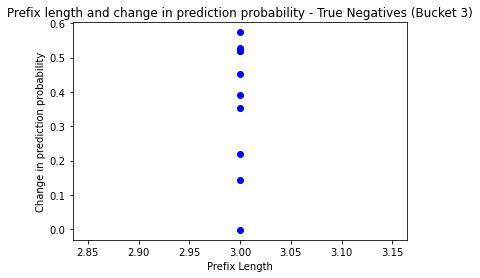

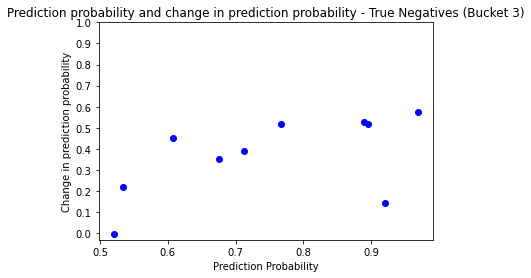

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for featur

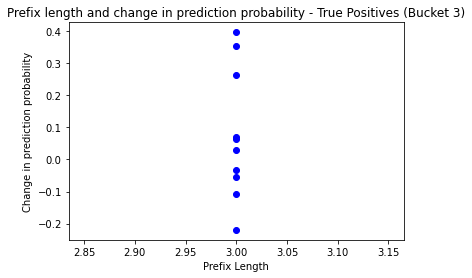

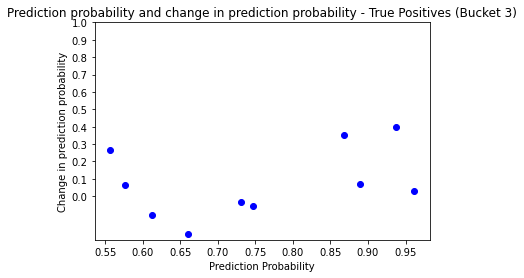

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for featur

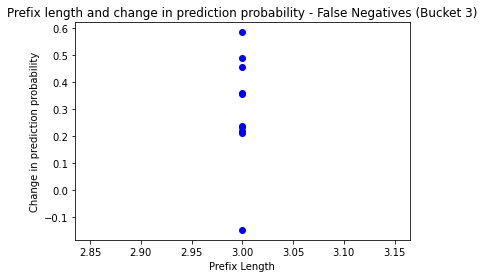

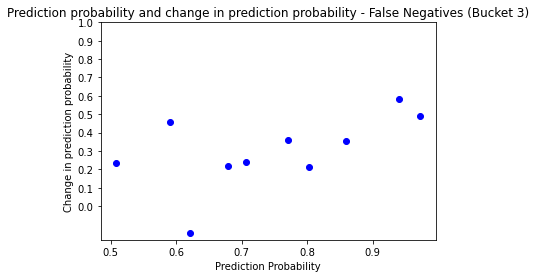

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for featur

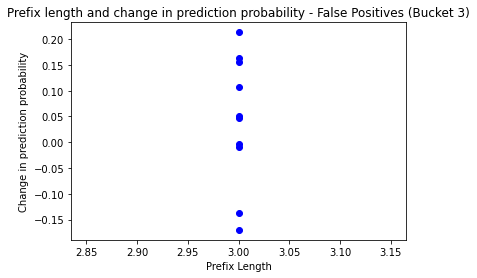

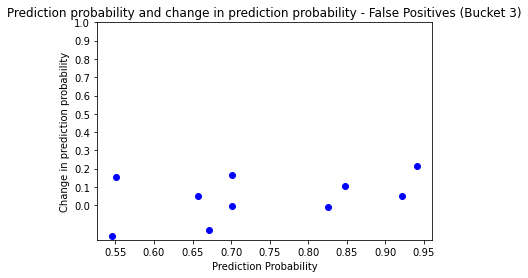

Bucket 4
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pert

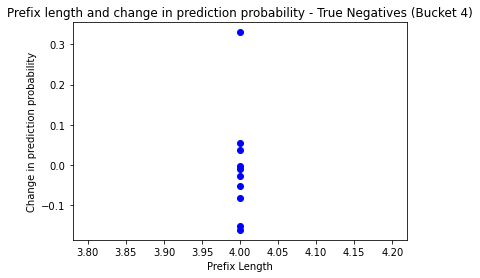

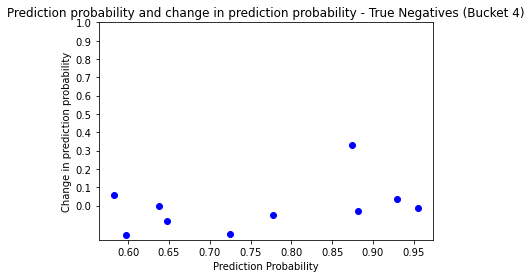

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - R

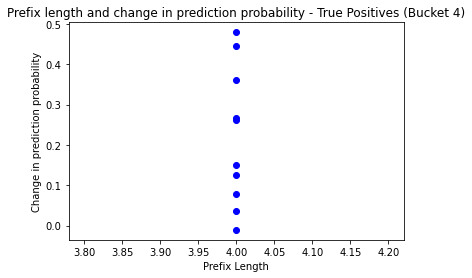

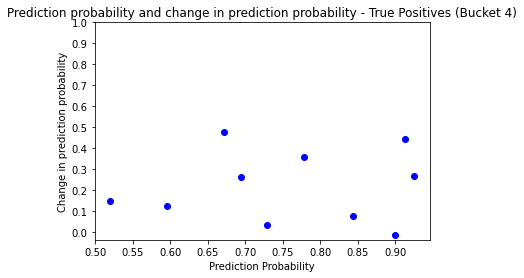

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - R

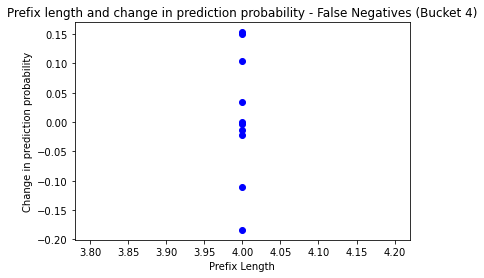

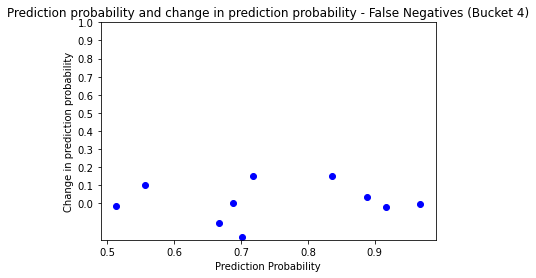

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - R

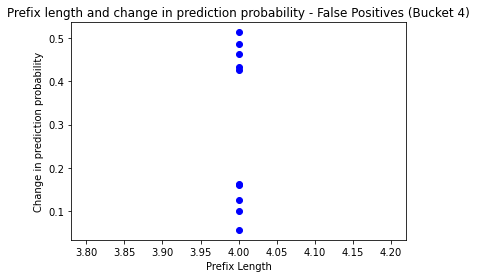

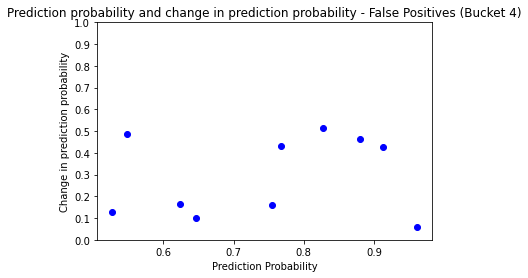

Bucket 5
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pert

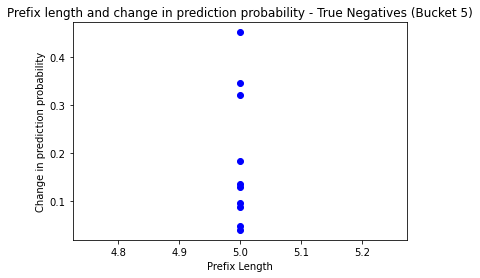

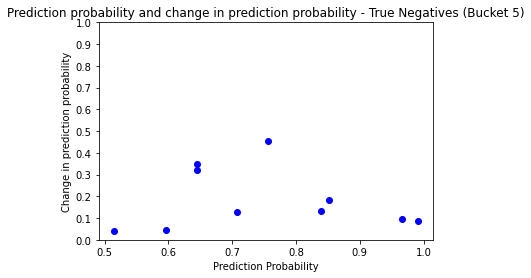

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - R

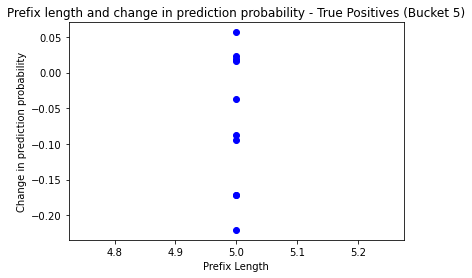

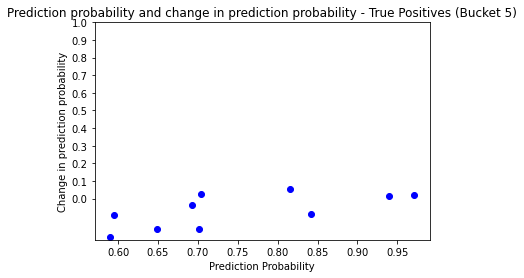

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - R

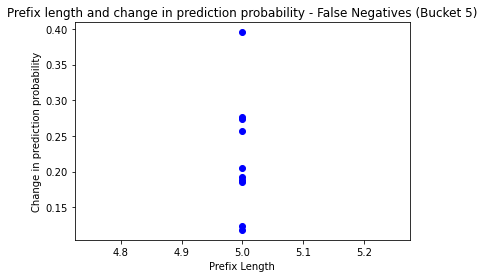

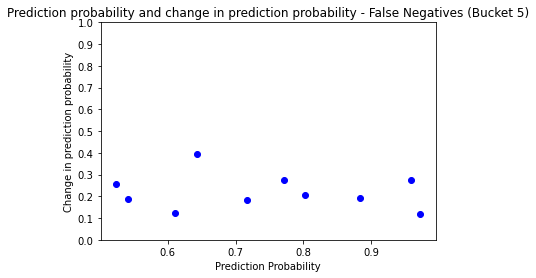

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - R

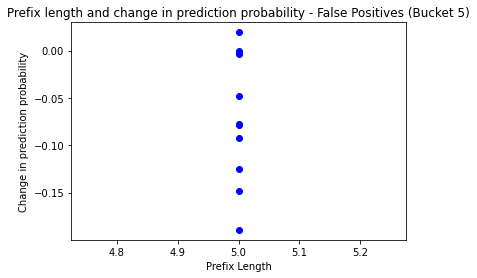

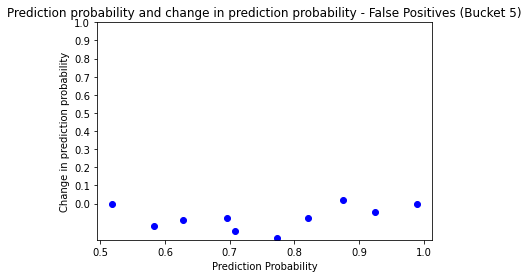

Bucket 6
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution

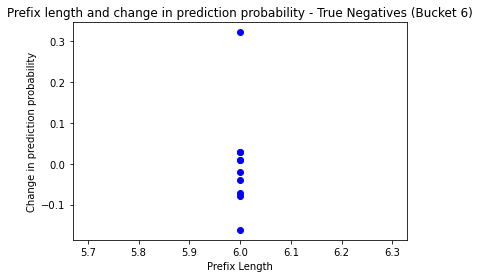

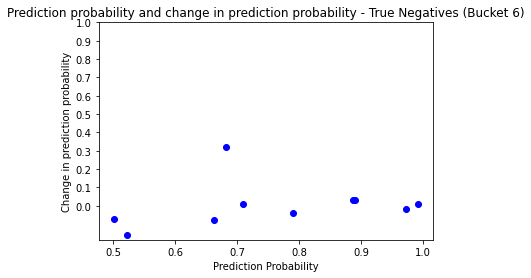

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

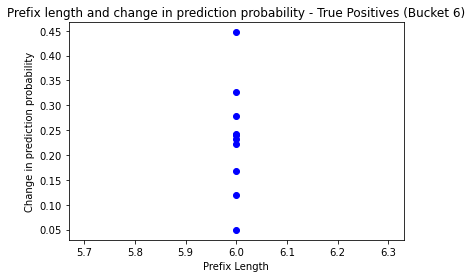

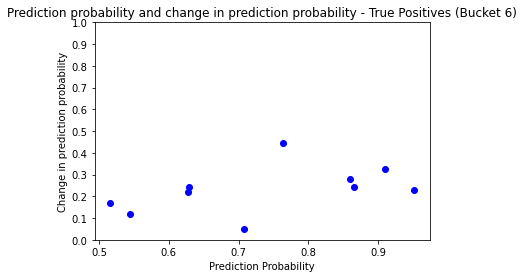

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

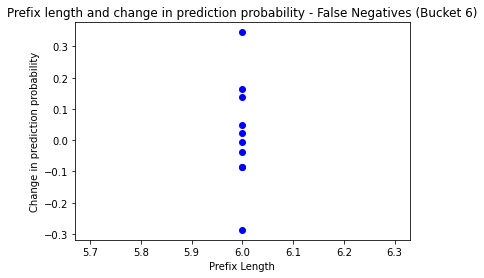

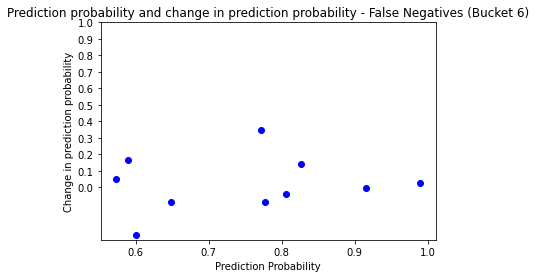

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

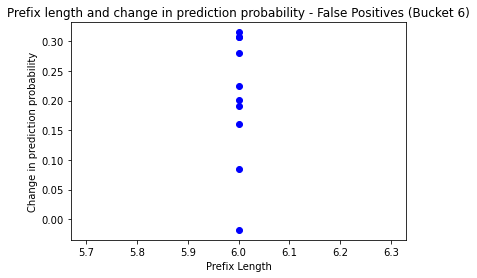

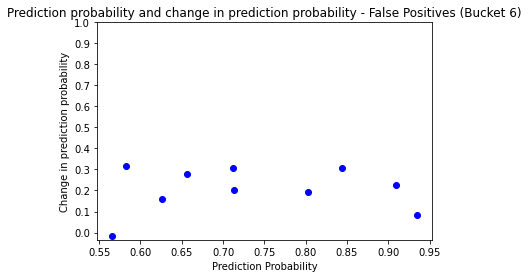

Bucket 7
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution

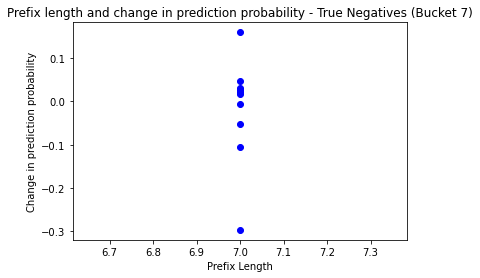

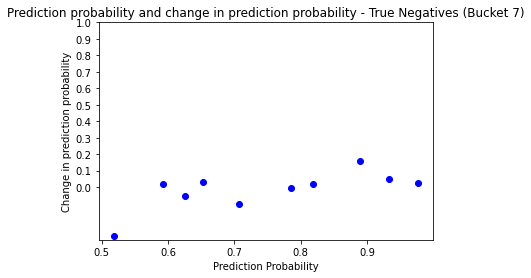

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

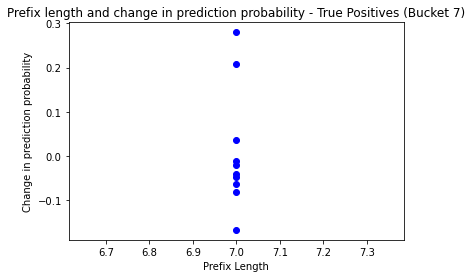

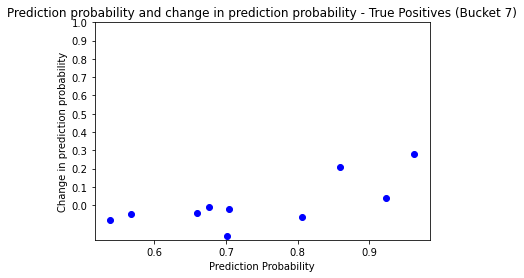

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

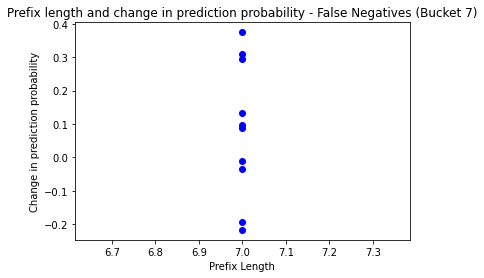

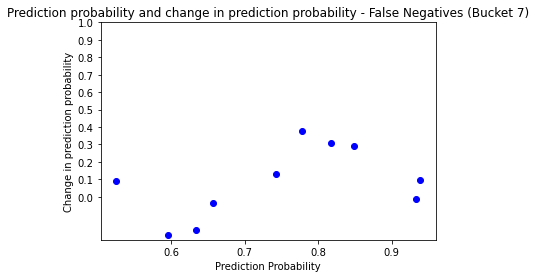

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

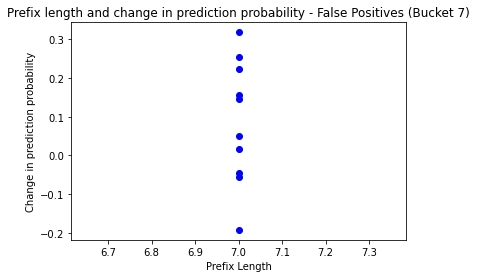

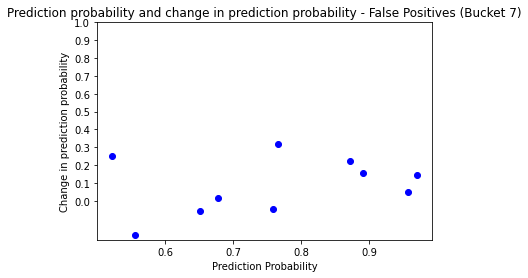

Bucket 8
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution

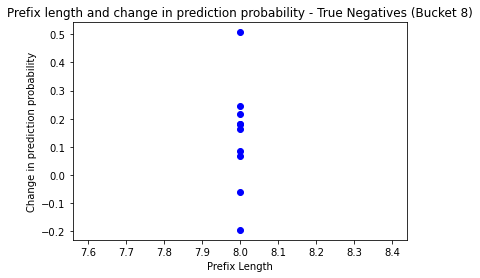

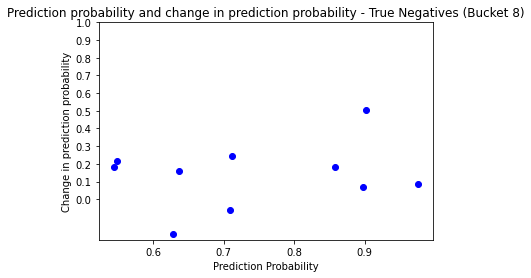

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

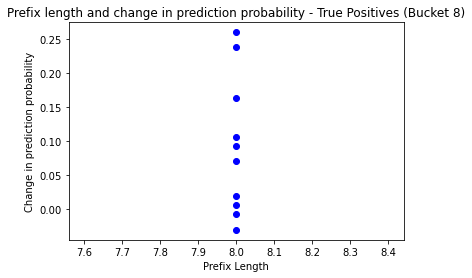

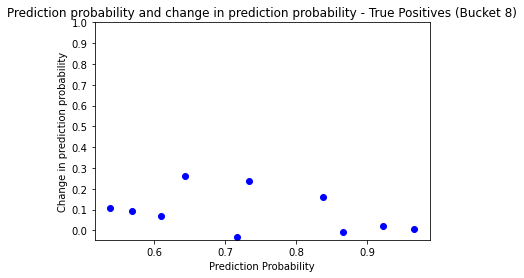

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

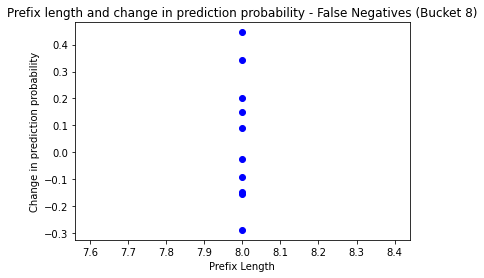

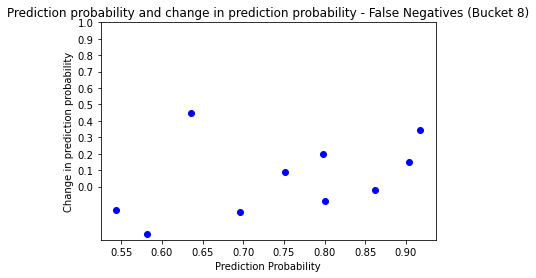

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

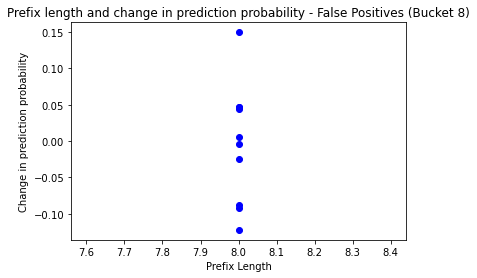

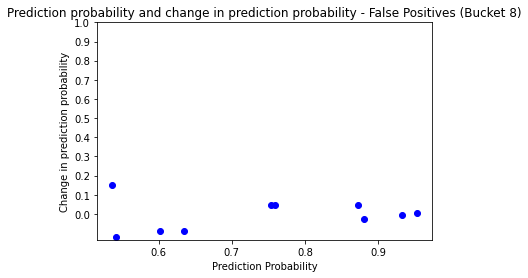

Bucket 9
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution

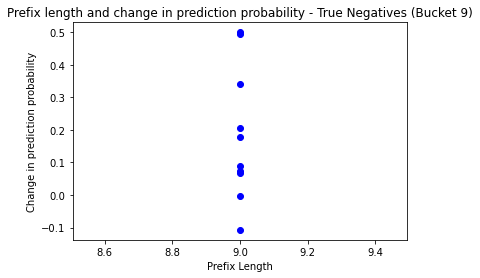

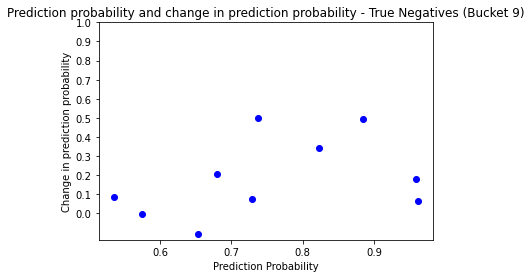

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

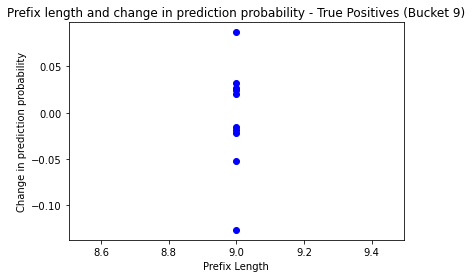

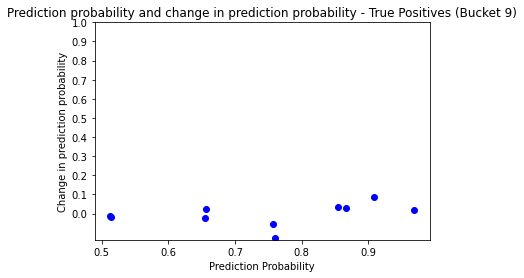

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

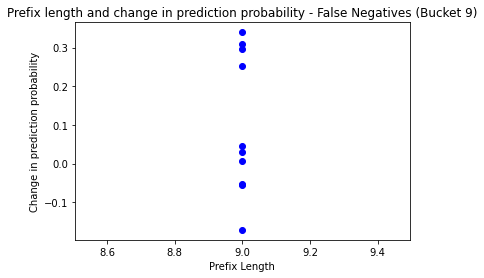

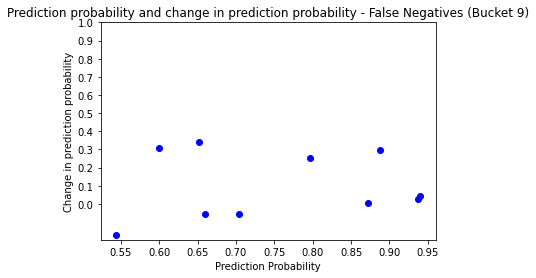

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

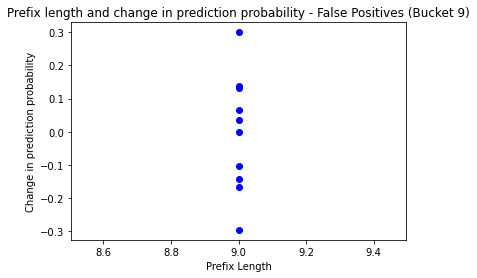

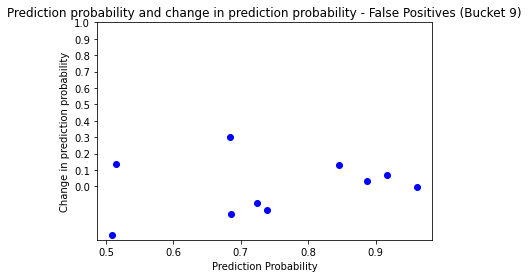

Bucket 10
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distributio

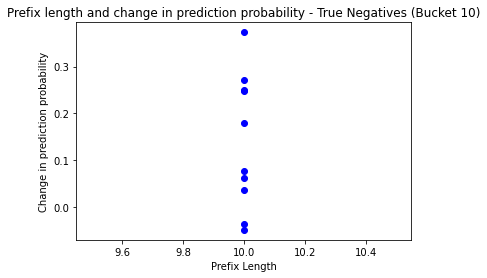

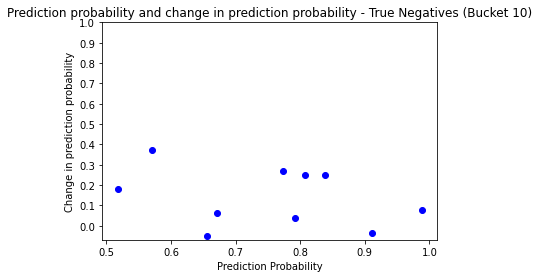

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

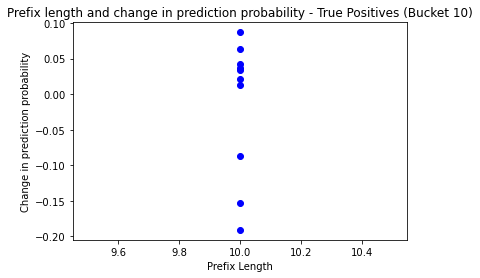

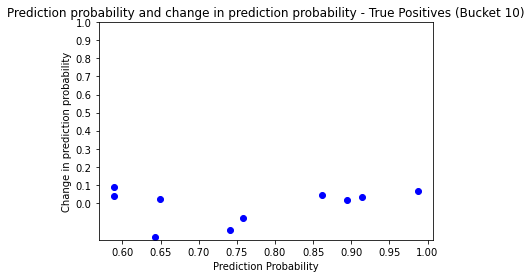

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

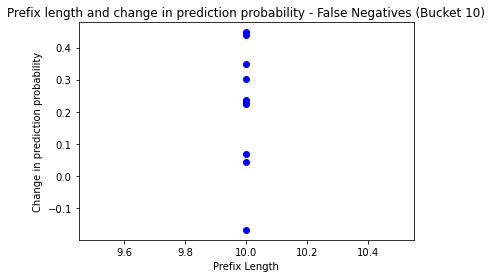

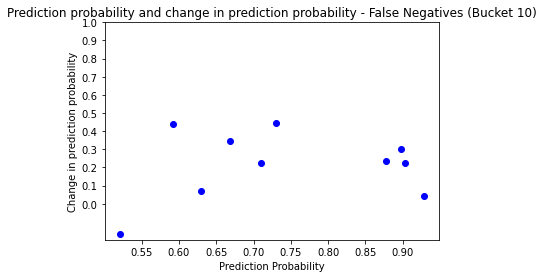

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

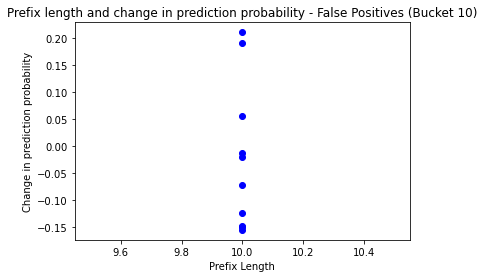

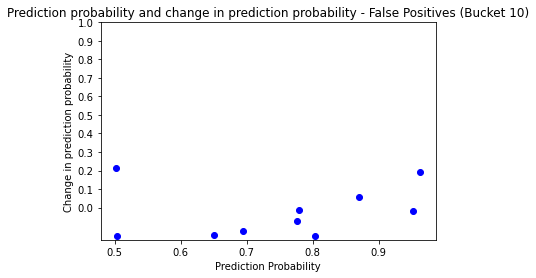

Bucket 11
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distributio

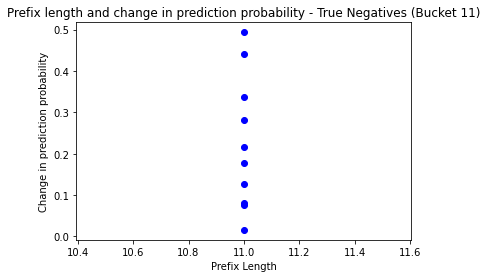

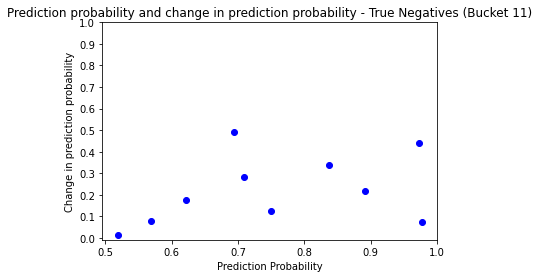

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

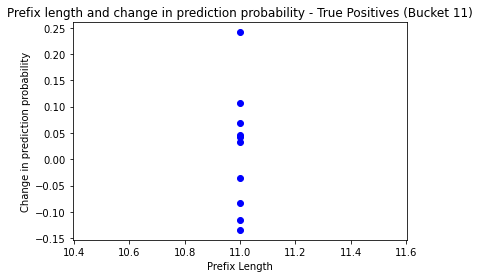

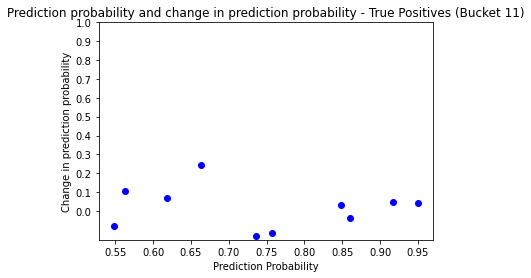

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

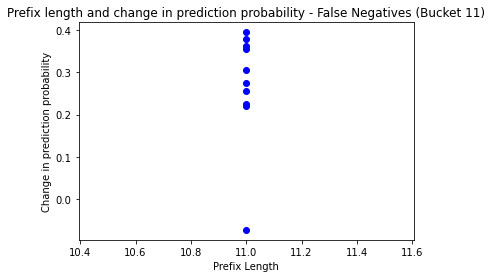

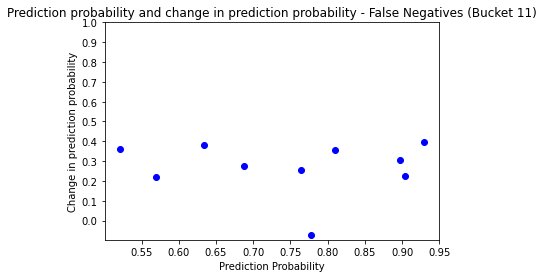

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

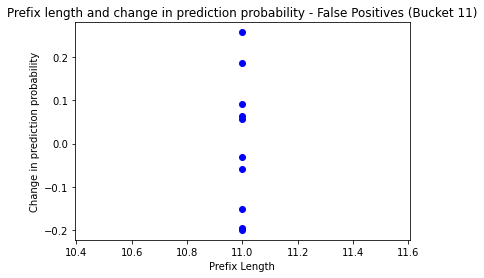

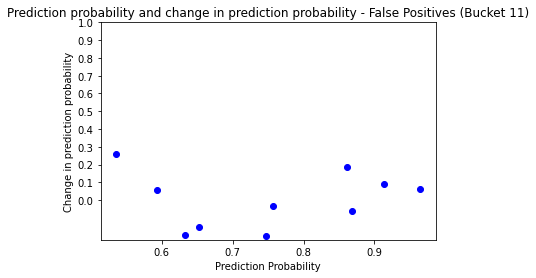

Bucket 12
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distributio

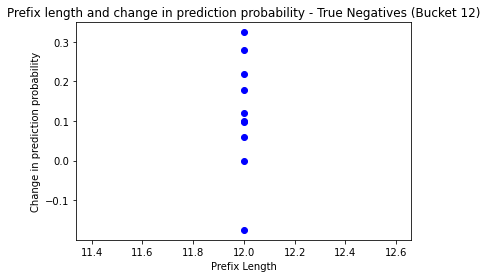

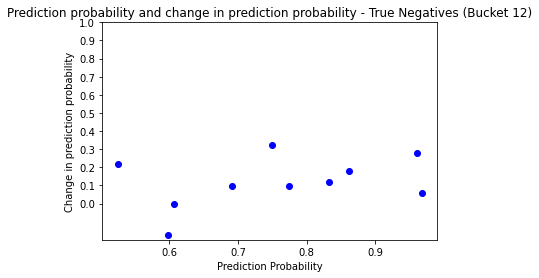

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

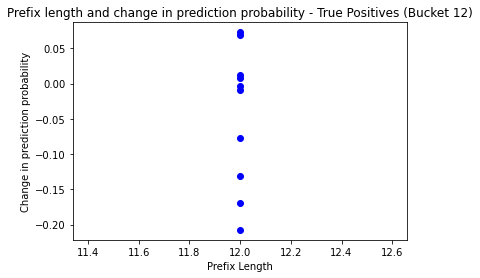

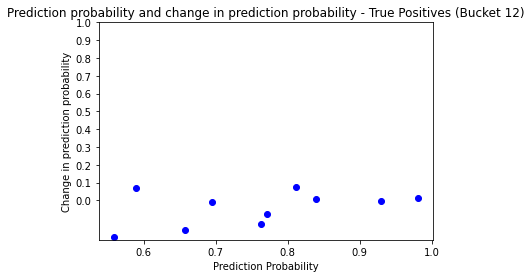

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

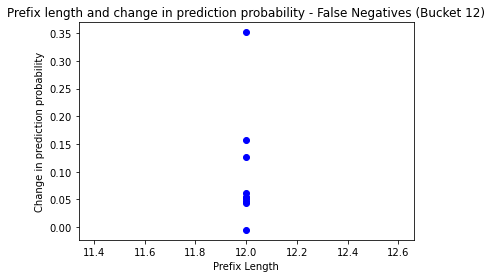

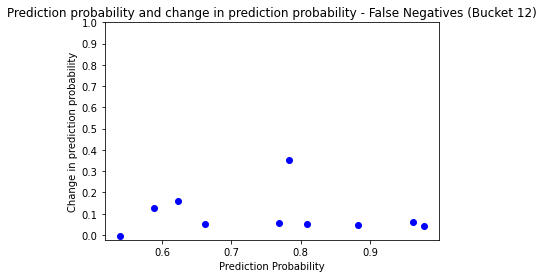

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feat

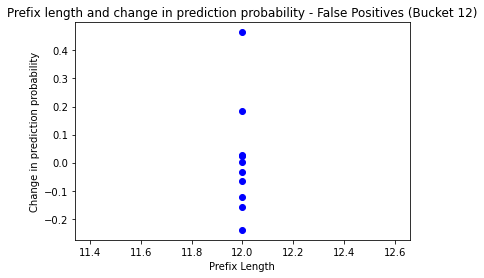

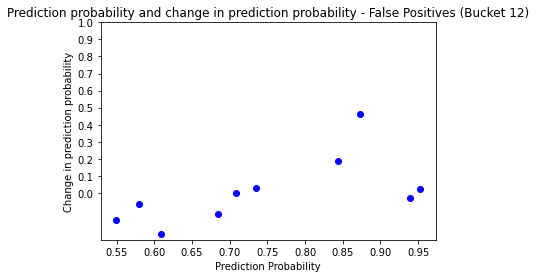

Bucket 13
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distributi

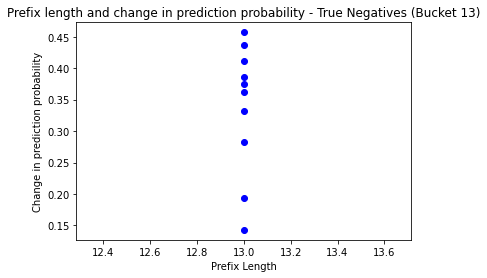

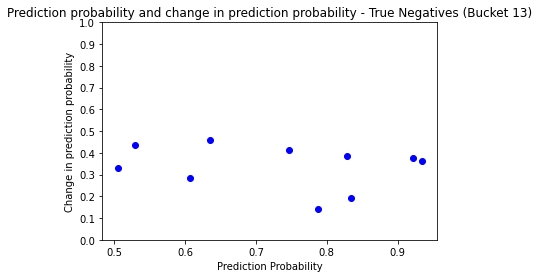

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

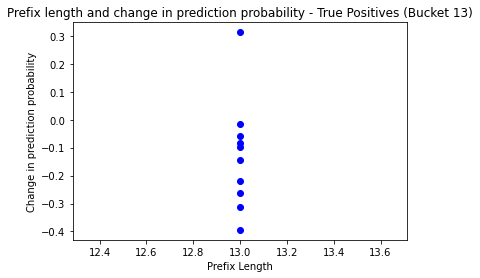

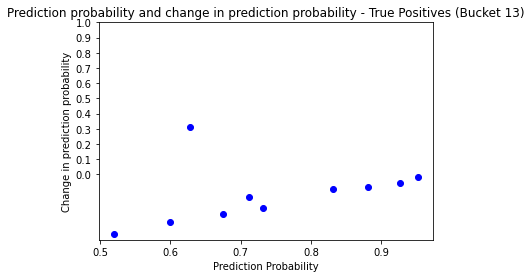

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

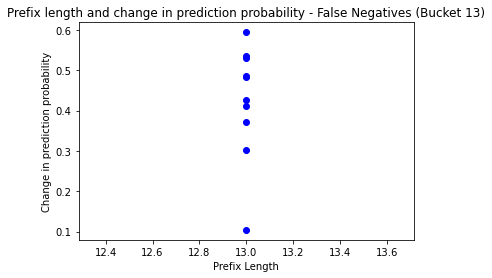

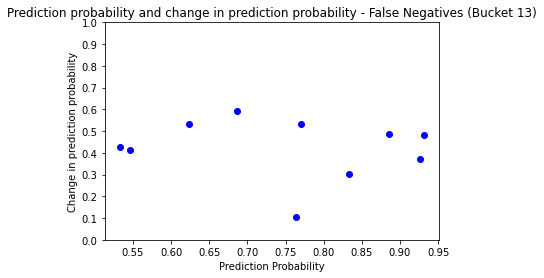

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

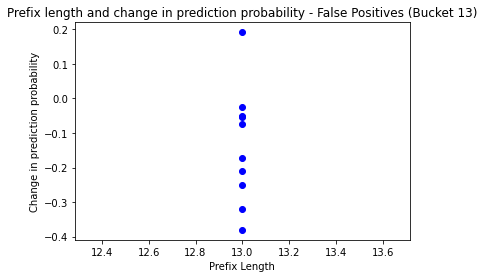

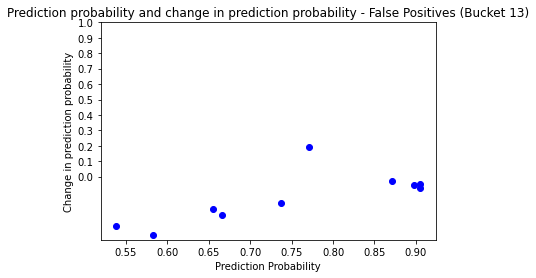

Bucket 14
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distributi

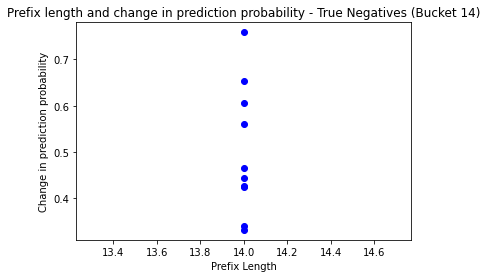

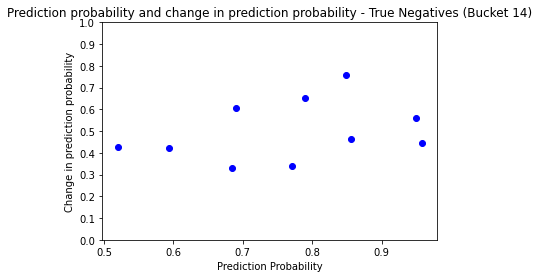

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

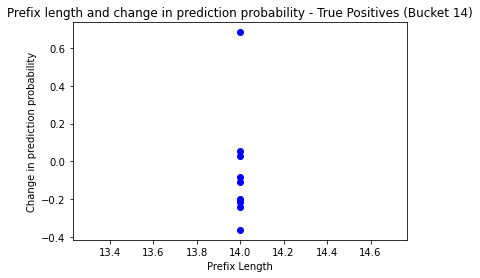

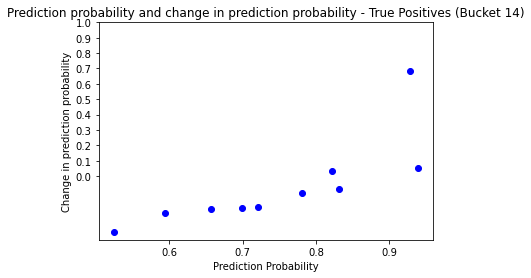

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

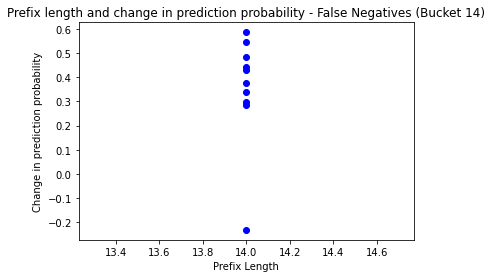

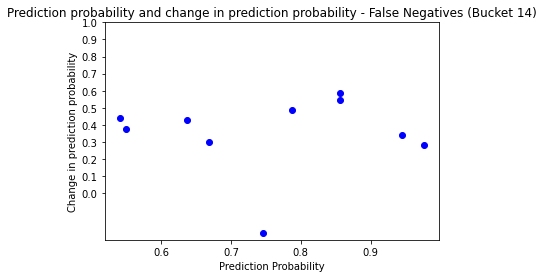

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

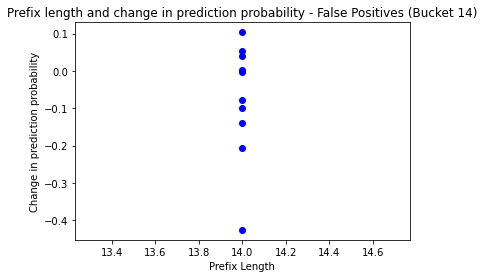

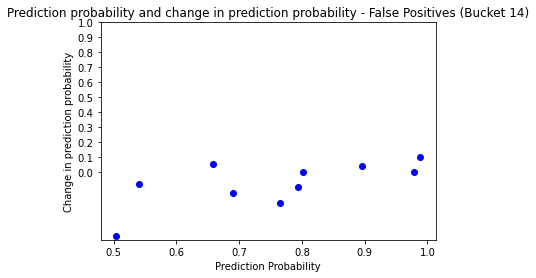

Bucket 15
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distributi

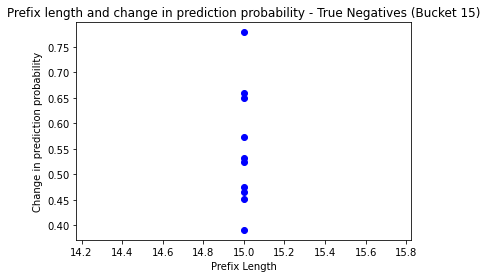

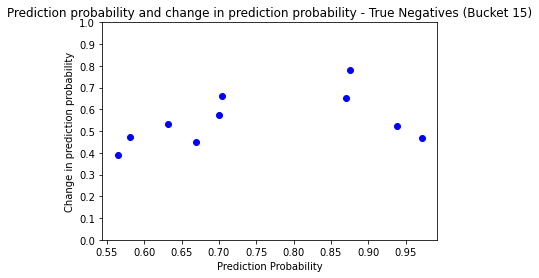

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

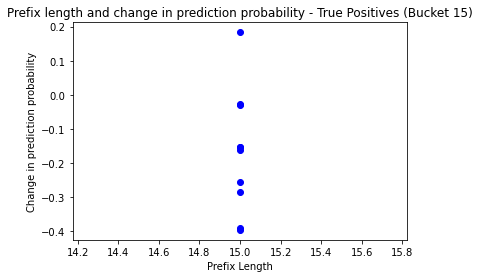

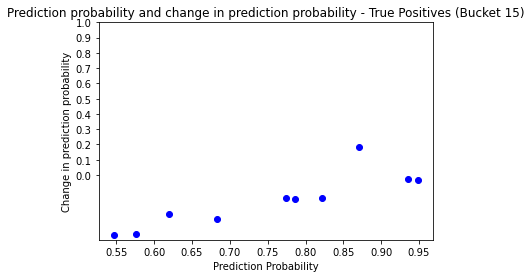

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

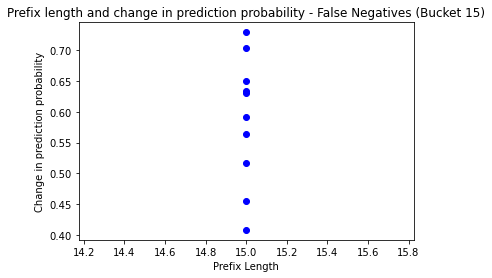

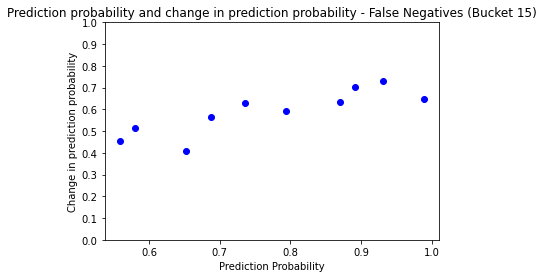

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

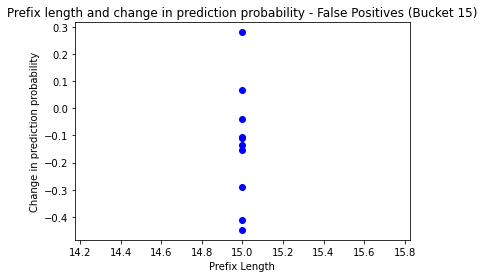

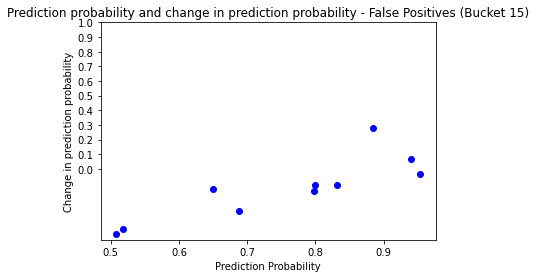

Bucket 16
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distributi

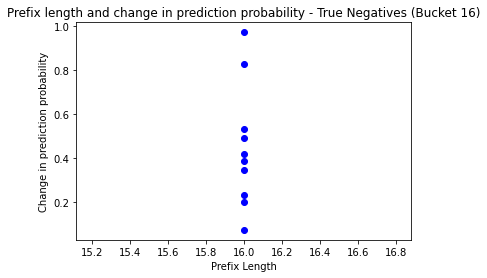

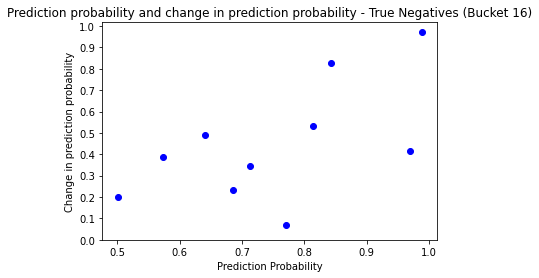

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

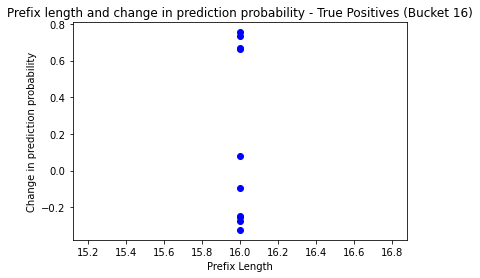

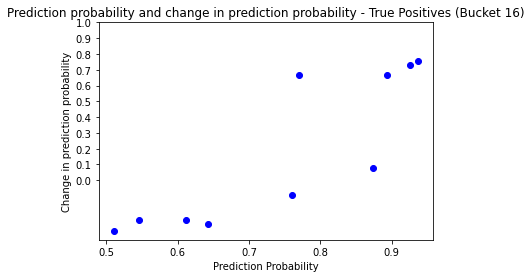

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

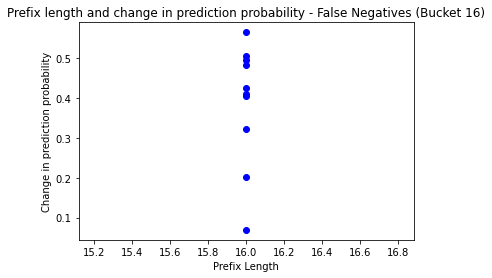

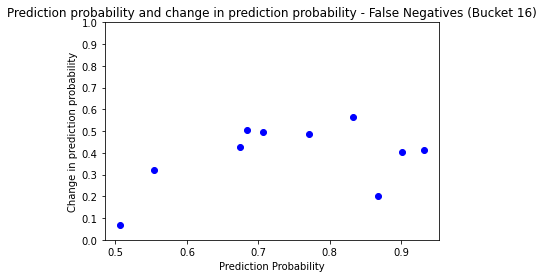

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

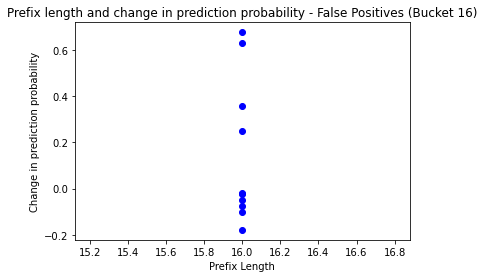

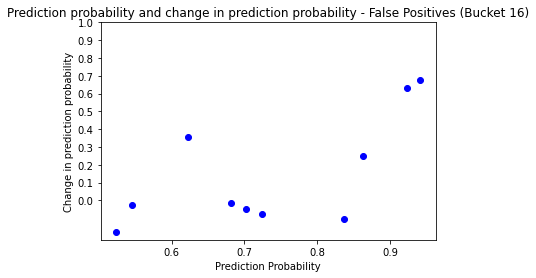

Bucket 17
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distributi

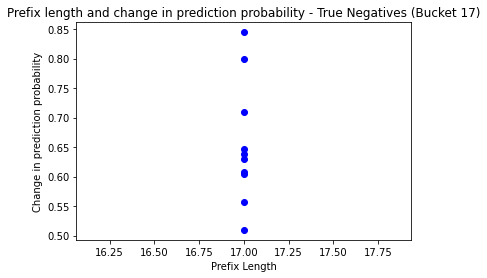

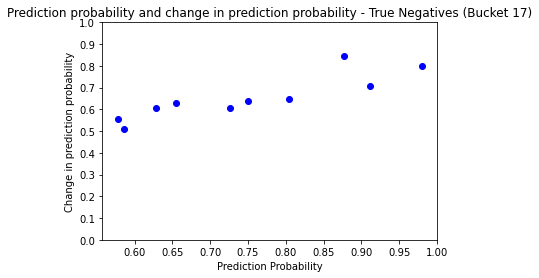

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

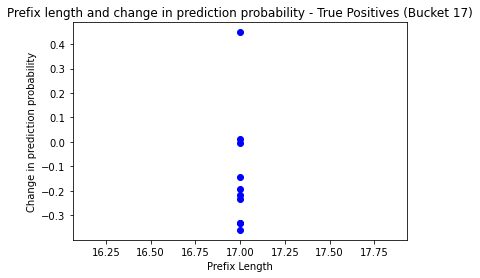

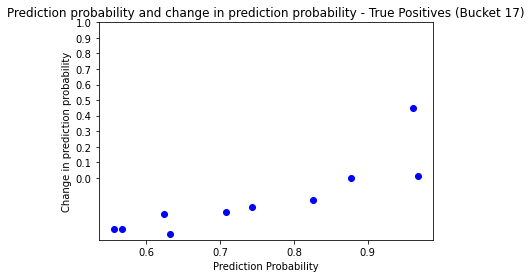

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

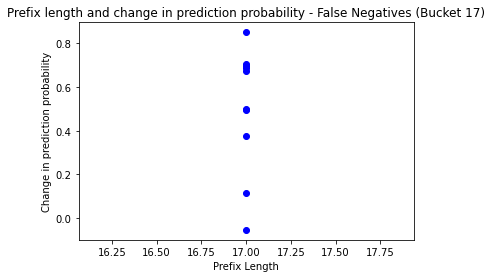

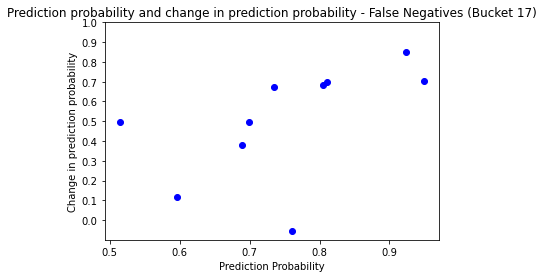

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for fea

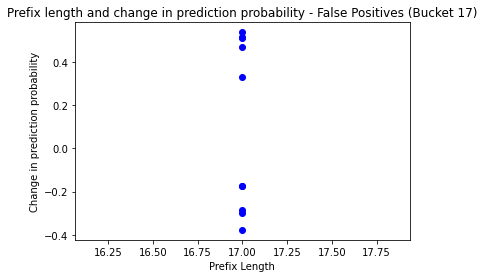

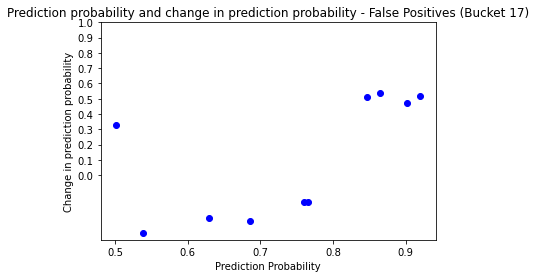

Bucket 18
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribut

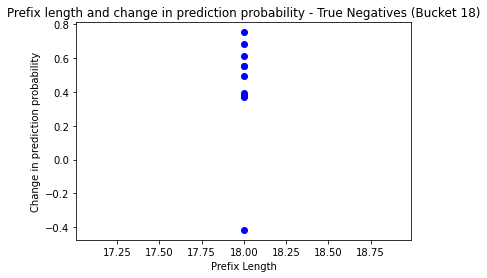

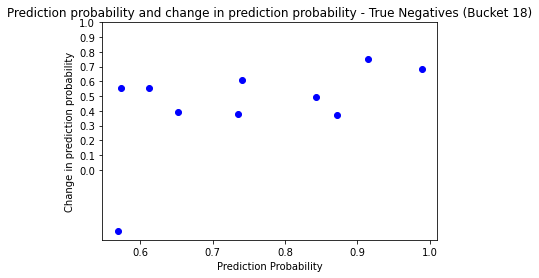

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

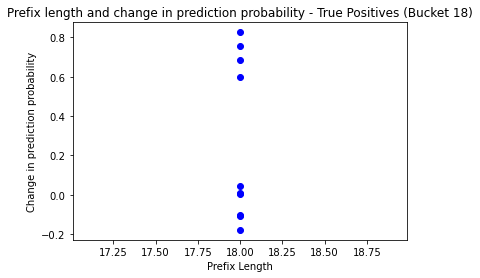

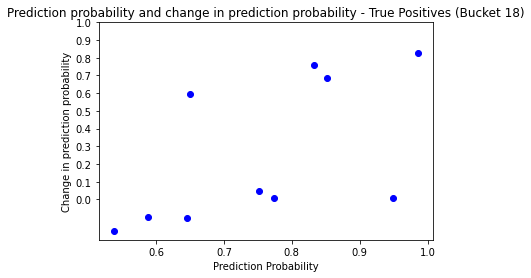

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

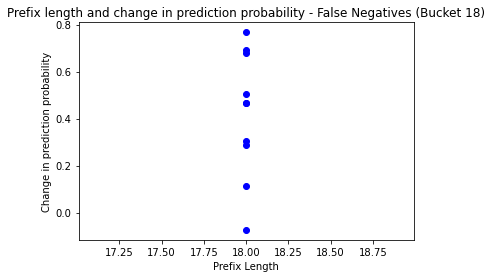

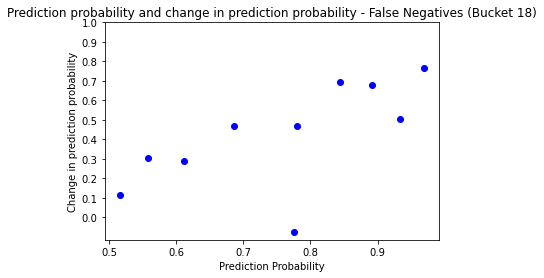

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

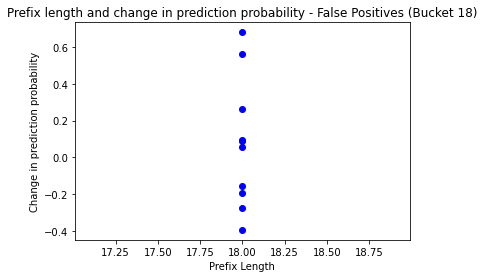

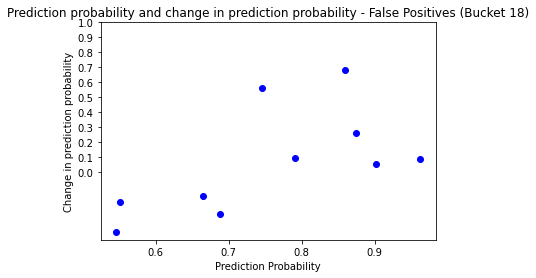

Bucket 19
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribut

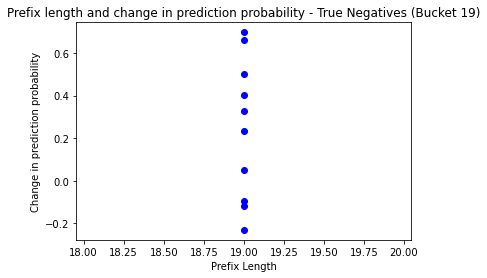

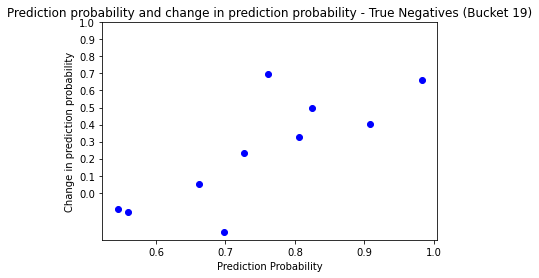

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

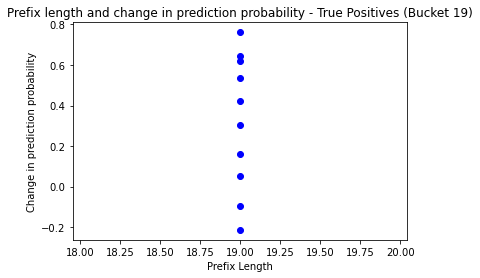

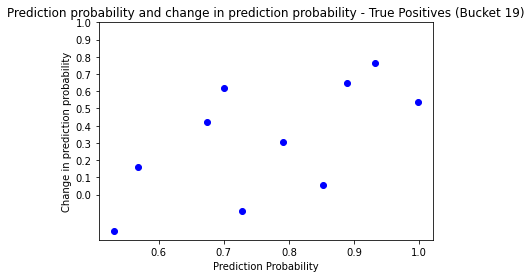

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

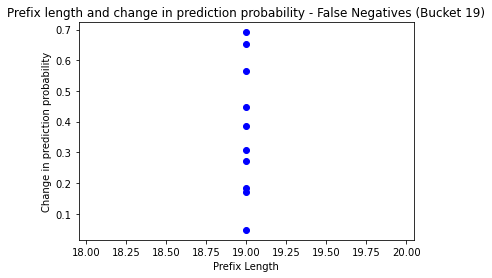

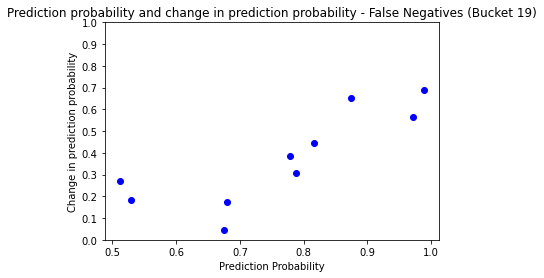

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

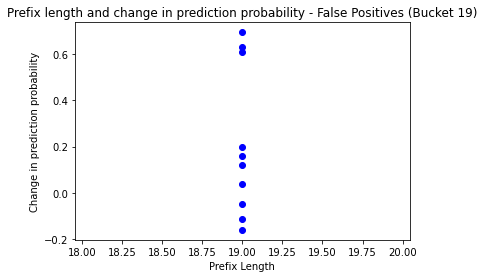

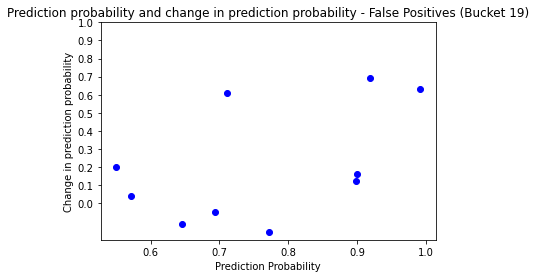

Bucket 20
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribut

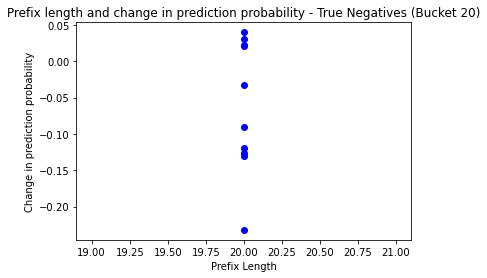

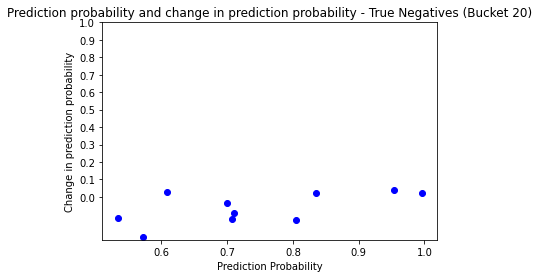

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

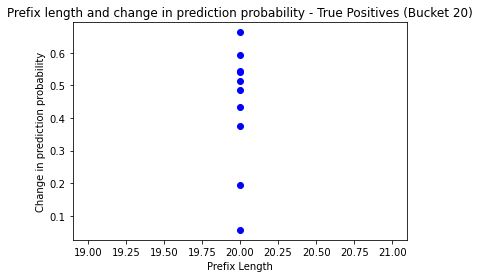

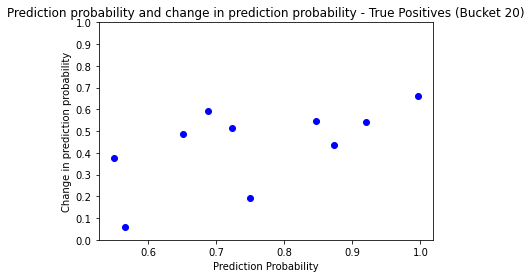

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

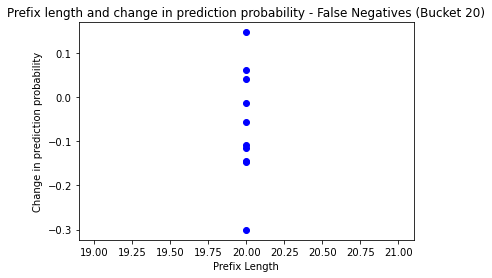

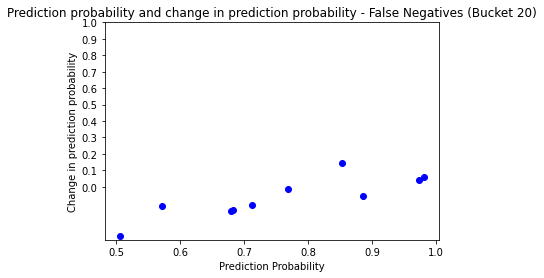

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

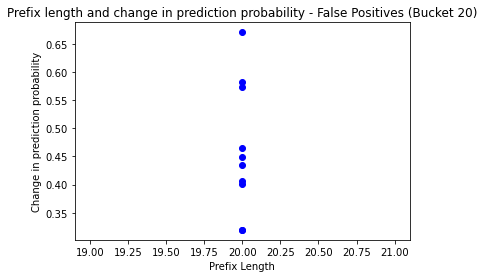

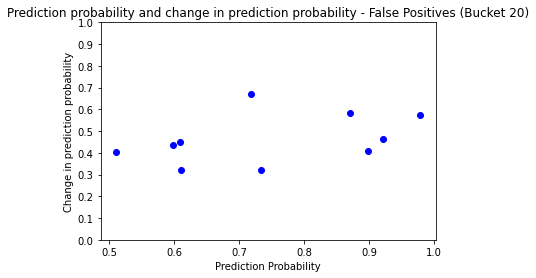

Bucket 21
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribut

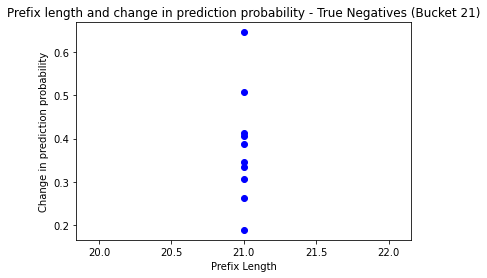

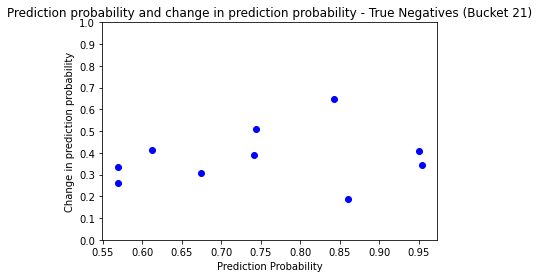

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

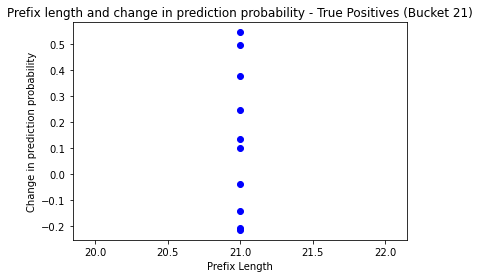

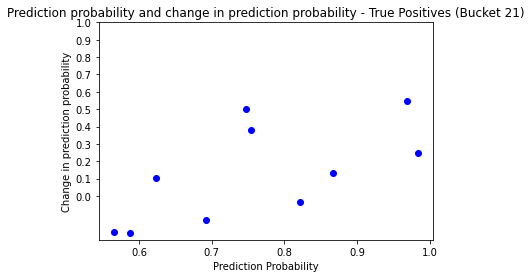

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

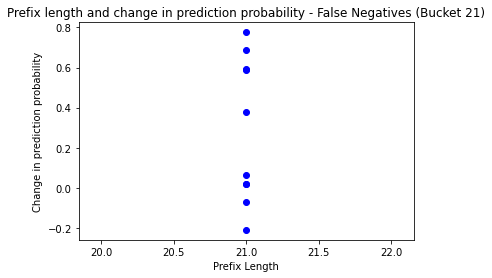

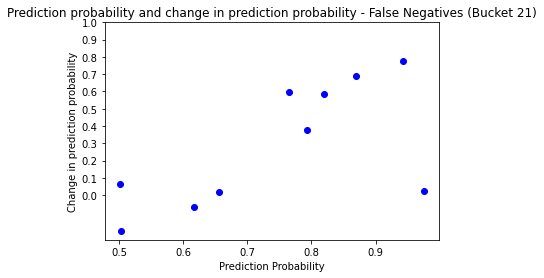

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

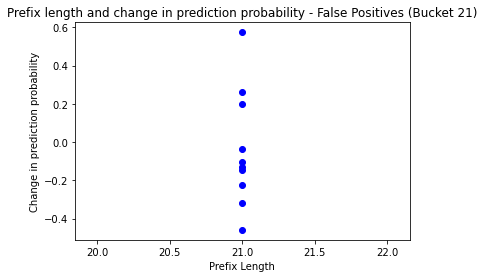

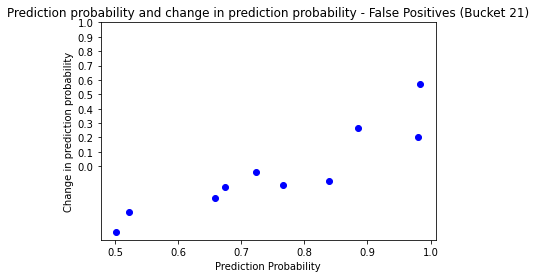

Bucket 22
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribut

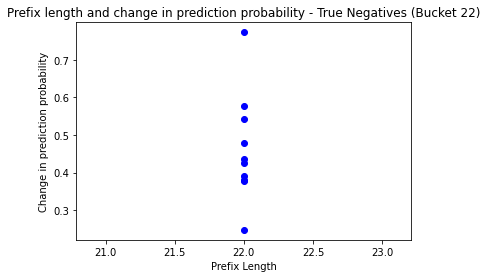

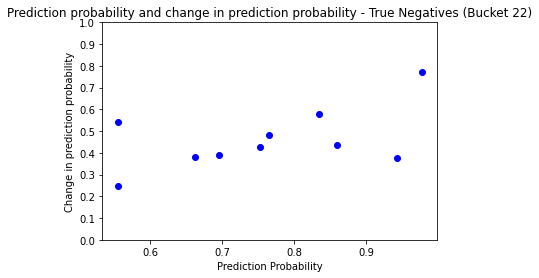

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

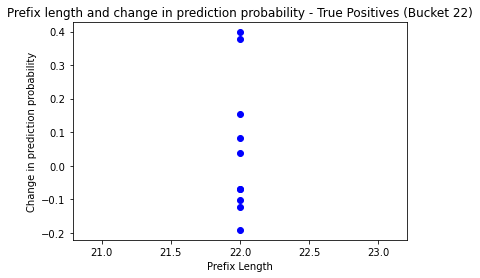

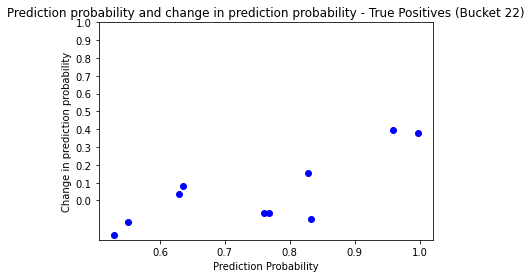

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

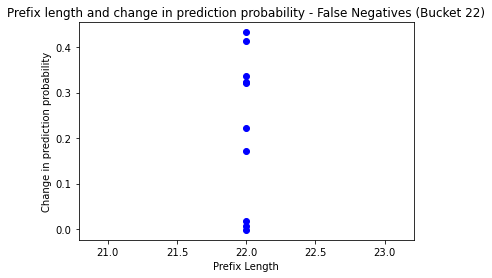

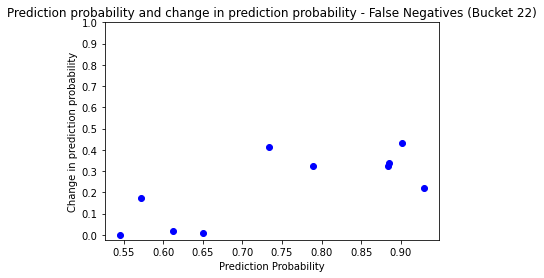

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

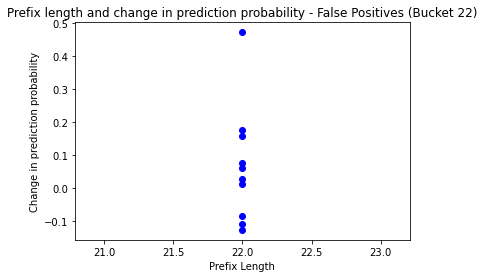

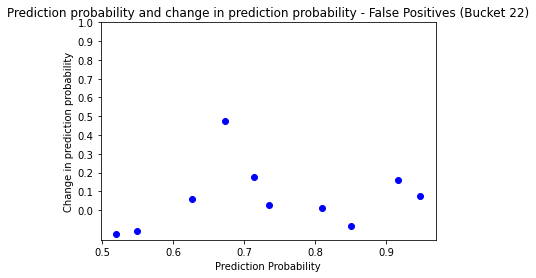

Bucket 23
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribut

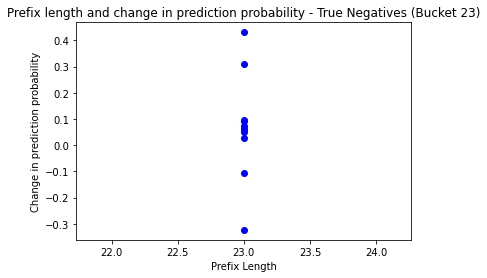

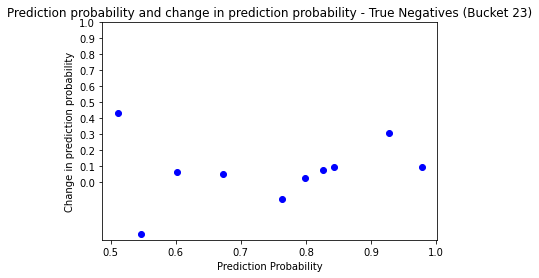

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

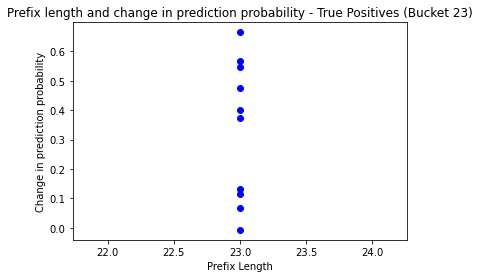

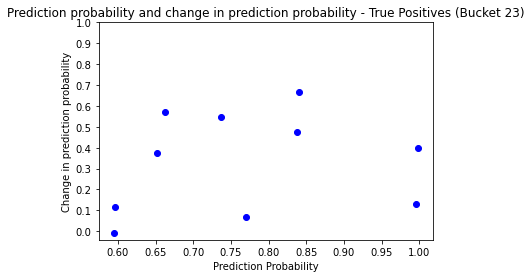

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

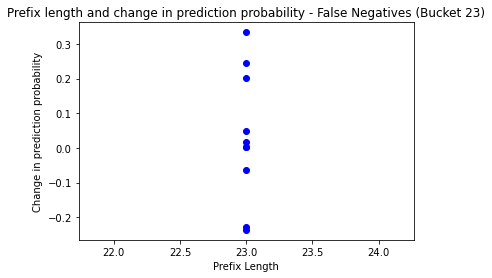

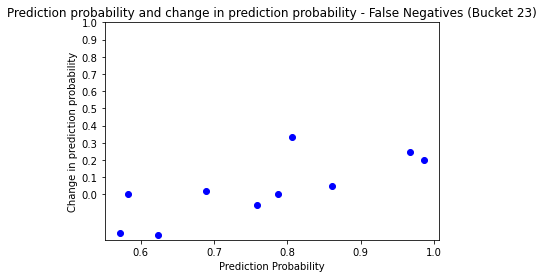

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

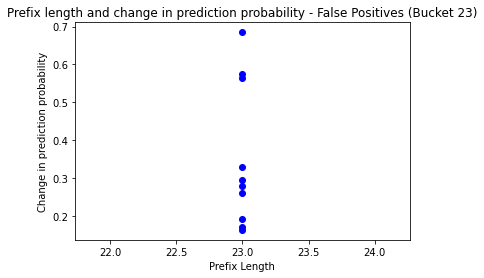

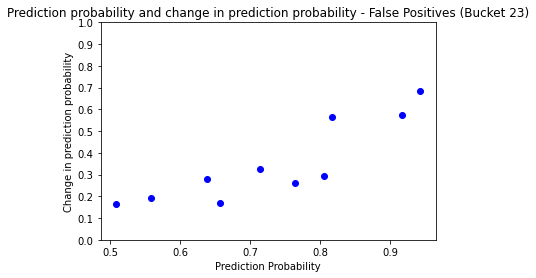

Bucket 24
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribut

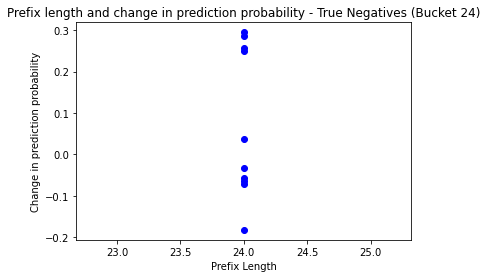

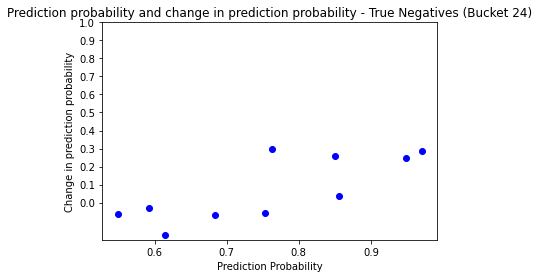

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

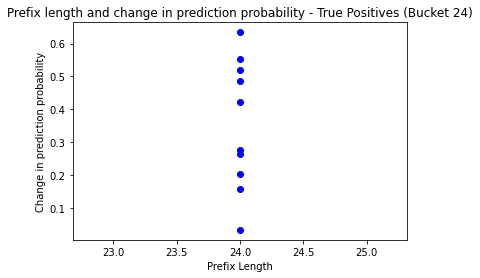

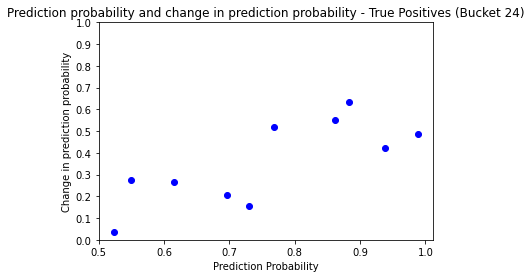

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

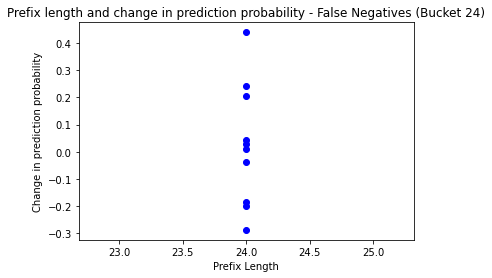

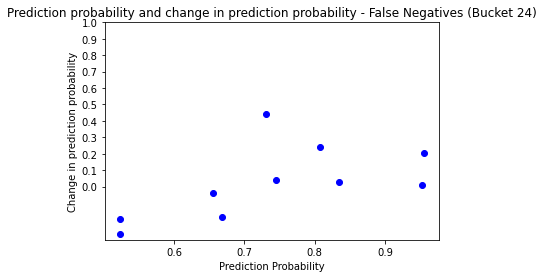

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

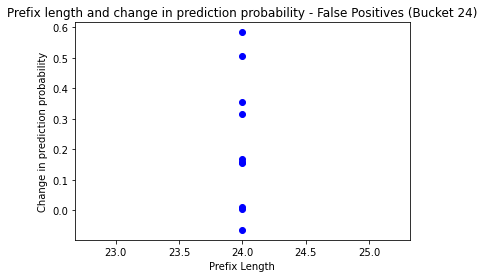

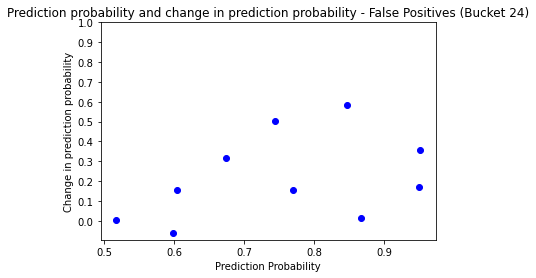

Bucket 25
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribut

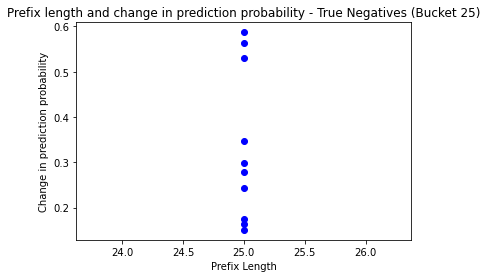

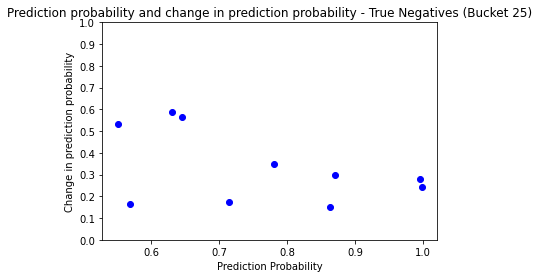

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

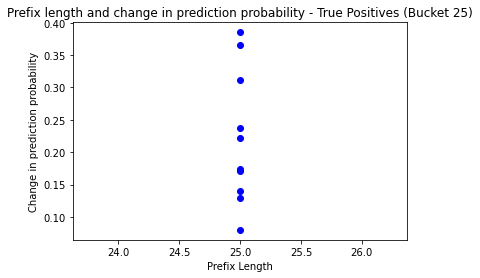

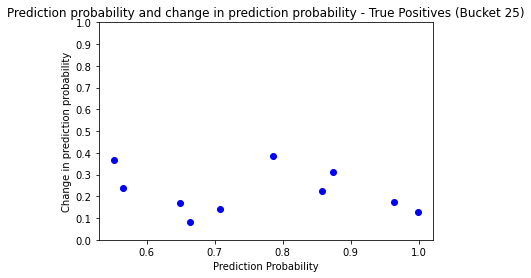

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

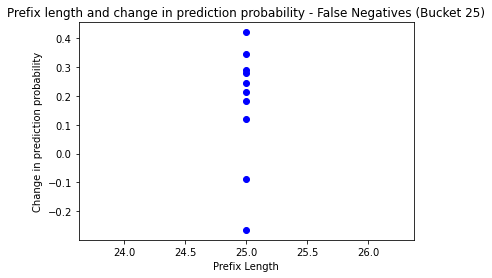

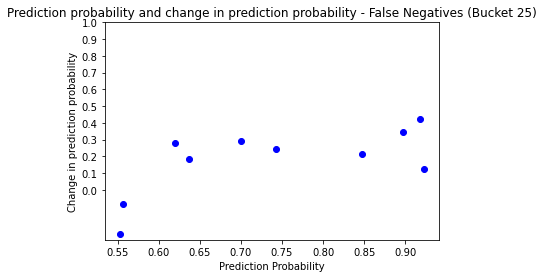

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for fe

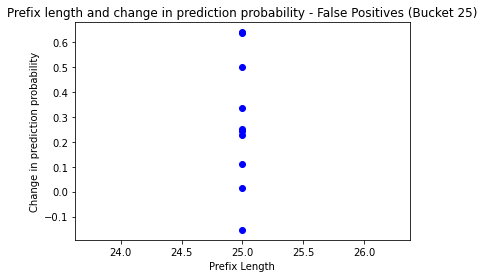

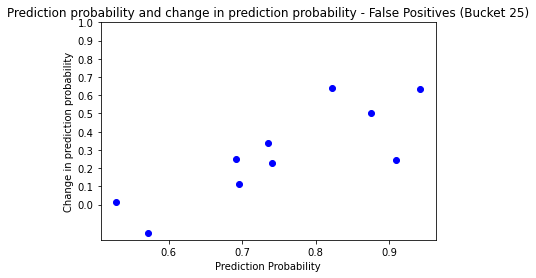

In [13]:
if generate_lime:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            buckets = range(0, max_prefix, gap)

            all_lime_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_lime_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_lime_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_train_path, 'rb') as f:
                    dt_train_bucket = pickle.load(f)
                with open (Y_train_path, 'rb') as f:
                    train_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)
                
                #get the training data as a matrix
                trainingdata = feature_combiner.fit_transform(dt_train_bucket);
                #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

                feat_list = feature_combiner.get_feature_names()
                max_feat = round(len(feat_list)*0.1)
                class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                        class_names=class_names, discretize_continuous=True)
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

                for i in list(range(len(sample_instances))):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for j in list(range(len(sample_instances[i]))):
                        print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                        instance = sample_instances[i][j]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        #print("proba:", p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        explanations = []
                        for iteration in range(exp_iter):
                            lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = max_feat)
                            explanation = lime_exp.as_list()
                            explanations.extend(explanation)

                        features = []
                        for explanation in explanations:
                            features.append(explanation[0])

                        counter = Counter(features)
                        check_dup = []
                        for feat in feat_list:
                            for feature in counter:
                                if feat in feature:
                                    check_dup.append(feat)

                        dup_counter = Counter(check_dup)
                        duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

                        for each in duplicated:
                            dpls = []
                            vals = []
                            for feat in counter.keys():
                                if each in feat:
                                    dpls.append(feat)
                                    vals.append(counter[feat])
                            keepval = vals.index(max(vals))
                            for n in range(len(dpls)):
                                if n != keepval:
                                    del counter[dpls[n]]

                        rel_feat = counter.most_common(max_feat)

                        intervals = []

                        for item in rel_feat:
                            print("Creating distribution for feature", rel_feat.index(item))
                            feat = item[0]
                            #print(item)
                            #print(feat)
                            for n in range(len(feat_list)):
                                if feat_list[n] in feat:
                                    if ("<" or "<=") in feat and (">" or ">=") in feat:
                                        two_sided = True
                                        parts = feat.split(' ')
                                        l_bound = float(parts[0])
                                        u_bound = float(parts[-1])
                                        interval = u_bound - l_bound
                                        new_min = u_bound
                                        new_max = u_bound + interval
                                    else:
                                        two_sided = False
                                        parts = feat.split(' ')
                                        if parts[-2] == "<=" or parts[-2] == "<":
                                            u_bound = float(parts[-1])
                                            if u_bound != 0:
                                                interval = math.ceil(u_bound*1.1)
                                            else:
                                                interval = 5
                                            new_min = u_bound
                                            new_max = u_bound + interval
                                        elif parts[-2] == ">=" or parts[-2] == ">":
                                            l_bound = float(parts[-1])
                                            if l_bound != 0:
                                                interval = math.ceil(l_bound*1.1)
                                            else:
                                                interval = 5
                                            new_max = l_bound
                                            new_min = l_bound - interval
                                        else:
                                            bound = float(parts[-1])
                                            interval = math.ceil((bound*1.1)/2)
                                            new_min = bound
                                            new_max = bound+interval
                                    feature_name = feat_list[n]
                                    index = n
                                    int_min = new_min
                                    int_max = new_max
                                    intervals.append((feature_name, index, int_min, int_max))

                        diffs = []
                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))
                        
                        instance['lime_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_lime_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_lime_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(nr_events, changes, 'bo', label = "LIME")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(probas, changes, 'bo', label = "LIME")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    all_lime_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

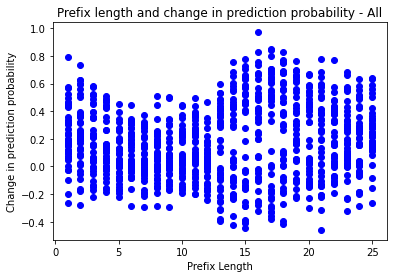

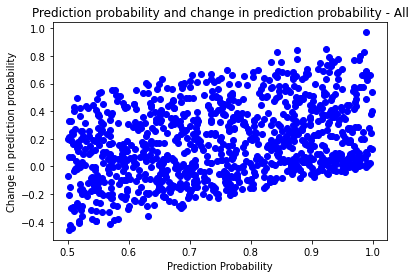

In [14]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

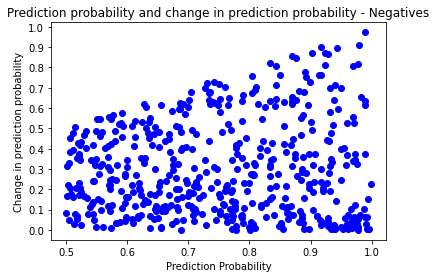

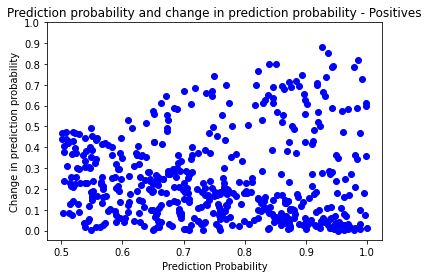

In [15]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [16]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

LIME Fidelity Score: 0.1716355232204661 
SHAP Fidelity Score: 0.22223011916596433


In [17]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

Positive predictions: 
LIME Fidelity Score: 0.2994659353517927 
SHAP Fidelity Score: 0.2484987362534739
Negative predictions: 
LIME Fidelity Score: 0.2478918194770813 
SHAP Fidelity Score: 0.3717722433805466
